#               INCIDENT MANAGEMENT  PROCESS IMPROVEMENT   


## Prediction of time to resolution.

# Introduction

In most of the service based IT industry service now(SNOW)  is the go to management tool  to carry out service management tasks. This provides users and service providers a centralized service catalog for  requesting or accepting service requests based on the services provided by ABC company to their clients. All the information regarding a request is compiled in the incident ticket and stored for future references. 

What is an incident ? According to ITIL(Information Technology Infrastructure Library) it is defined as an unplanned interruption to or quality reduction of an IT service. Hence faster an incident is solved better IT service is being provided to the client as per the SLA (Service level agreement) between the service provider and the client.

This project intends to predict time to resolution for an incident as soon as it is logged into service now, so that the most effective form of service can be provided to the clients by ABC company.



## Who does this matter to ?

All the stakeholders that are affected by the SLA  (Service level agreement) between client and service providers, will be able to implement strict ITIL practices to improve the resolution time on every incident ,saving penalties and continuously improving service quality.  


## Data source and information


This is an event log of an incident management process extracted from data gathered from the audit system of an instance of the ServiceNowTM platform used by an IT company. The event log is enriched with data loaded from a relational database underlying a corresponding process-aware information system. Information was anonymized for privacy.

Number of instances: 141,712 events (24,918 incidents)
Number of attributes: 36 attributes (1 case identifier, 1 state identifier, 32 descriptive attributes, 2 dependent variables)

The attributed “closed_at” is used to determine the dependent variable for the time completion prediction task. The attribute “resolved_at” is highly correlated with “closed_at”. In this event log, some rows may have the same values (they are equal) since not all attributes involved in the real-world process are present in the log.

Attributes used to record textual information are not placed in this log.The missing values should be considered “unknown information”.

All the above information has been taken from UCL website for purely educational purposes. Please find the link to the mentioned website here . Below are the source and citation for all the data used in this project.

## Source:

Claudio Aparecido Lira do Amaral, claudio.amaral '@' usp.br, University of SÃ£o Paulo, Brazil
Marcelo Fantinato, m.fantinato '@' usp.br, University of SÃ£o Paulo, Brazil
Sarajane Marques Peres, sarajane '@' usp.br, University of SÃ£o Paulo, Brazil

## Citation :

Amaral, C. A. L., Fantinato, M., Reijers, H. A., Peres, S. M., Enhancing Completion Time Prediction Through Attribute Selection. Proceedings of the 15th International Conference on Advanced Information Technologies for Management (AITM 2018) and 13th International Conference on Information Systems Management (ISM 2018), Revised Selected Papers â€“ Lecture Notes in Business Information Processing, v. 346, pp. 3-23, 2019. [Web Link]

Moreover, refer to the Machine Learning Repository's citation policy.

## Basic Methodology:

Data Wrangling steps will be performed on the dataset to inspect the data prior to discovering as much detail and information on the type of data that has been collected.Finding if data that is needed is structured properly and if not convert them so that it can be better perceived.Data cleaning will also will be a major step as data might have inconsistency.  Panda and Numpy will be main tools that will be used to perform data wrangling.
Exploratory Data Analysis to understand the relationship between incident state,reassignment_count,reopen_count,made_sla,opened_at,contact_type,location,category,assignment_group and resolved_at .
Exploring multiple machine learning techniques to predict time to resolution and the factors causing the delays in each ticket.

	



In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
%matplotlib inline
sns.set()
sns.set(style='ticks', context='notebook')
sns.set(font_scale=3.0)
plt.rcParams['figure.figsize'] = [30, 25]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams["axes.labelsize"] = 30

### Utility functions

In [124]:
## minute convertor ##

def min_conv(x, y, z, data):
    """
    Function to convert a datetime object into minutes, for ease of calculation.
    :param x: Time variable(type : datetime)
    :param y: Time Variable(type: datetime)
    :param z: New column name
    :param data: DataFrame name
    :return: difference of x - y in min
    """
    data["days"] = (data[x] - data[y]).dt.days  # separating days from datetime element and calculating difference.
    data['seconds'] = (data[x] - data[y]).dt.seconds  # separating seconds from datetime element and calculating difference.
    data[z] = (data['days'] * 24 * 60) + (data['seconds'] / 60)  # Adding days and seconds together after converting to minutes.
    data[z] = data[z].astype('int64')  # Converting the result into integer data type for calculation.
    data = data.drop(["days", 'seconds'], axis=1, inplace=True)  # dropping the unnecessary column.

    
    
    
## percentage annotation##    
    
def bar_perc(ax):
    """
    This func annotate the bar chart by calculating the bar hieght and shows
    distribution as "%".
    
    :param ax: class 'matplotlib.axes._subplots.AxesSubplot
    :return: Nonetype
    """
    totals = []  # create a empty list

    for i in ax.patches:  # ax.patches to select each bar as a rectangle
        totals.append(i.get_height())  # .get_height() is used for vertical bar chart use .get_width() for horizontal()

    total = sum(totals)  # for getting total no of elements with height as proxy

    for i in ax.patches:
        ax.text(i.get_x() + 0.15, i.get_height() + 100,
                str(round((i.get_height() / total) * 100, 2)) + '%', color='black') 
        # .get_x() gets the starting x-axis and for y-axis use .get_height

    
    
## count annotation##        
def bar_count(ax):
    """
    This func annotate the bar chart by calculating the bar hieght and shows
    distribution as count.
    :param ax: class 'matplotlib.axes._subplots.AxesSubplot
    :return: Nonetype
    """
    totals = []  # create a empty list

    for i in ax.patches:  # ax.patches to select each bar as a rectangle
        totals.append(i.get_height())  # .get_height() is used for vertical bar chart use .get_width() for horizontal()

    total = sum(totals)  # for getting total no of elements with height as proxy

    for i in ax.patches:
        ax.text(i.get_x() + 0.15, i.get_height() + 50, str(round(i.get_height(),2)), color='black')

# .get_x() gets the starting x-axis and for y-axis use .get_height   



## Calculation of ECDF ##

def ecdf(data):
    """
    :param data:  A n by 2 dataframe.
    :return: x, y value 
    """
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n

    return x, y

## Ploting ECDF ###
def ecdf_plot(colname):
    """
    This function is used create lineplot for the nx2 dataframe.
    :param colname: A n by 2 dataframe.
    :return: lineplot plot
    """
    for i, j in enumerate(colname):
        plt.subplot(2, 2, i + 1)
        x, y = ecdf(inc_closed[j])
        ax = plt.plot(x, y, marker='.', linestyle='none')
        plt.xlabel((j), fontsize=35)
        plt.ylabel("ECDF", fontsize=35)
        plt.margins(0.2)

### Loading data file from the local location

In [125]:
#Loading data
file = 'incident_event_log.csv'
inc_event = pd.read_csv(file)


#coverting this data to a panda dataframe for further data wrangling

inc_eventdf = pd.DataFrame(inc_event)
pd.options.display.max_columns = None

### Replacing Missing Values

As mentioned in the data source missing value is defined as symbol "?", hence replacing it with NaN value for coputational ease.

In [126]:
#to replace missing value symbol '?' to NaN
inc_eventdf = inc_eventdf.replace(to_replace=['?'],value = [np.nan]) 

While looking into the dataset samples few of the columns had irregular data type hence correcting it to appropriate data types.

#### This is ideally done at this stage so that coverted information might be used to fill in missing information on required columns.

In [127]:
col_name = ['sys_created_at','opened_at','sys_updated_at','resolved_at','closed_at']
 
for col in col_name:
    inc_eventdf[col] = pd.to_datetime(inc_eventdf[col], dayfirst = True)

As resolved_at is one of the major columns which will be used in this project , all the missing values needs to fixed beforehand.

As the at each stage of the incident ticket the log timings are recorded in sys_updated_at this can be used to fill in the missing information.

In [128]:
# and using ffill to fill the missing value where the incident_state is 'Closed'

m = inc_eventdf.incident_state == 'Resolved' 
y = inc_eventdf.resolved_at.isnull()
c =inc_eventdf.incident_state == 'Closed'
inc_eventdf['resolved_at'] = np.where(m & y,inc_eventdf['sys_updated_at'],inc_eventdf['resolved_at'])
inc_eventdf['resolved_at']= np.where(c & y,inc_eventdf['resolved_at'].ffill(axis=0),inc_eventdf['resolved_at'])

As there are still some samples that still has missing values in resolved_at column , we will drop them as they are comparitivly very few. 

Removing one sample with missing value will lead to information loss for few tickets, we filtered out all unique ticket numbers with similar issue and removed them.

In [129]:
index_1 = inc_eventdf[inc_eventdf['incident_state']== '-100']["number"].unique()
index_2 = inc_eventdf[inc_eventdf.resolved_at.isnull()]["number"].unique()

drop_index = np.concatenate((index_1,index_2))
inc_eventdf = inc_eventdf[~inc_eventdf.number.isin(drop_index)]


Adding four new column to the data frame mentioned as below:

adding total time to close : Closing time (min) <br>
adding time since ticket is opened : time_tillnow<br>
adding time till ticket is closed: time_elapsed<br>


In [130]:
min_conv('closed_at','opened_at','Closing time (min)',inc_eventdf)
min_conv('sys_updated_at','opened_at','time_tillnow',inc_eventdf)
inc_eventdf['time_elapsed'] =inc_eventdf['Closing time (min)'] - inc_eventdf['time_tillnow']
inc_eventdf['time_elapsed'] = inc_eventdf['time_elapsed'].astype('int64')

As "Closed" is the last stage of any incident that is created in SNOW , Samples where the incident state is Closed will have all the information from the time it opened to the time it closed.

The number of the unique incident is 24918 and this is more than that there is must be more dublicate incidents 

For the sake of this project we need the last stage of the ticket hence selecting the last duplicate and reindexing for further use


In [131]:
inc_closed = inc_eventdf.loc[inc_eventdf['incident_state'] == 'Closed', :].copy()
inc_closed.drop_duplicates(subset = 'number',keep='last',inplace = True)
inc_closed = inc_closed.drop(['time_elapsed'],axis=1)
inc_closed.reset_index(inplace = True)
inc_closed.drop(['index'], axis=1,inplace = True)


## Exploratory Data Analysis

#### Data distribution as per  state of the ticket

From below plot distribution of the tickets as per the incident state is clearly visible.

__Incident State__<br>

__Active__ : State of the ticket when ticket is created.<br>

__New__ : State of the ticket when assigned to a group and/or a agent.<br>

__Resolved__: State of the ticket when task has been solved.<br>

__Closed__: Incident is marked Closed after it has been in the Resolved state for a specific duration and it is confirmed that the  incident is satisfactorily resolved. 

__Awaiting user info__: Placing tickets in pending state until needful information from the client end is recieved.

__Awaiting Vendor__: Placing ticket in pending state till word from external vendor.

__Awaiting Problem__: Placing ticket in pending state till issue reoccurs.

__Awaiting Evidence__: Tickets are placed in this state when multiple team are figuring our cause of the issue.






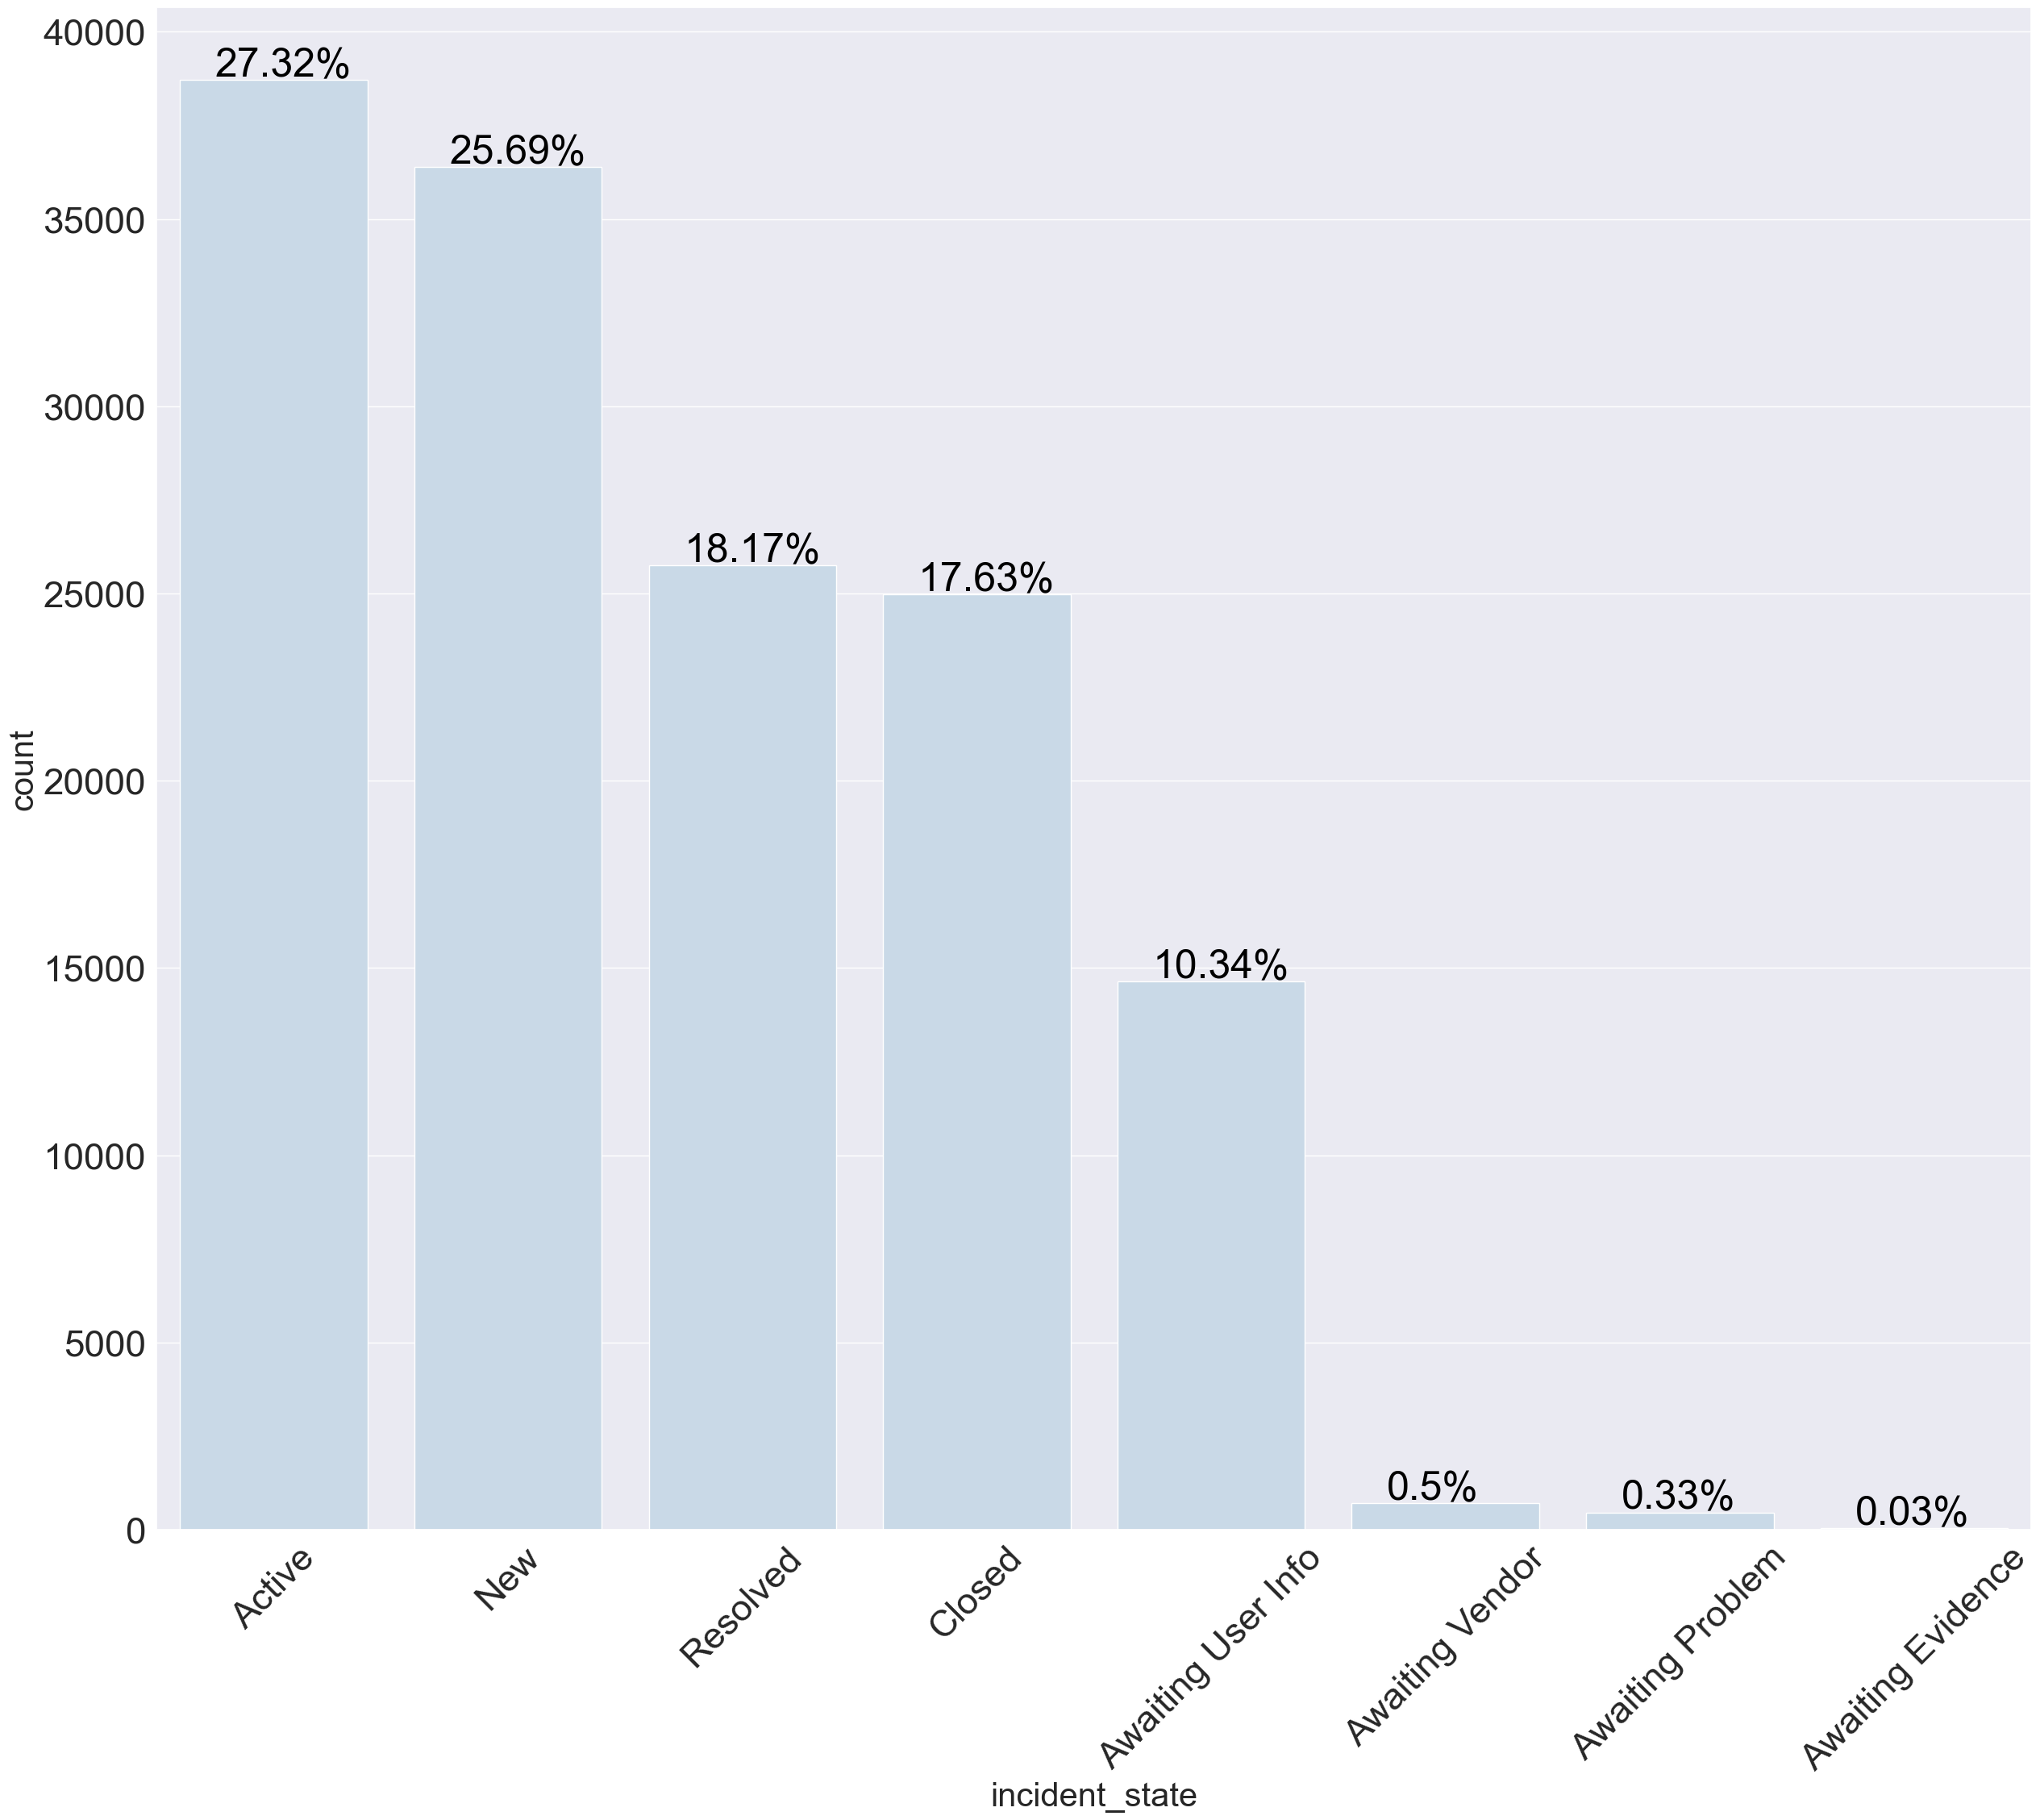

In [132]:
ascending_order = inc_eventdf['incident_state'].value_counts().sort_values(ascending=False).index
plot1 =sns.countplot(data = inc_eventdf, x = 'incident_state',order = ascending_order,color= "#c4d9ec")
plt.xticks(rotation=45)
bar_perc(plot1)

As seen above we can see there is only small distribution of tickets that are divided among the last three stages.

However if we are to observe below displayed boxplot , it is clearly visible that last three stages indeed take up a lot of time to be resolved.

As this kind of scenario happens is a very few cases and ideally on floor such cases get technical exception we will be not including it for further analysis.


Samples where state Awaiting Vendor,Awaiting Problem and Awaiting Evidence are present will tend to have longer waiting time and will need seperate analysis on what kind of issues they usually are. 

Such cases are unique and few in number but due to it unusually long resolving time , time to closure increases drastically and skews the rest of the data set towerds it. Hence for now we are keeping them aside.

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.,  600000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

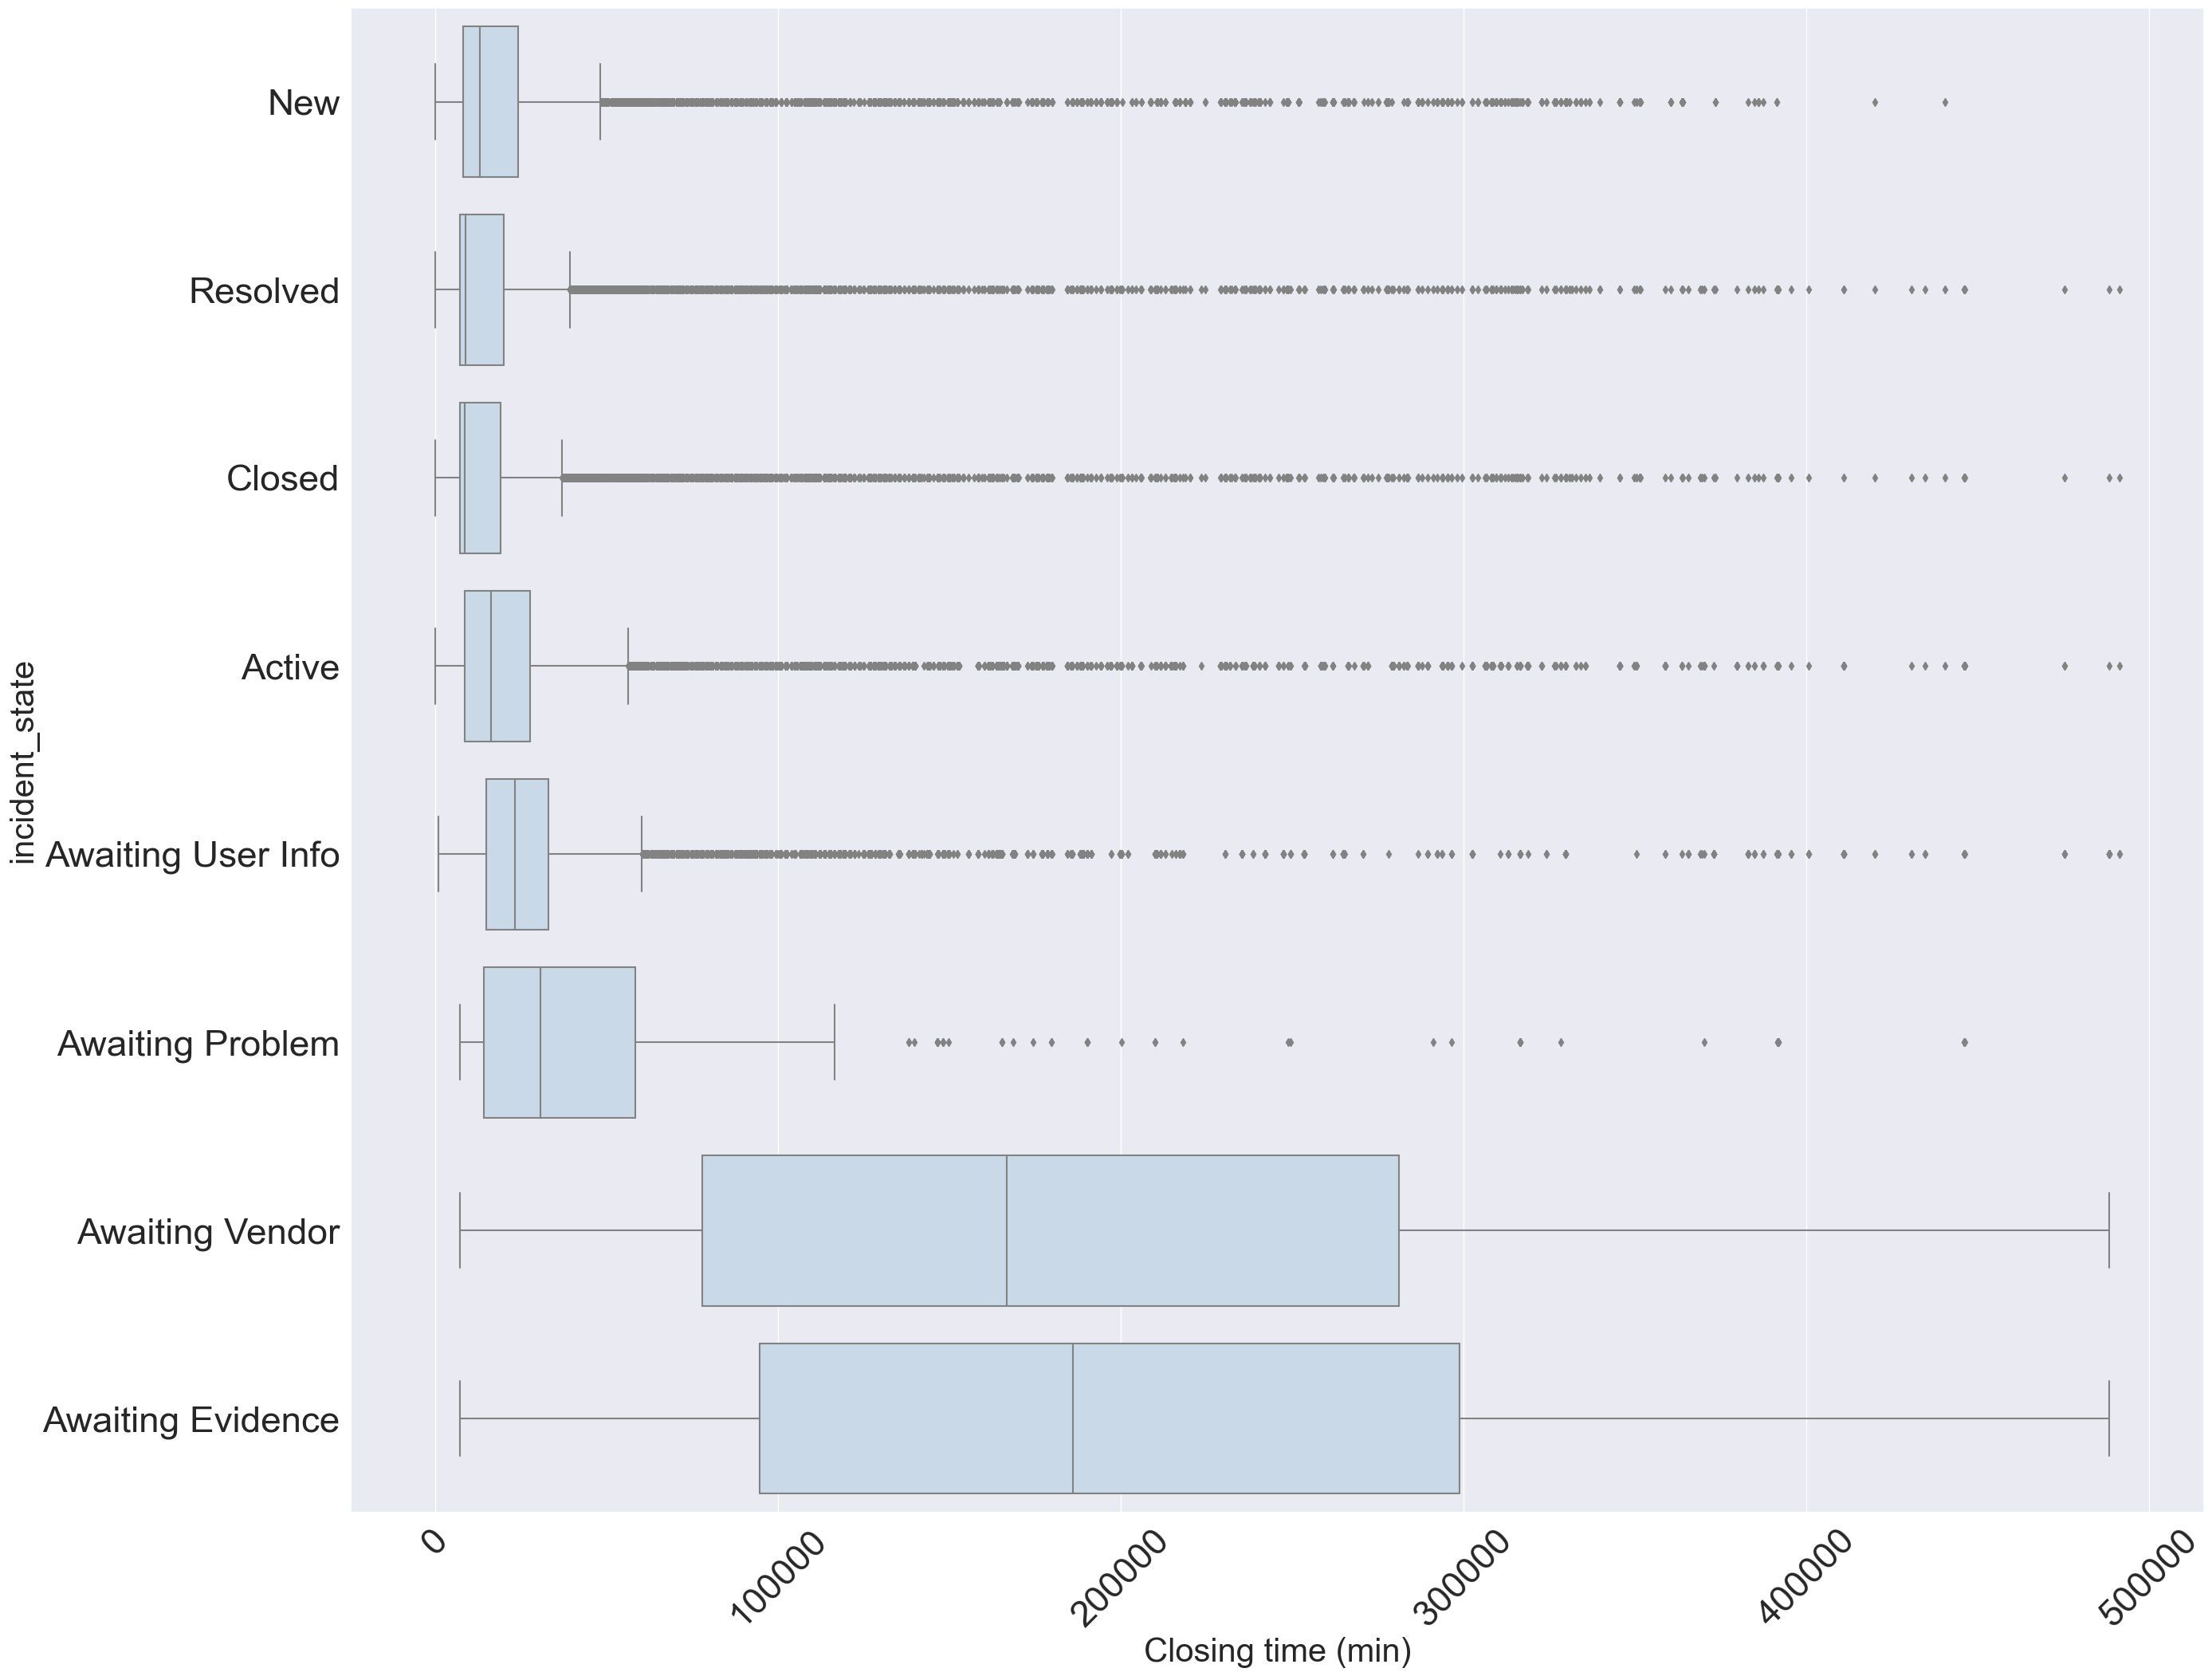

In [133]:
sns.boxplot(x ='Closing time (min)', y ='incident_state',color= "#c4d9ec", data = inc_eventdf)

plt.xticks(rotation=45)

### Removing samples with above mentioned states

In [134]:
index_1 = inc_eventdf[inc_eventdf["incident_state"]=="Awaiting Vendor"]["number"]
index_2 = inc_eventdf[inc_eventdf["incident_state"]=="Awaiting Problem"]["number"]
index_3 = inc_eventdf[inc_eventdf["incident_state"]=="Awaiting Evidence"]["number"]

drop_index = np.concatenate((index_1,index_2,index_3))

inc_eventdf = inc_eventdf[~inc_eventdf.number.isin(drop_index)]

inc_closed = inc_closed[~inc_closed.number.isin(drop_index)]

### Updated distribution with regards to incident state.

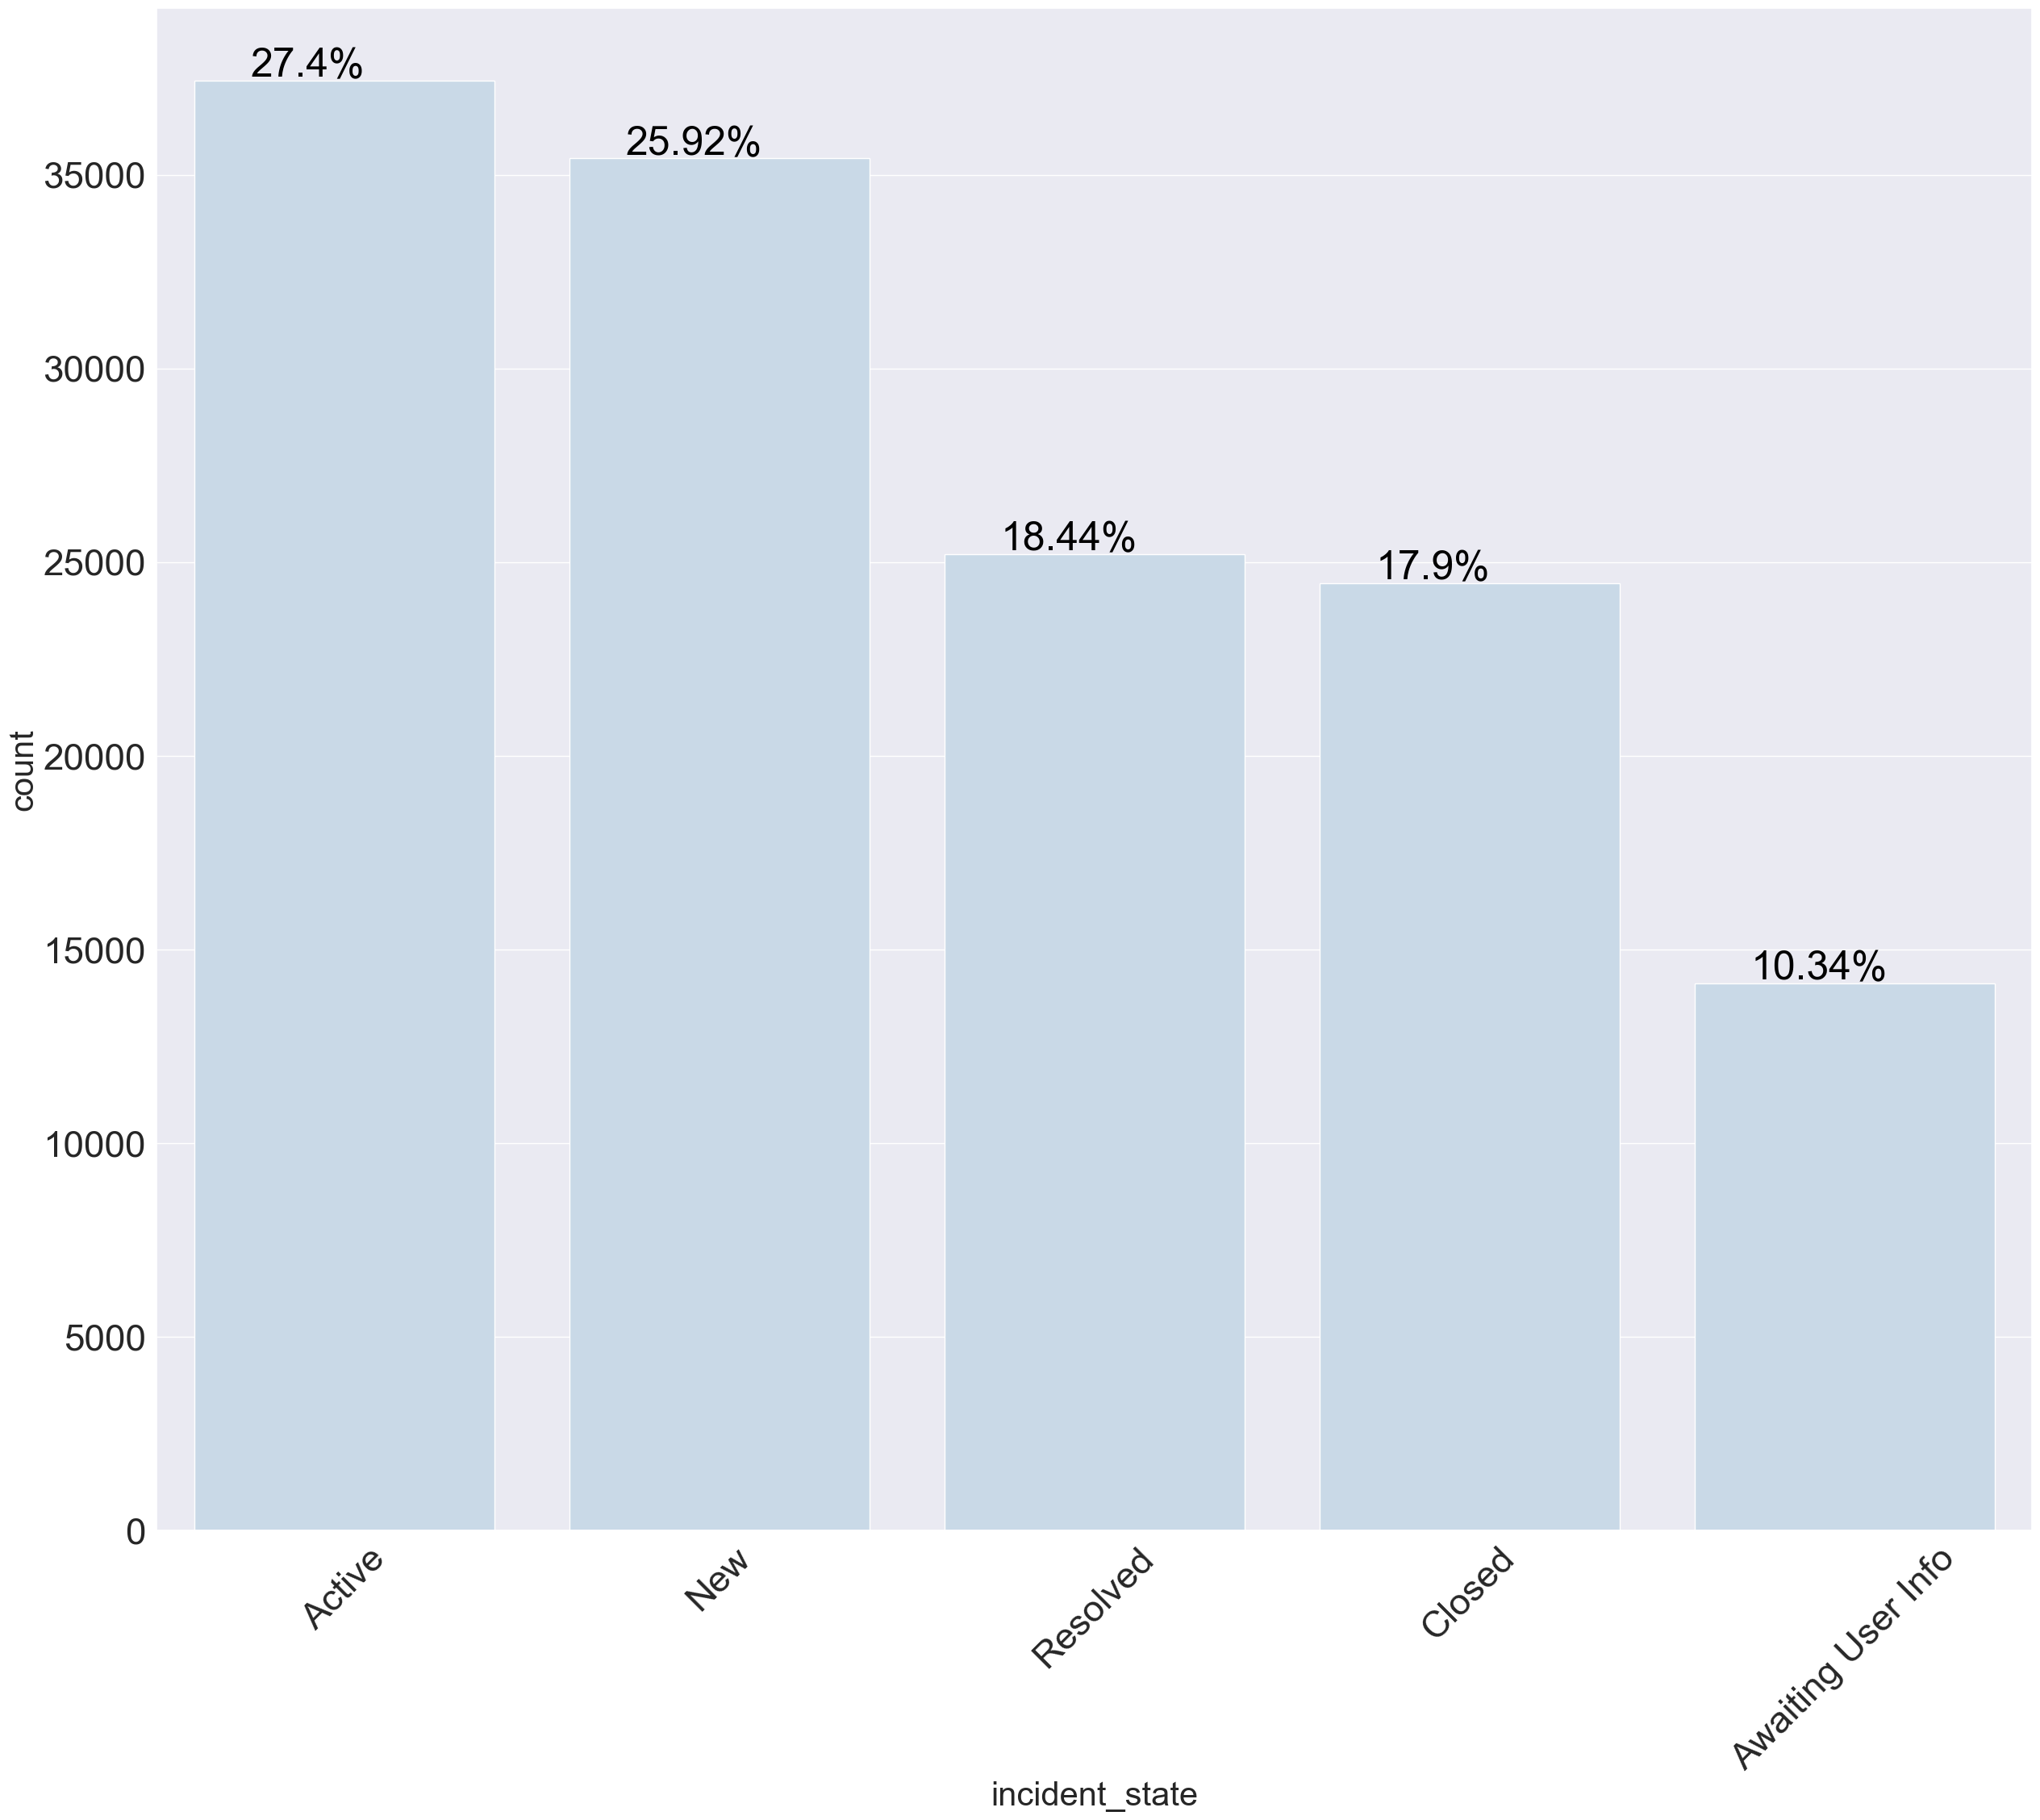

In [135]:
ascending_order = inc_eventdf['incident_state'].value_counts().sort_values(ascending=False).index
plot1 =sns.countplot(data = inc_eventdf, x = 'incident_state',order = ascending_order,color= "#c4d9ec")
plt.xticks(rotation=45)
bar_perc(plot1)

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.,  600000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

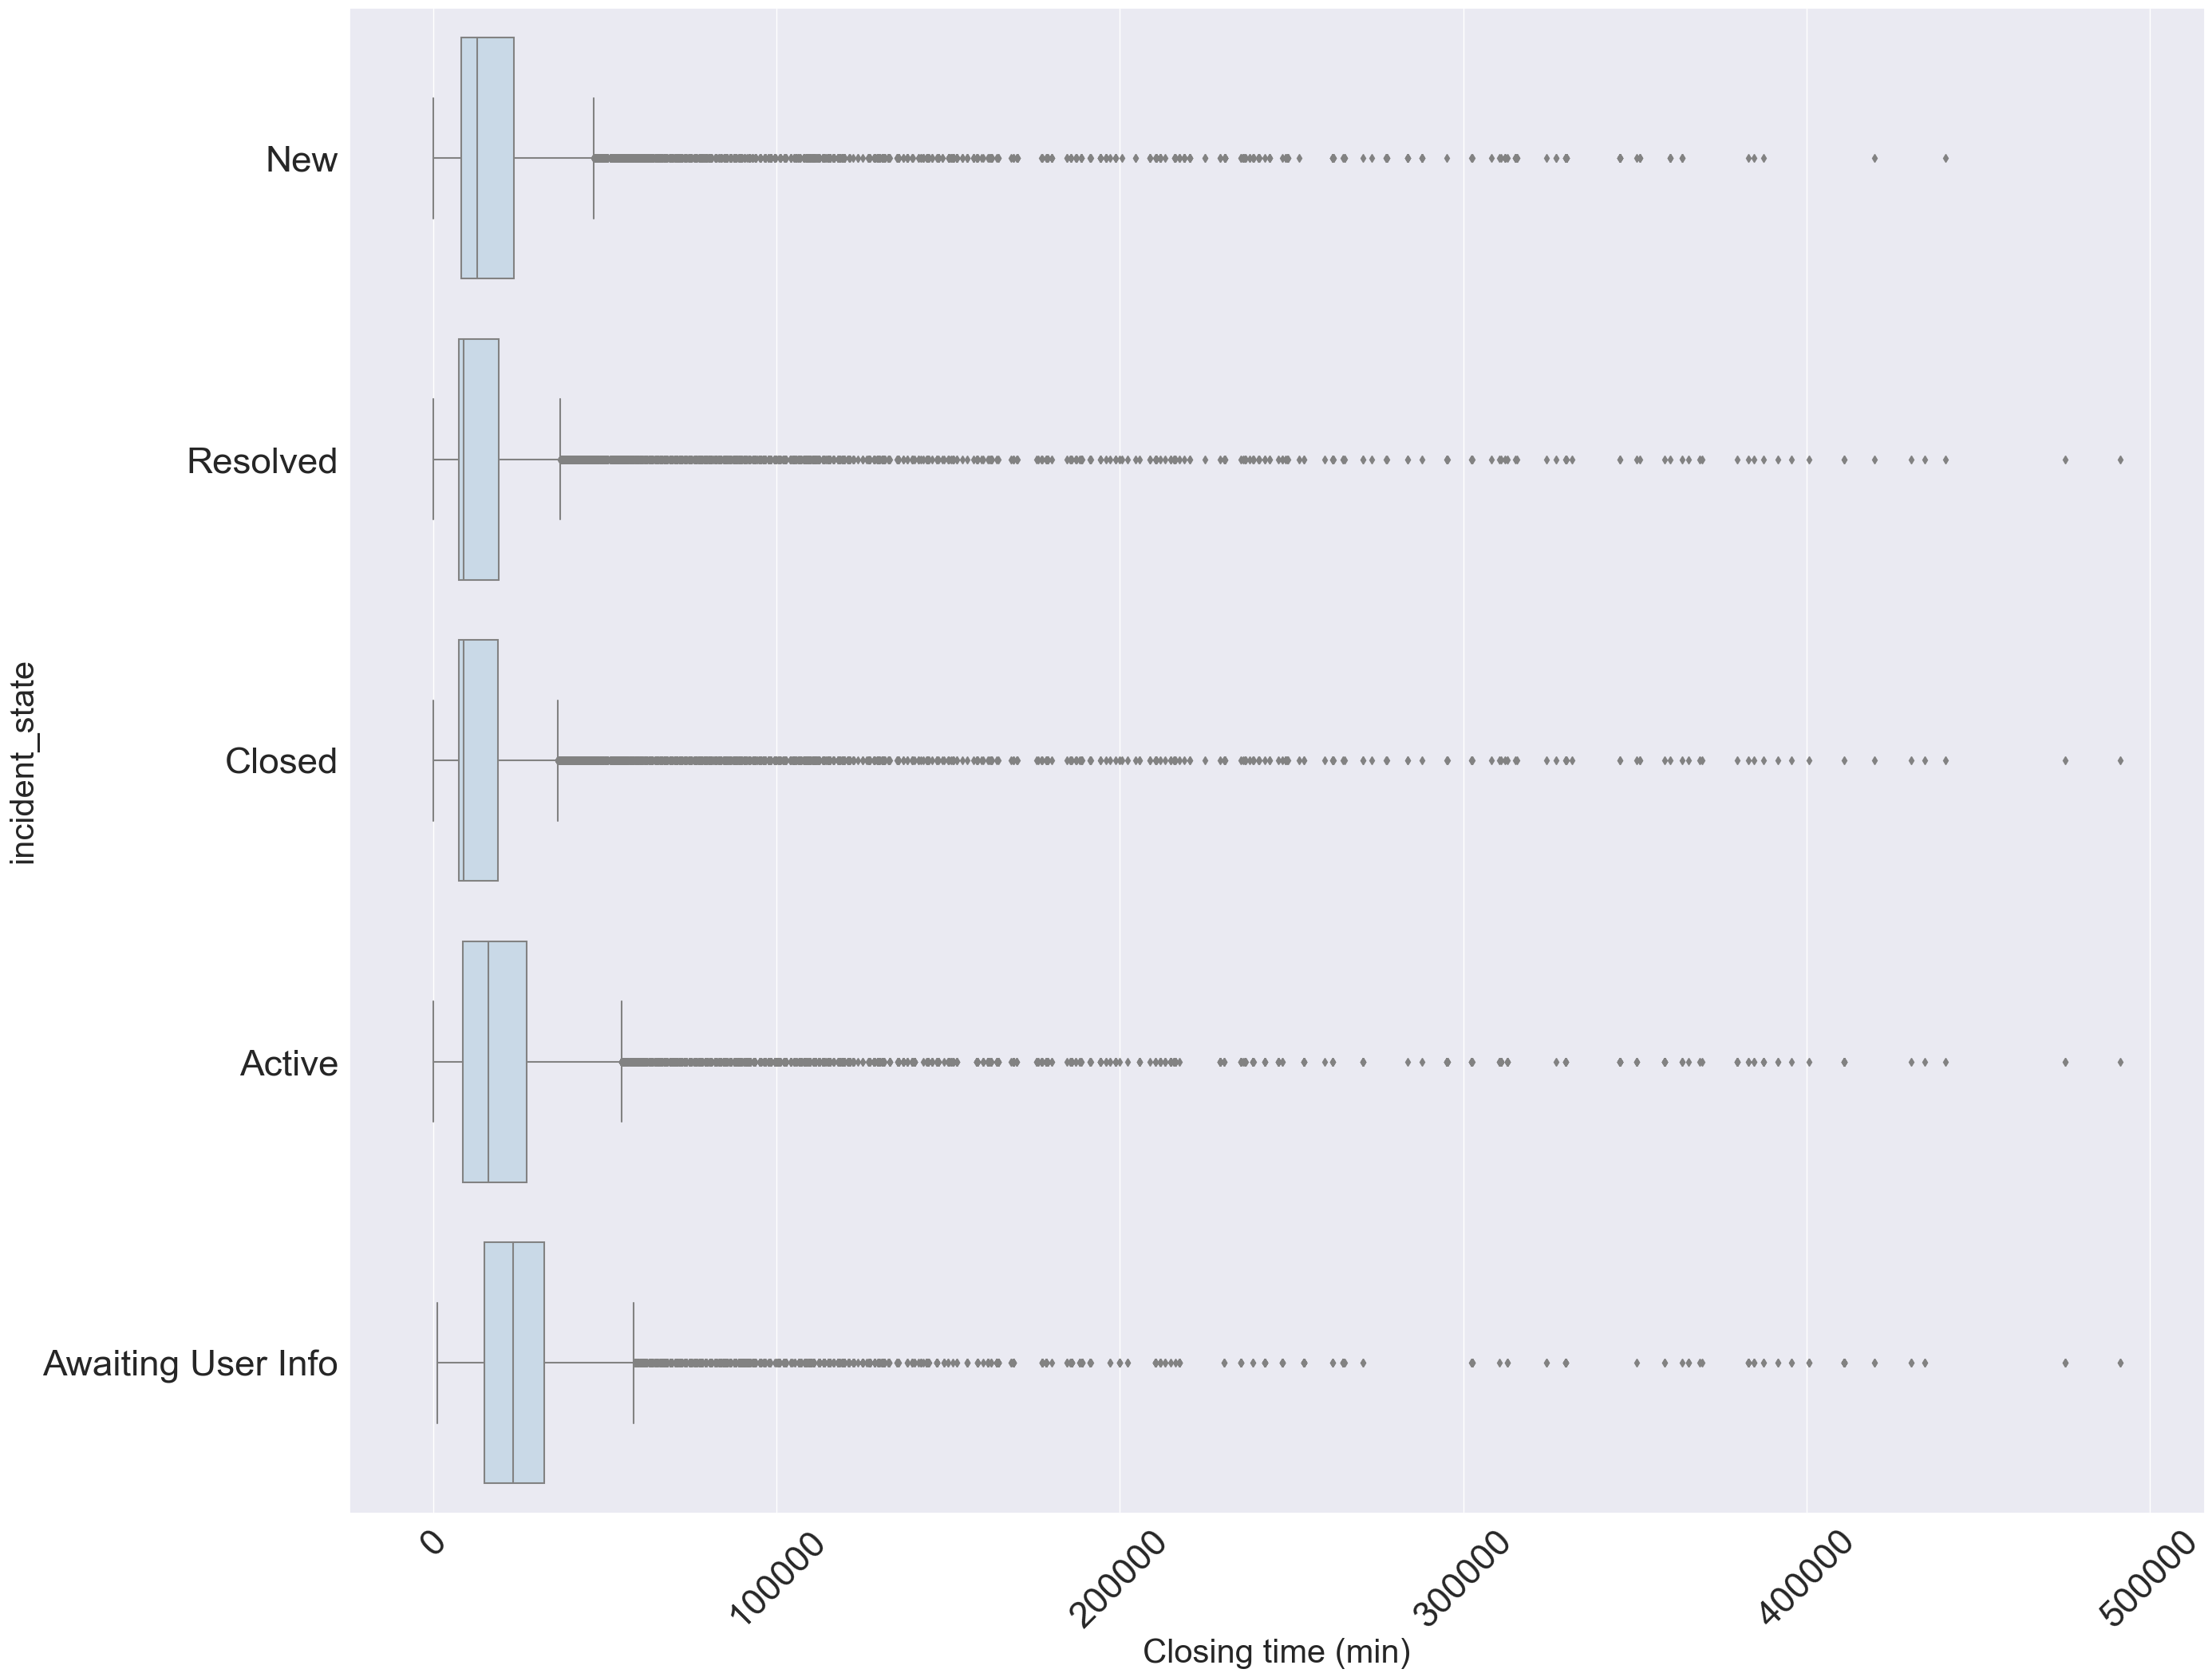

In [136]:
sns.boxplot(x ='Closing time (min)', y ='incident_state',color= "#c4d9ec", data = inc_eventdf)

plt.xticks(rotation=45)

Moving on, checking the data further based on other variables we found below mentioned information.


>                             Impact
Data is distributed into three parts '1 - High','2 - Medium' and '3 - Low '.
Here the distribution 2-Medium is the major contributers of tickets with 95.46% of dataset under it.

>                           Contact Type
User contact is divided among 'Phone','Self service','Email', and 'Direct opening ' however "Phone" is the preffered way of user contact.
Decreasing distribution of tickets from 99.16 and creating oppertunity with email and self service should ideally give some respite to the service agent,
improving the over all efficiency of the environment.


>                            Urgency & Priority 
These both variable go hand in hand based on the sitution and are some time changed based on agents understanding of the issue. And is appropriatly distributed.




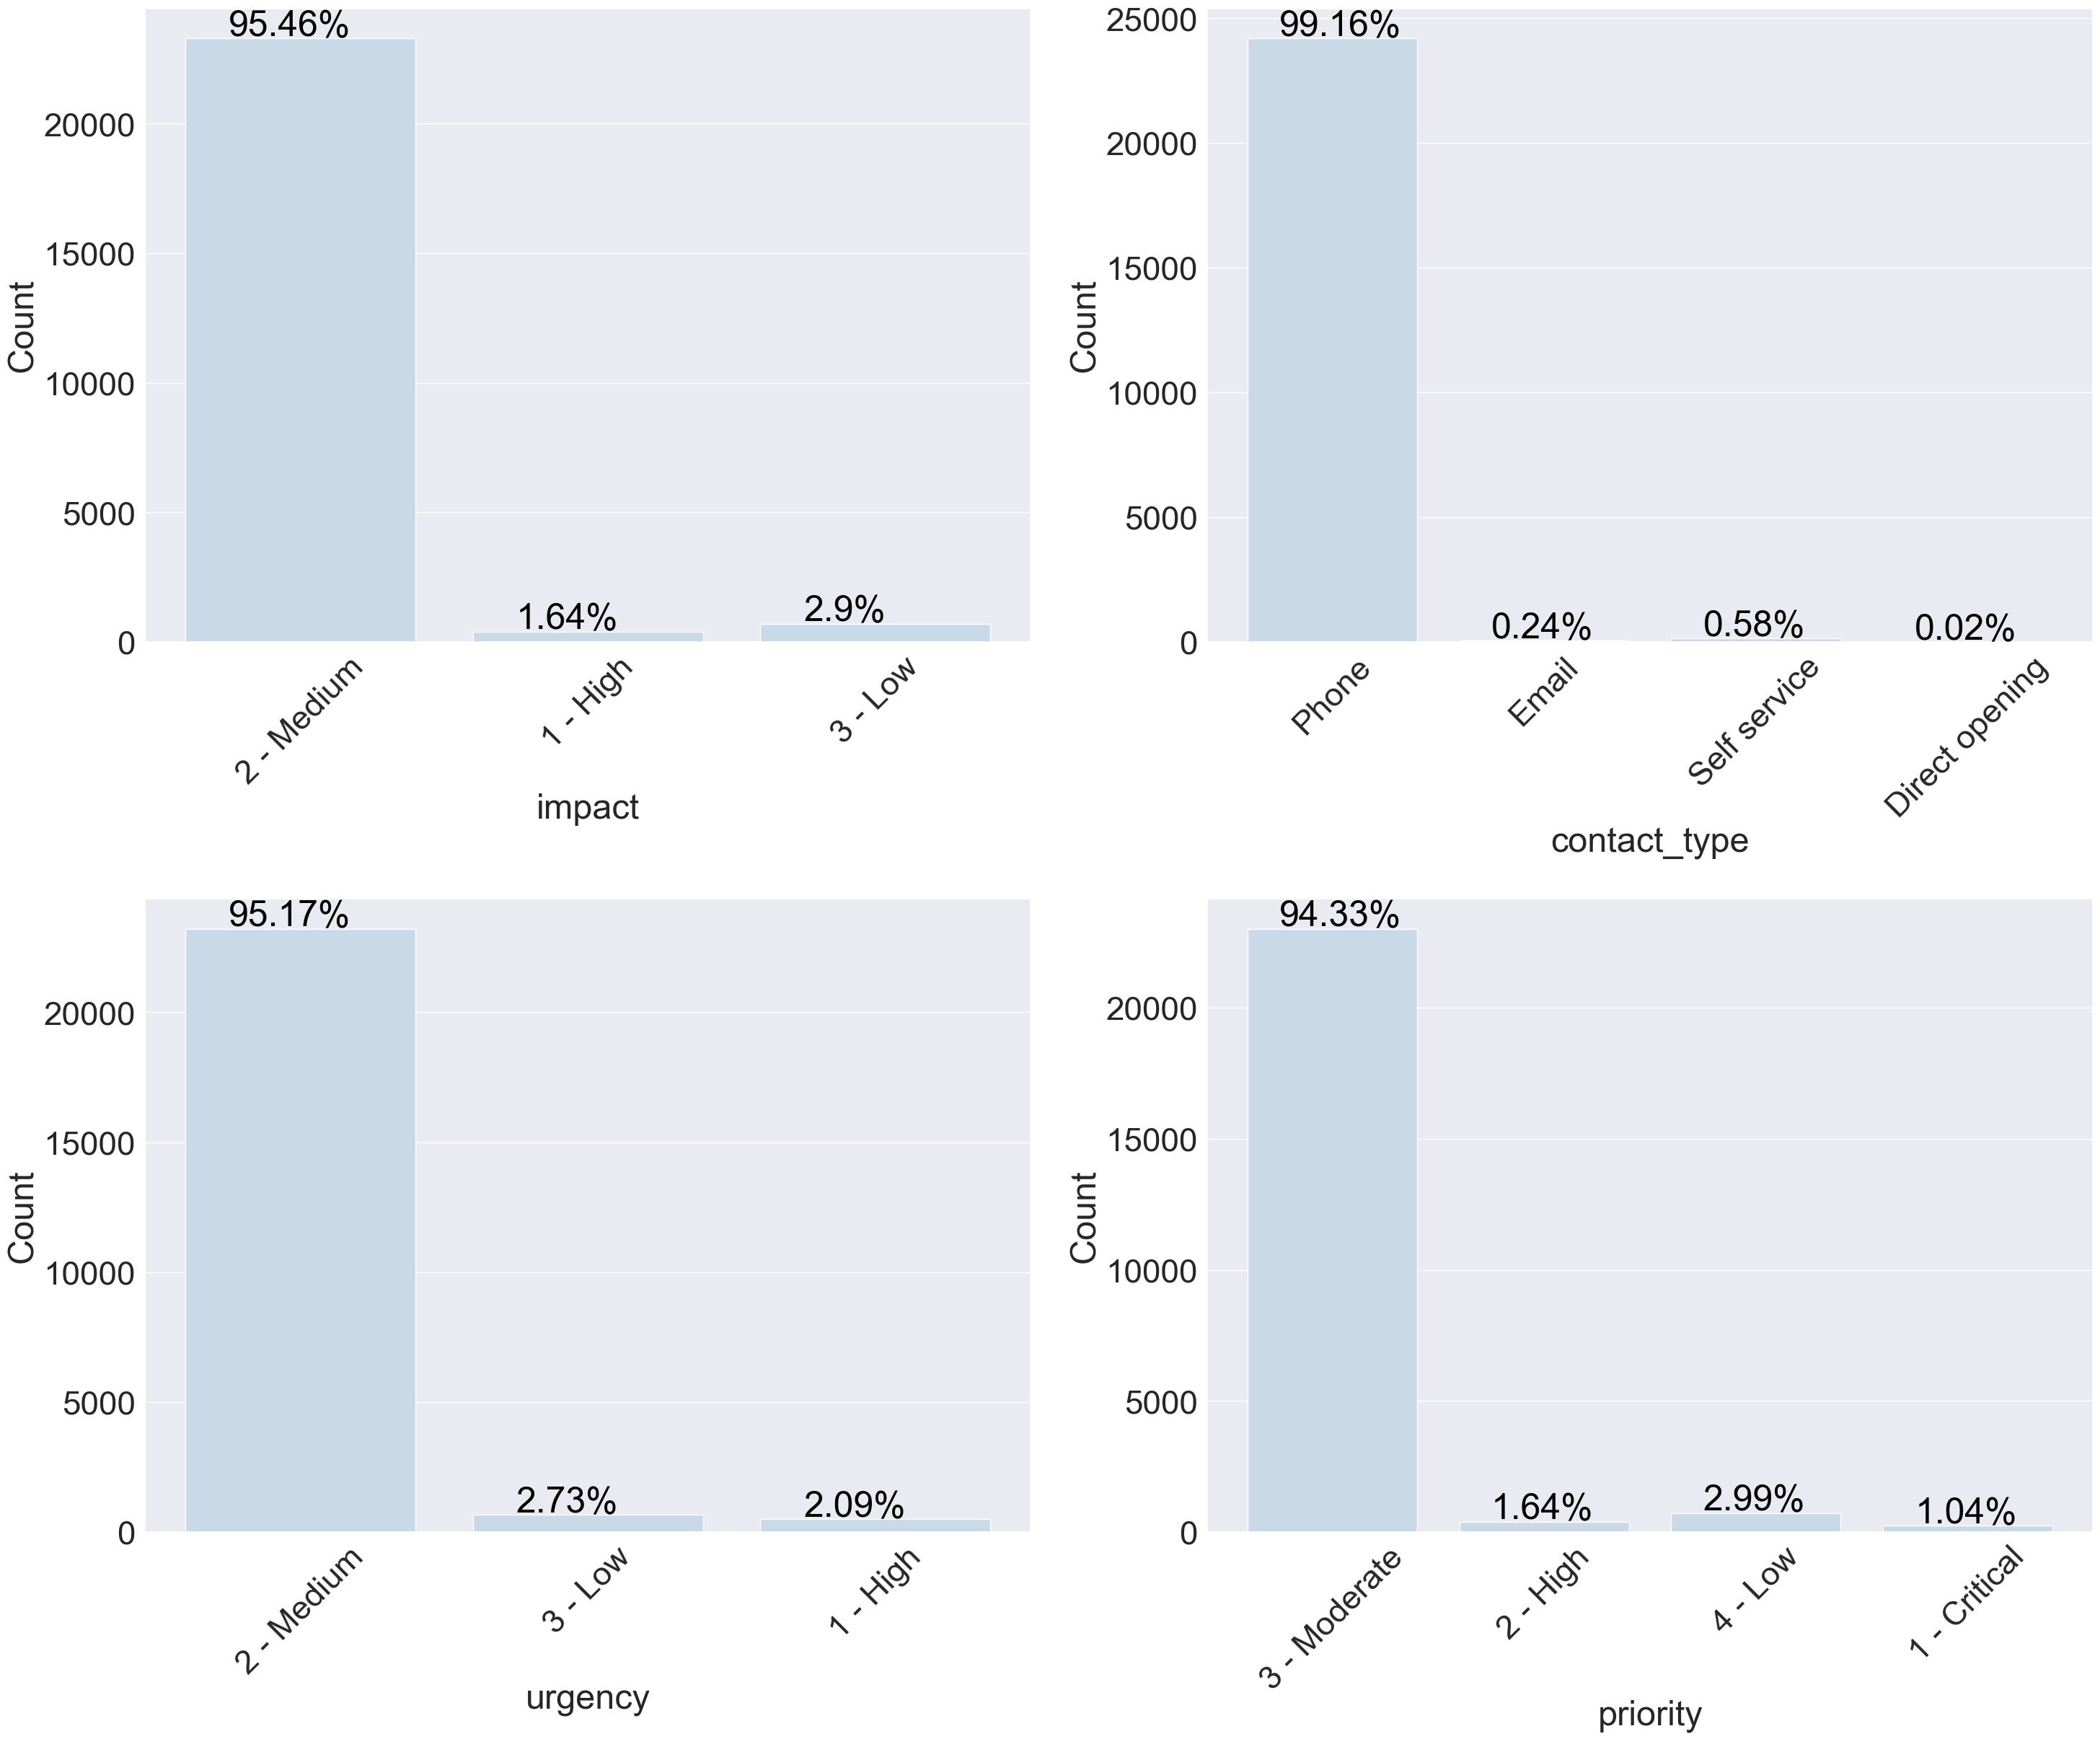

In [137]:
colname = ['impact','contact_type','urgency','priority']
order_list =[['1 - High','2 - Medium','3 - Low '],['Phone','Self service','Email','Direct opening '],['1 - High','2 - Medium','3 - Low '],['1 - Critical','2 - High','3 - Moderate','4 - Low']]


for i,j in enumerate(colname):
    plt.subplot(2,2,i+1)
    
    ax= sns.countplot(data = inc_closed, x = j,color= "#c4d9ec") ##,order = order_list[i] (if this is added there is error)
    plt.ylabel("Count",fontsize=35)  
    plt.xlabel((j),fontsize=35) 
    plt.xticks(rotation=45)
   
    plt.margins(0.05)
    bar_perc(ax)

plt.tight_layout()

Below set of plots defines service agents performace which is directly proportional to project performance as this contributes to efficient flow of ticket and decrease unnecessary false movement of ticket from one team to another.


>                        Knowledge Base
Creating a proper knowledge base increases FCR(First call response) as majority of the issues are always Priority 3 and 2-medium tickets there will most likely be repeated issues with similar solution. Solution for a particular issue that has already been solved need to logged and documented for future use so that in case such issue occurs article will be readily available, hence reducing time to close which will subsequently improve the performance.


>                          MADE SLA
SLA(Service Level agreement) needs to be met each time ideally however that is almost never the case as there is always some component that causes this issue, like user unavailablity, or vendor availability and henceforth. Below plot shows 64.41% of the tickets have been closed with in SLA time , still 35.59% of the tickets did not which should be much lower. Need for process improvment is apparent here.

>                          User Priority Confirmation
As from the user percpective all issue needed to be looked in at at most urgency, however that is not always the case, some of the issues do always have higher priorities as it might cause environment wide issues, and similar is true for is user put issue that need urgent attention under lower priority. hence this almost always needs to be confirmed from user. 76.62% is sufficient but could be improved further.

>                                 Notify
However this is a small part in the ITIL process this is needed so that all the stackholders are informed about the issues in the environment and are on standby for any assisatnce to resolve the issue as soon as possible. ideally important for priority 1 and priority 2 issues.


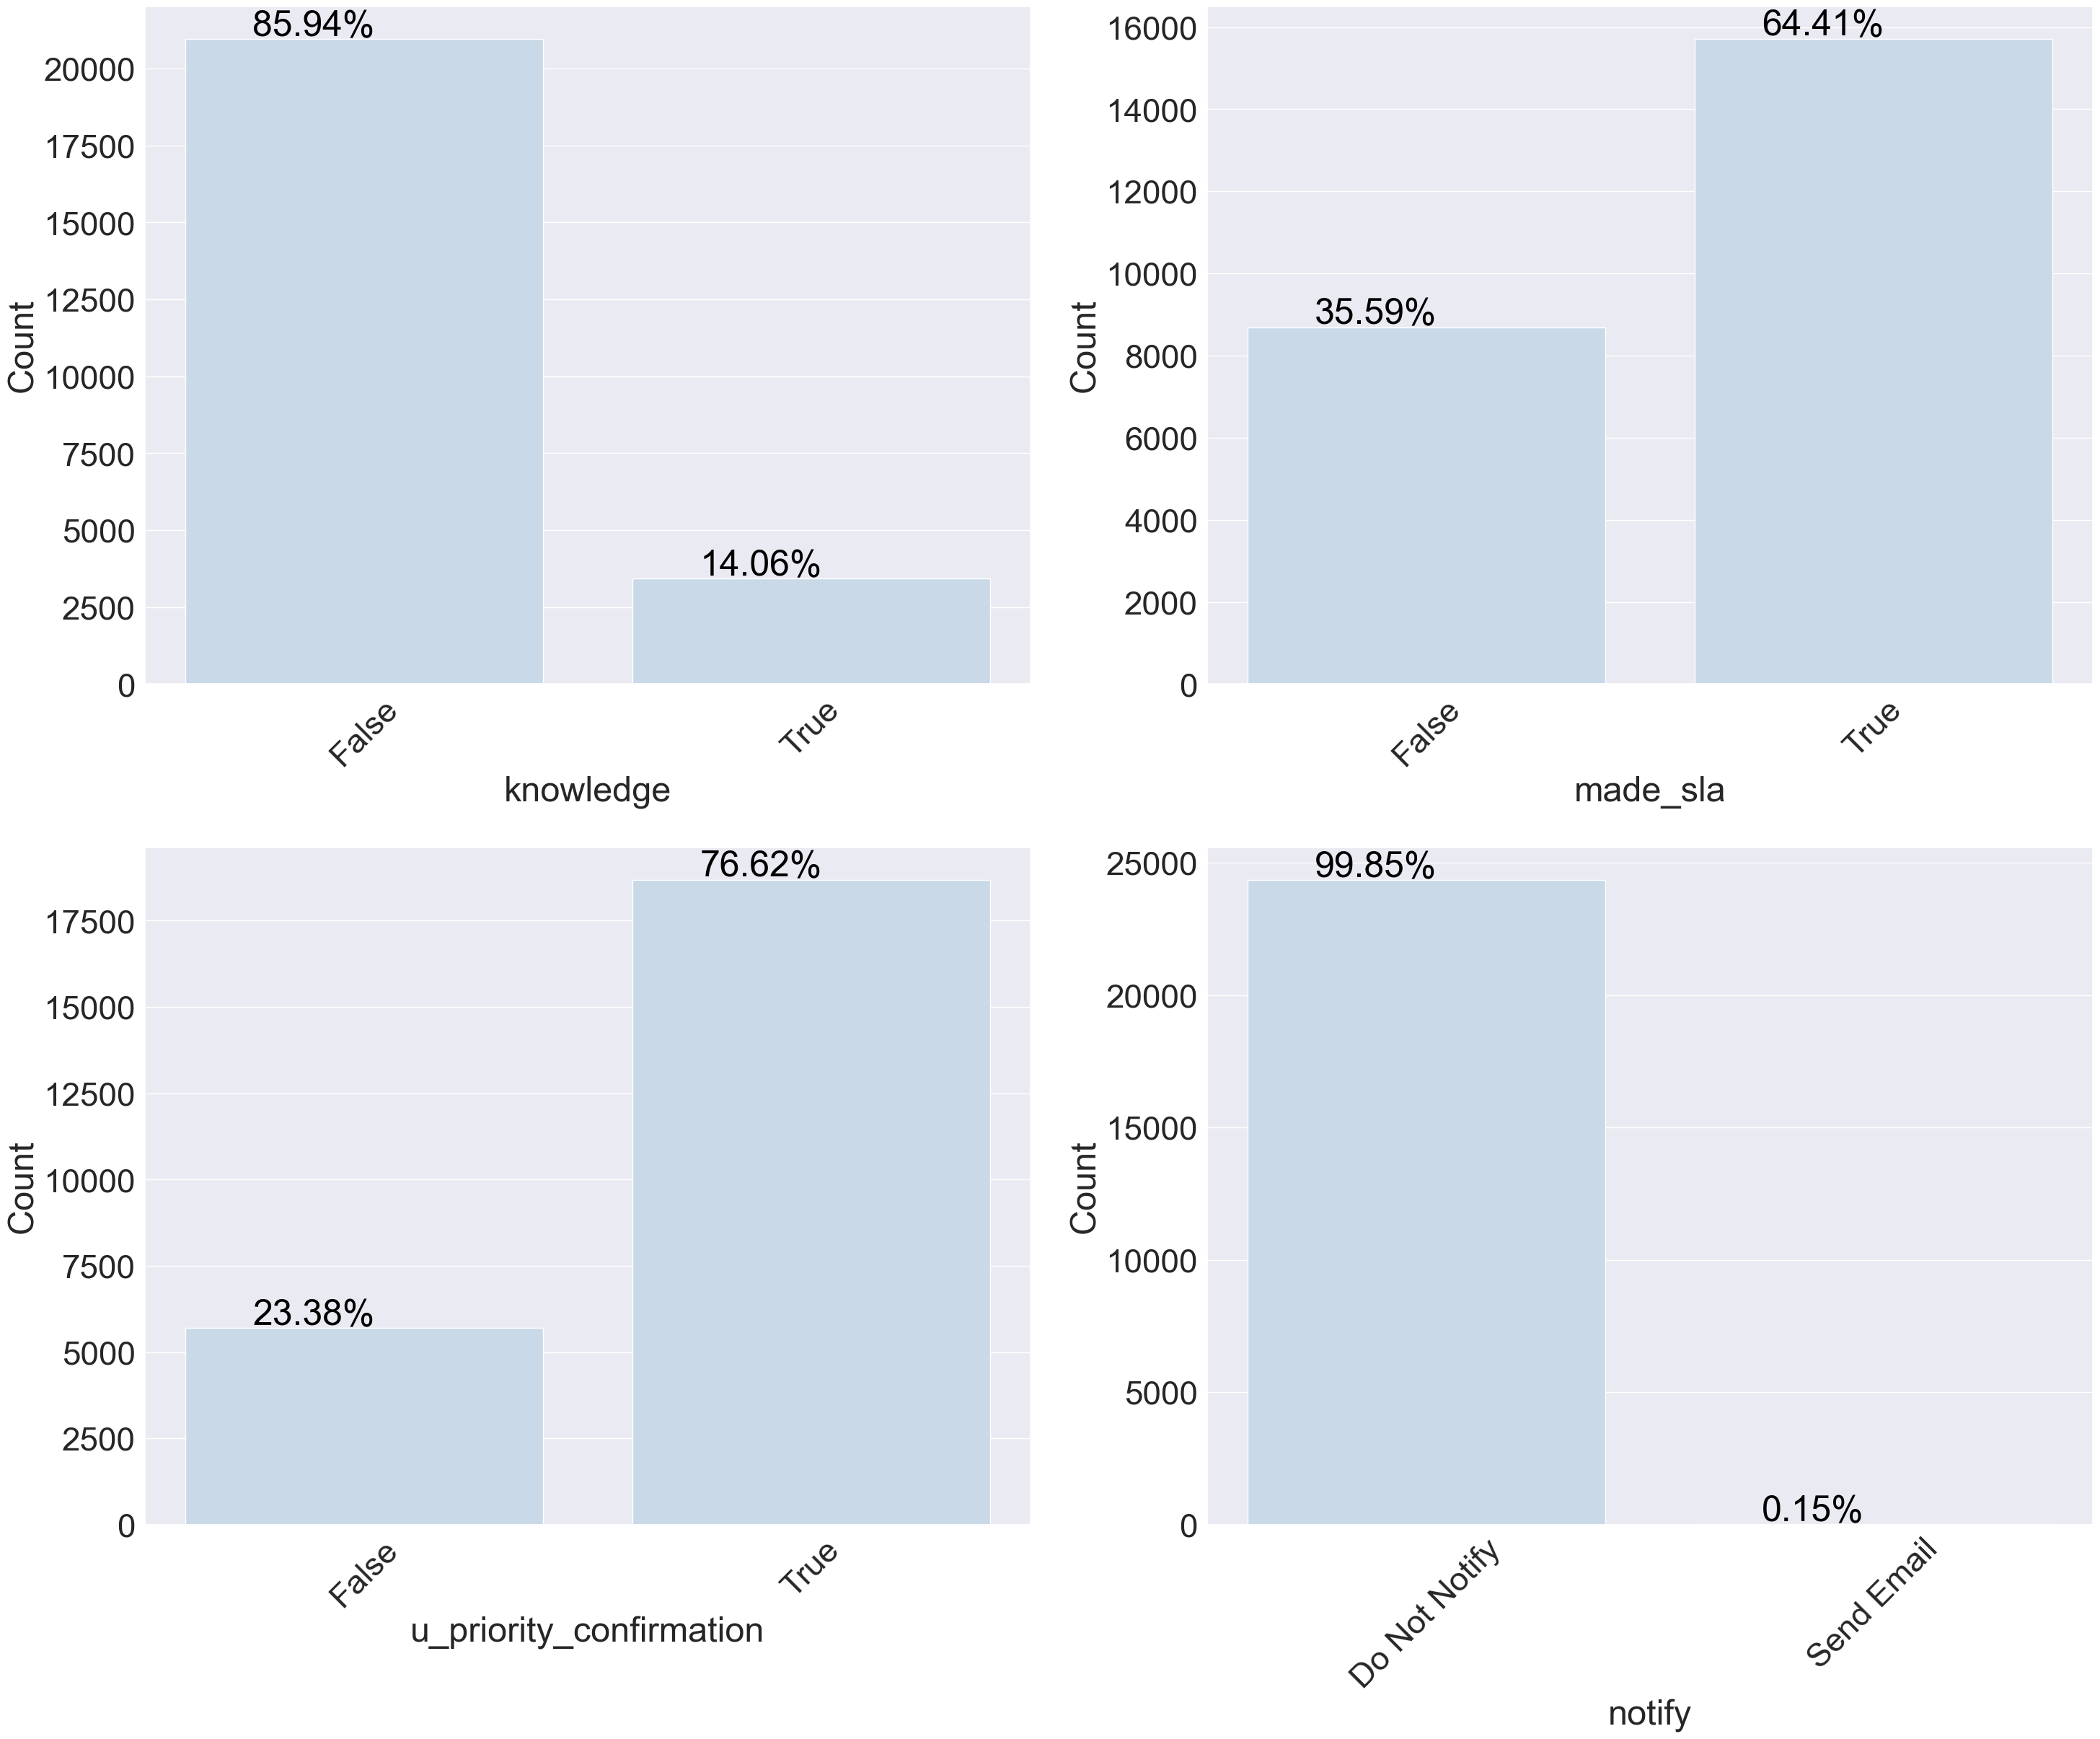

In [138]:
colname = ['knowledge','made_sla','u_priority_confirmation','notify']


for i,j in enumerate(colname):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(data = inc_closed, x = j,color= "#c4d9ec")
    bar_perc(ax)
    plt.ylabel("Count",fontsize=35)  
    plt.xlabel((j),fontsize=35) 
    plt.xticks(rotation=45)
    
    plt.margins(0.05)

plt.tight_layout()



### Ticket volume based on the time of the day

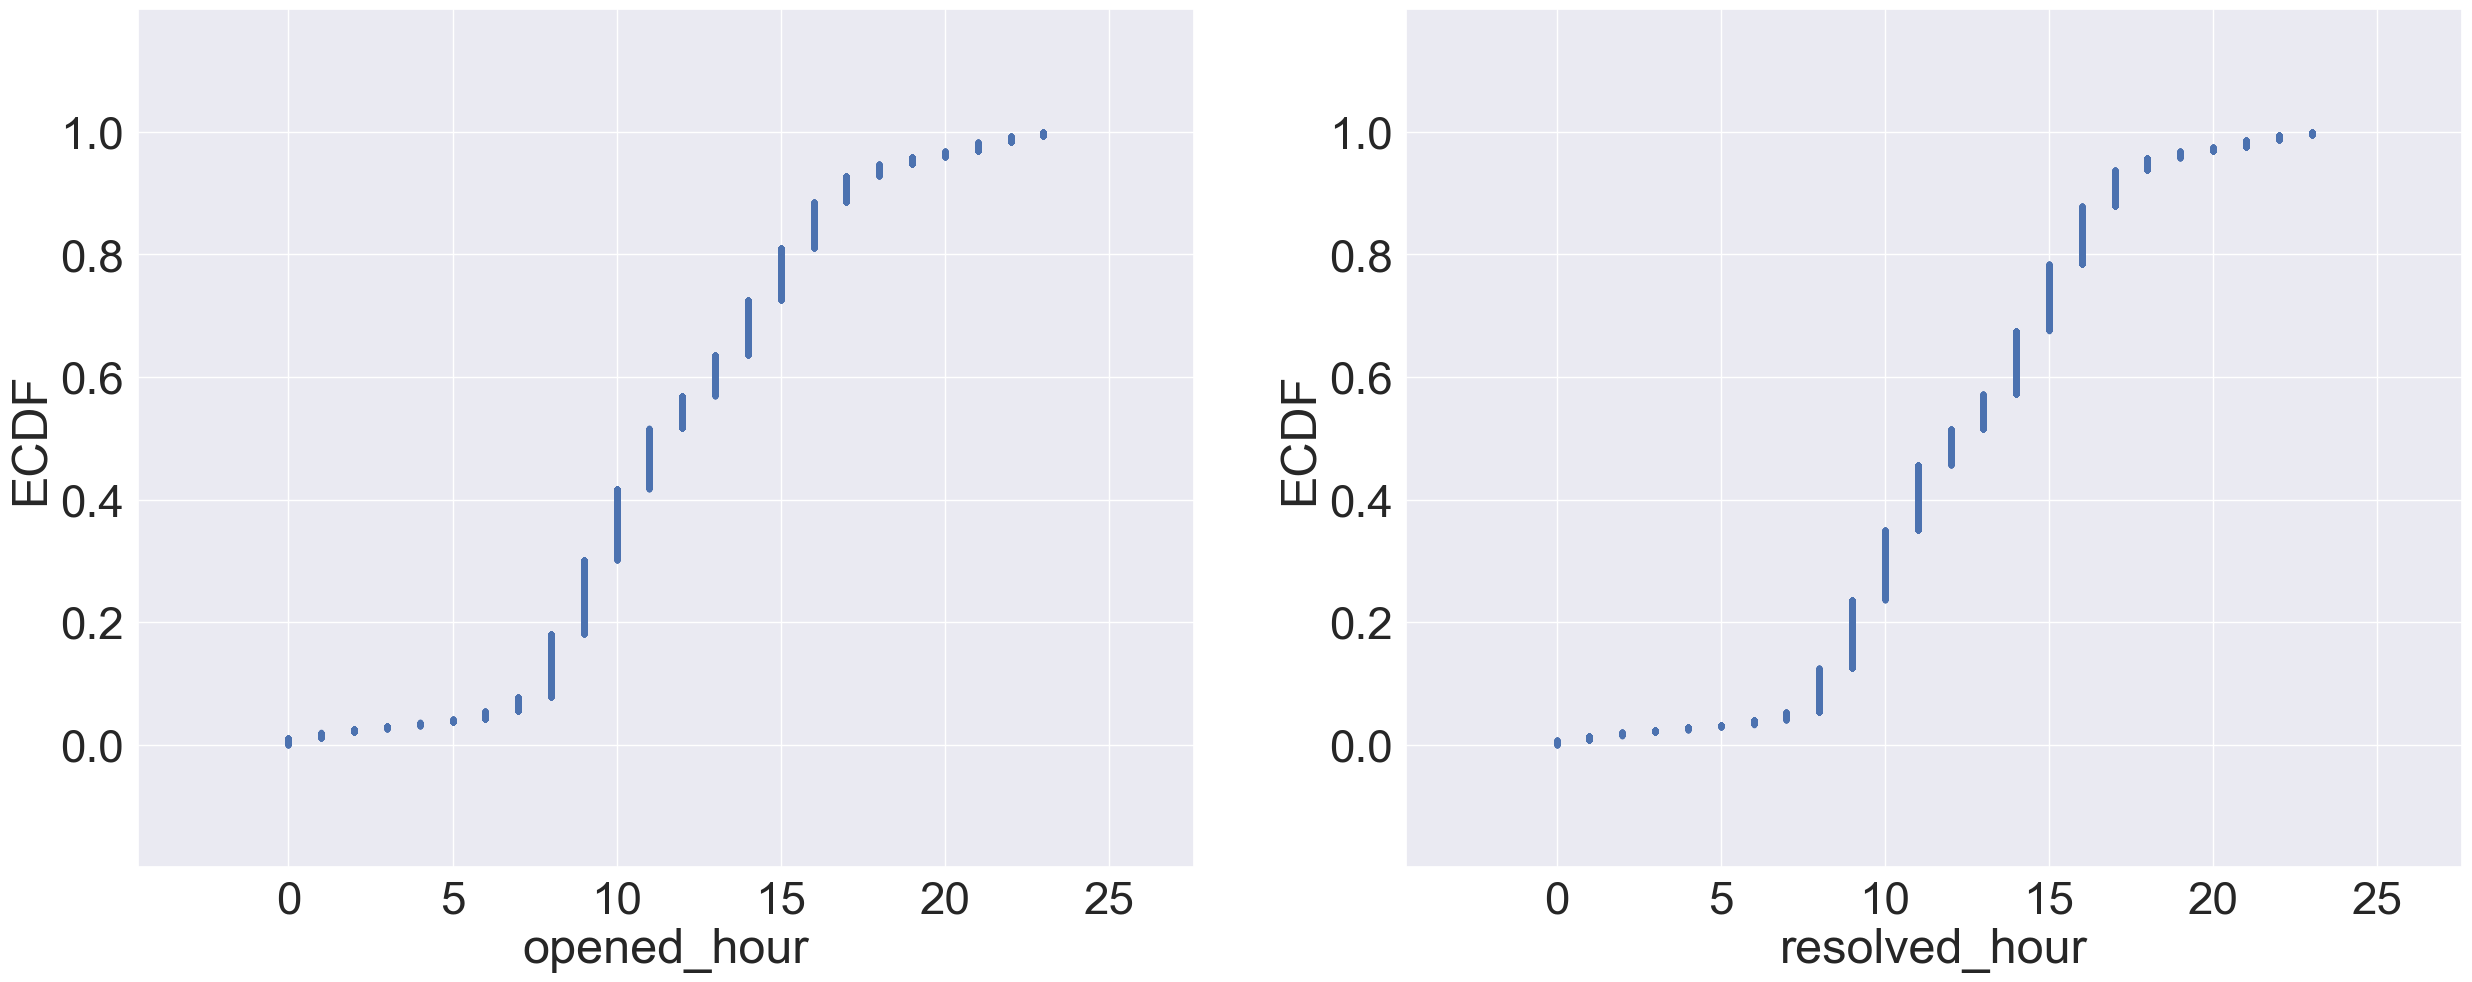

In [139]:
inc_closed['opened_hour']= inc_closed.opened_at.dt.hour
inc_closed['resolved_hour']= inc_closed.resolved_at.dt.hour

colname =['opened_hour','resolved_hour']
ecdf_plot(colname)

From the above polts we can see that almsot 80% tickets are both opened and resolved from 9 in the morning to 4 in the evening. 

## Top 10 Categories with most number of incidents

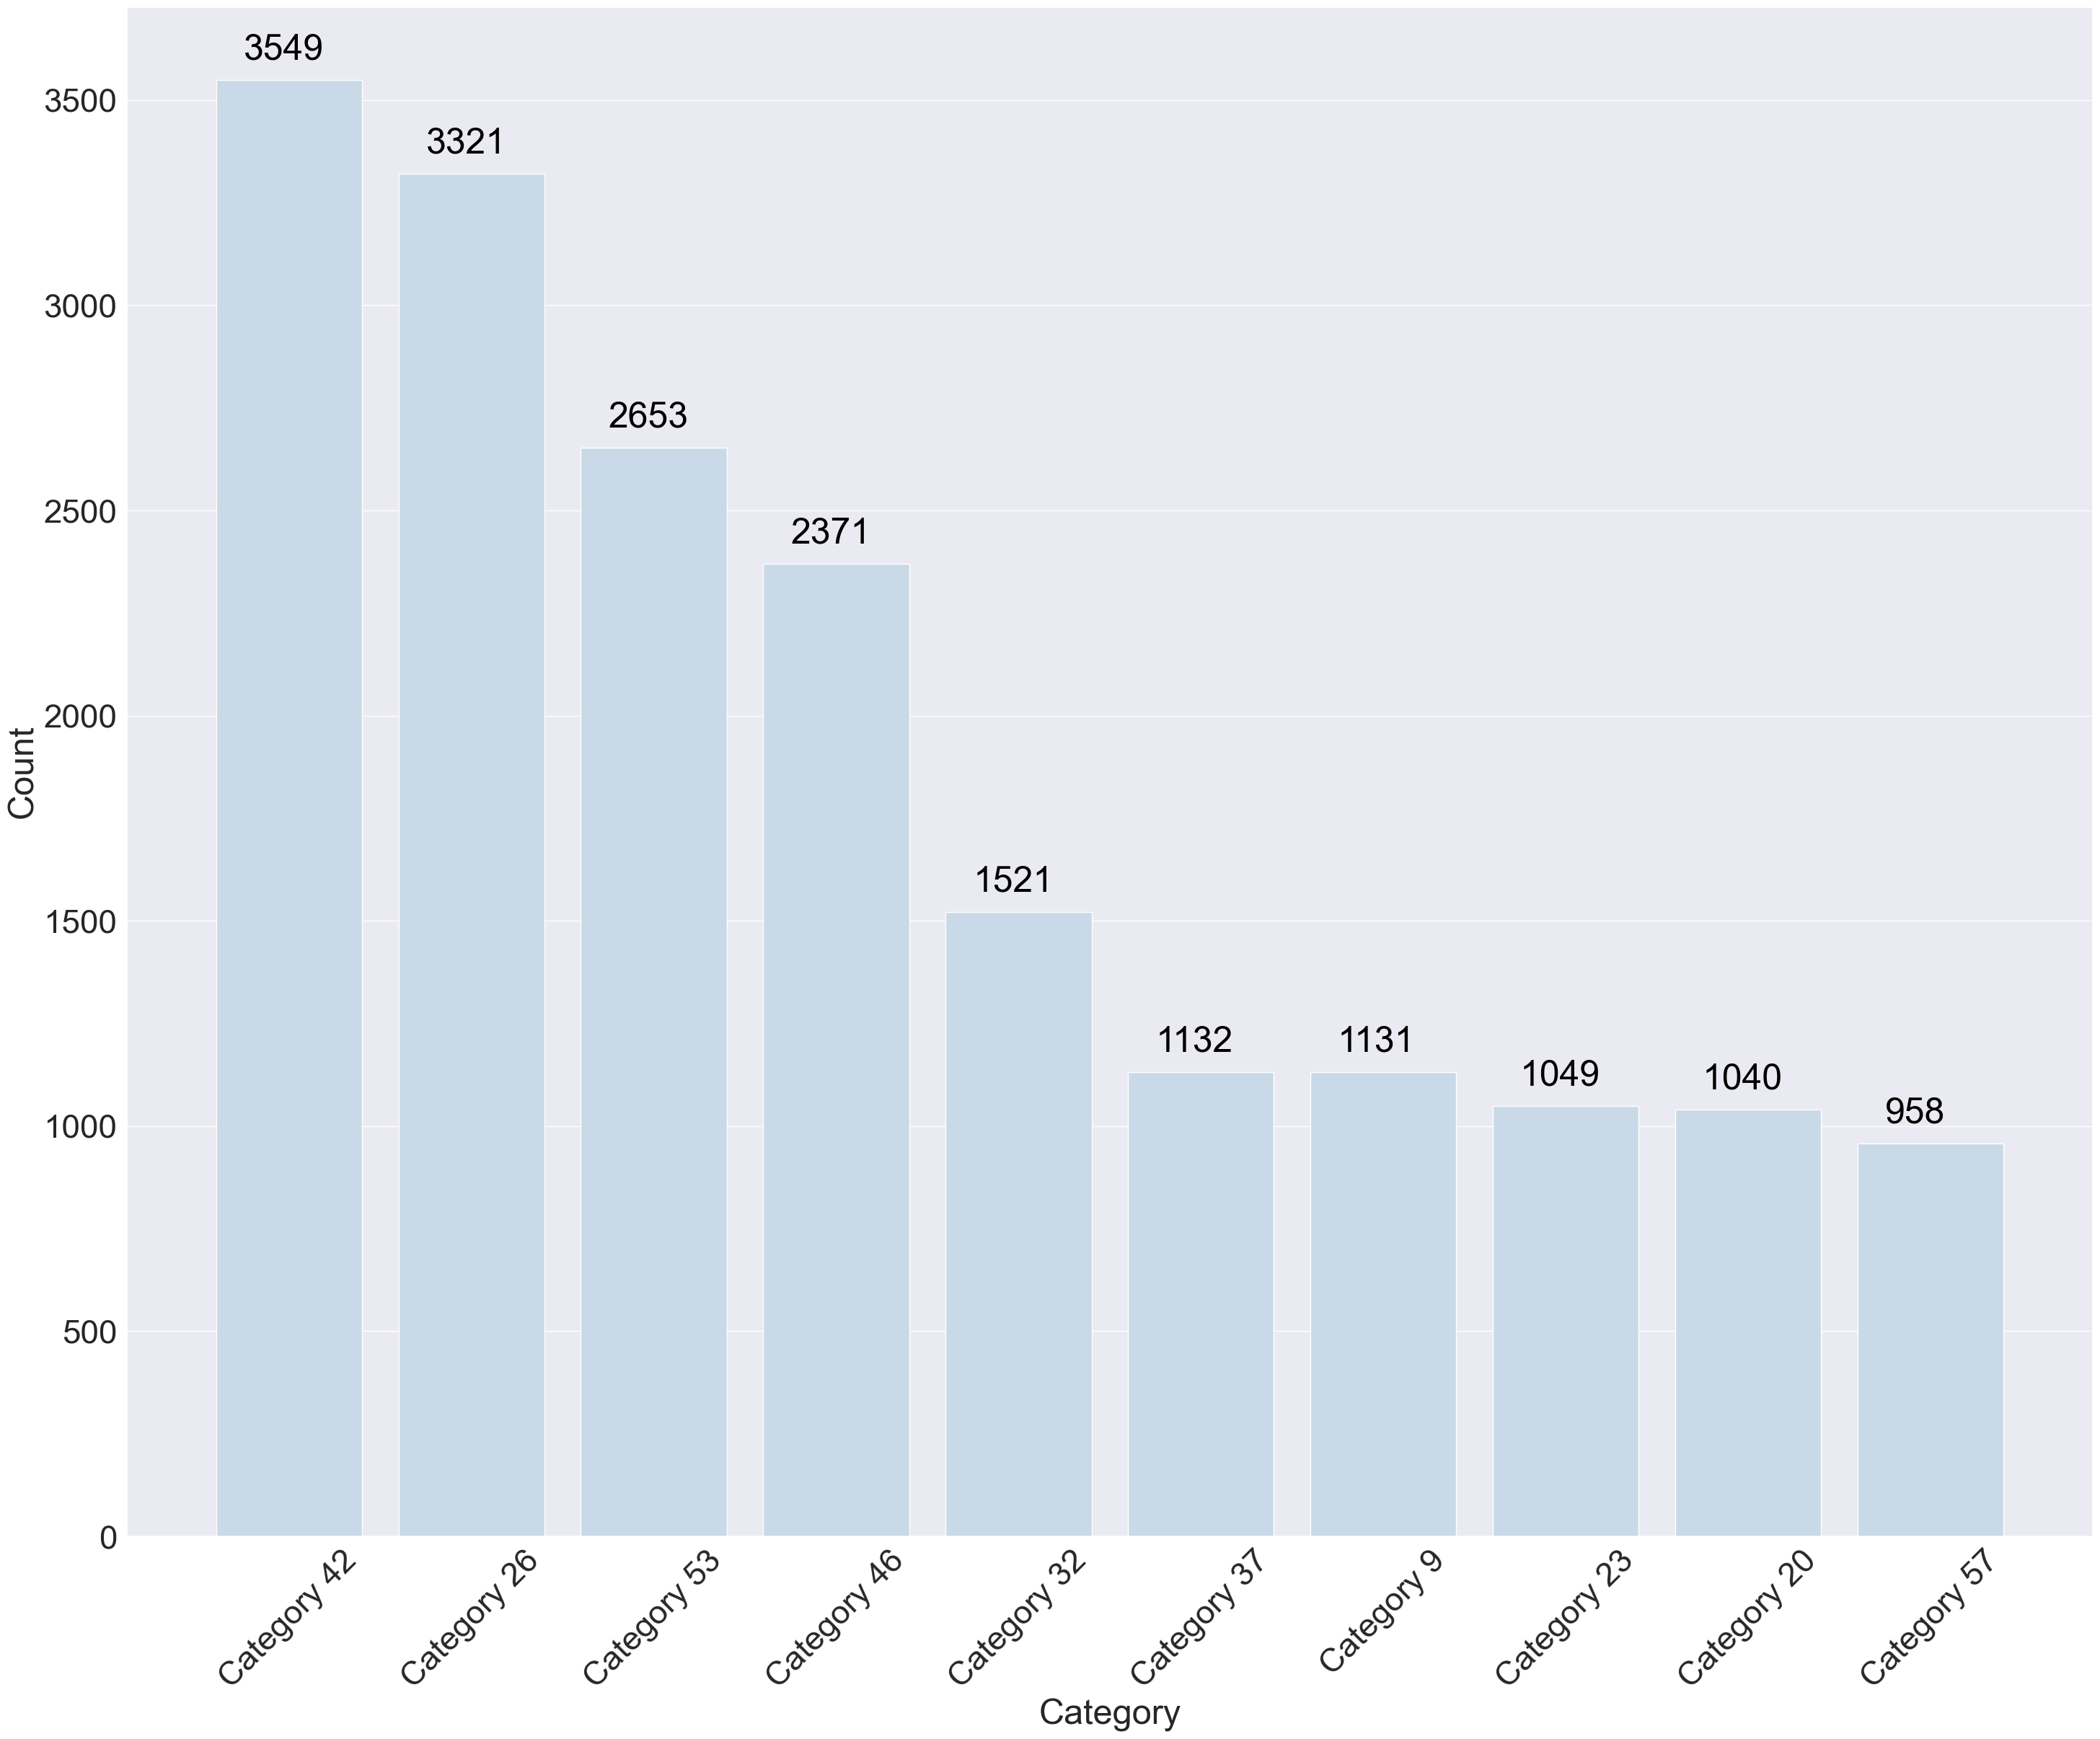

In [140]:
ax =sns.countplot(data = inc_closed, x = "category",color= "#c4d9ec",order=inc_closed["category"].value_counts()[:10].index)
plt.ylabel("Count",fontsize=35)  
plt.xlabel("Category",fontsize=35)
plt.xticks(rotation=45)
plt.margins(0.05)
bar_count(ax)
plt.tight_layout()

Above plot shows the top 10 category which recieves most number of incidents, this information can be used to focus attention towards them and provide better solutions so that they do not reoccur and in case they do a proper knowledge base needs to be created so that they can be resolved as soon as possible.

## Below plot shows the Closing time on above top 10 category.

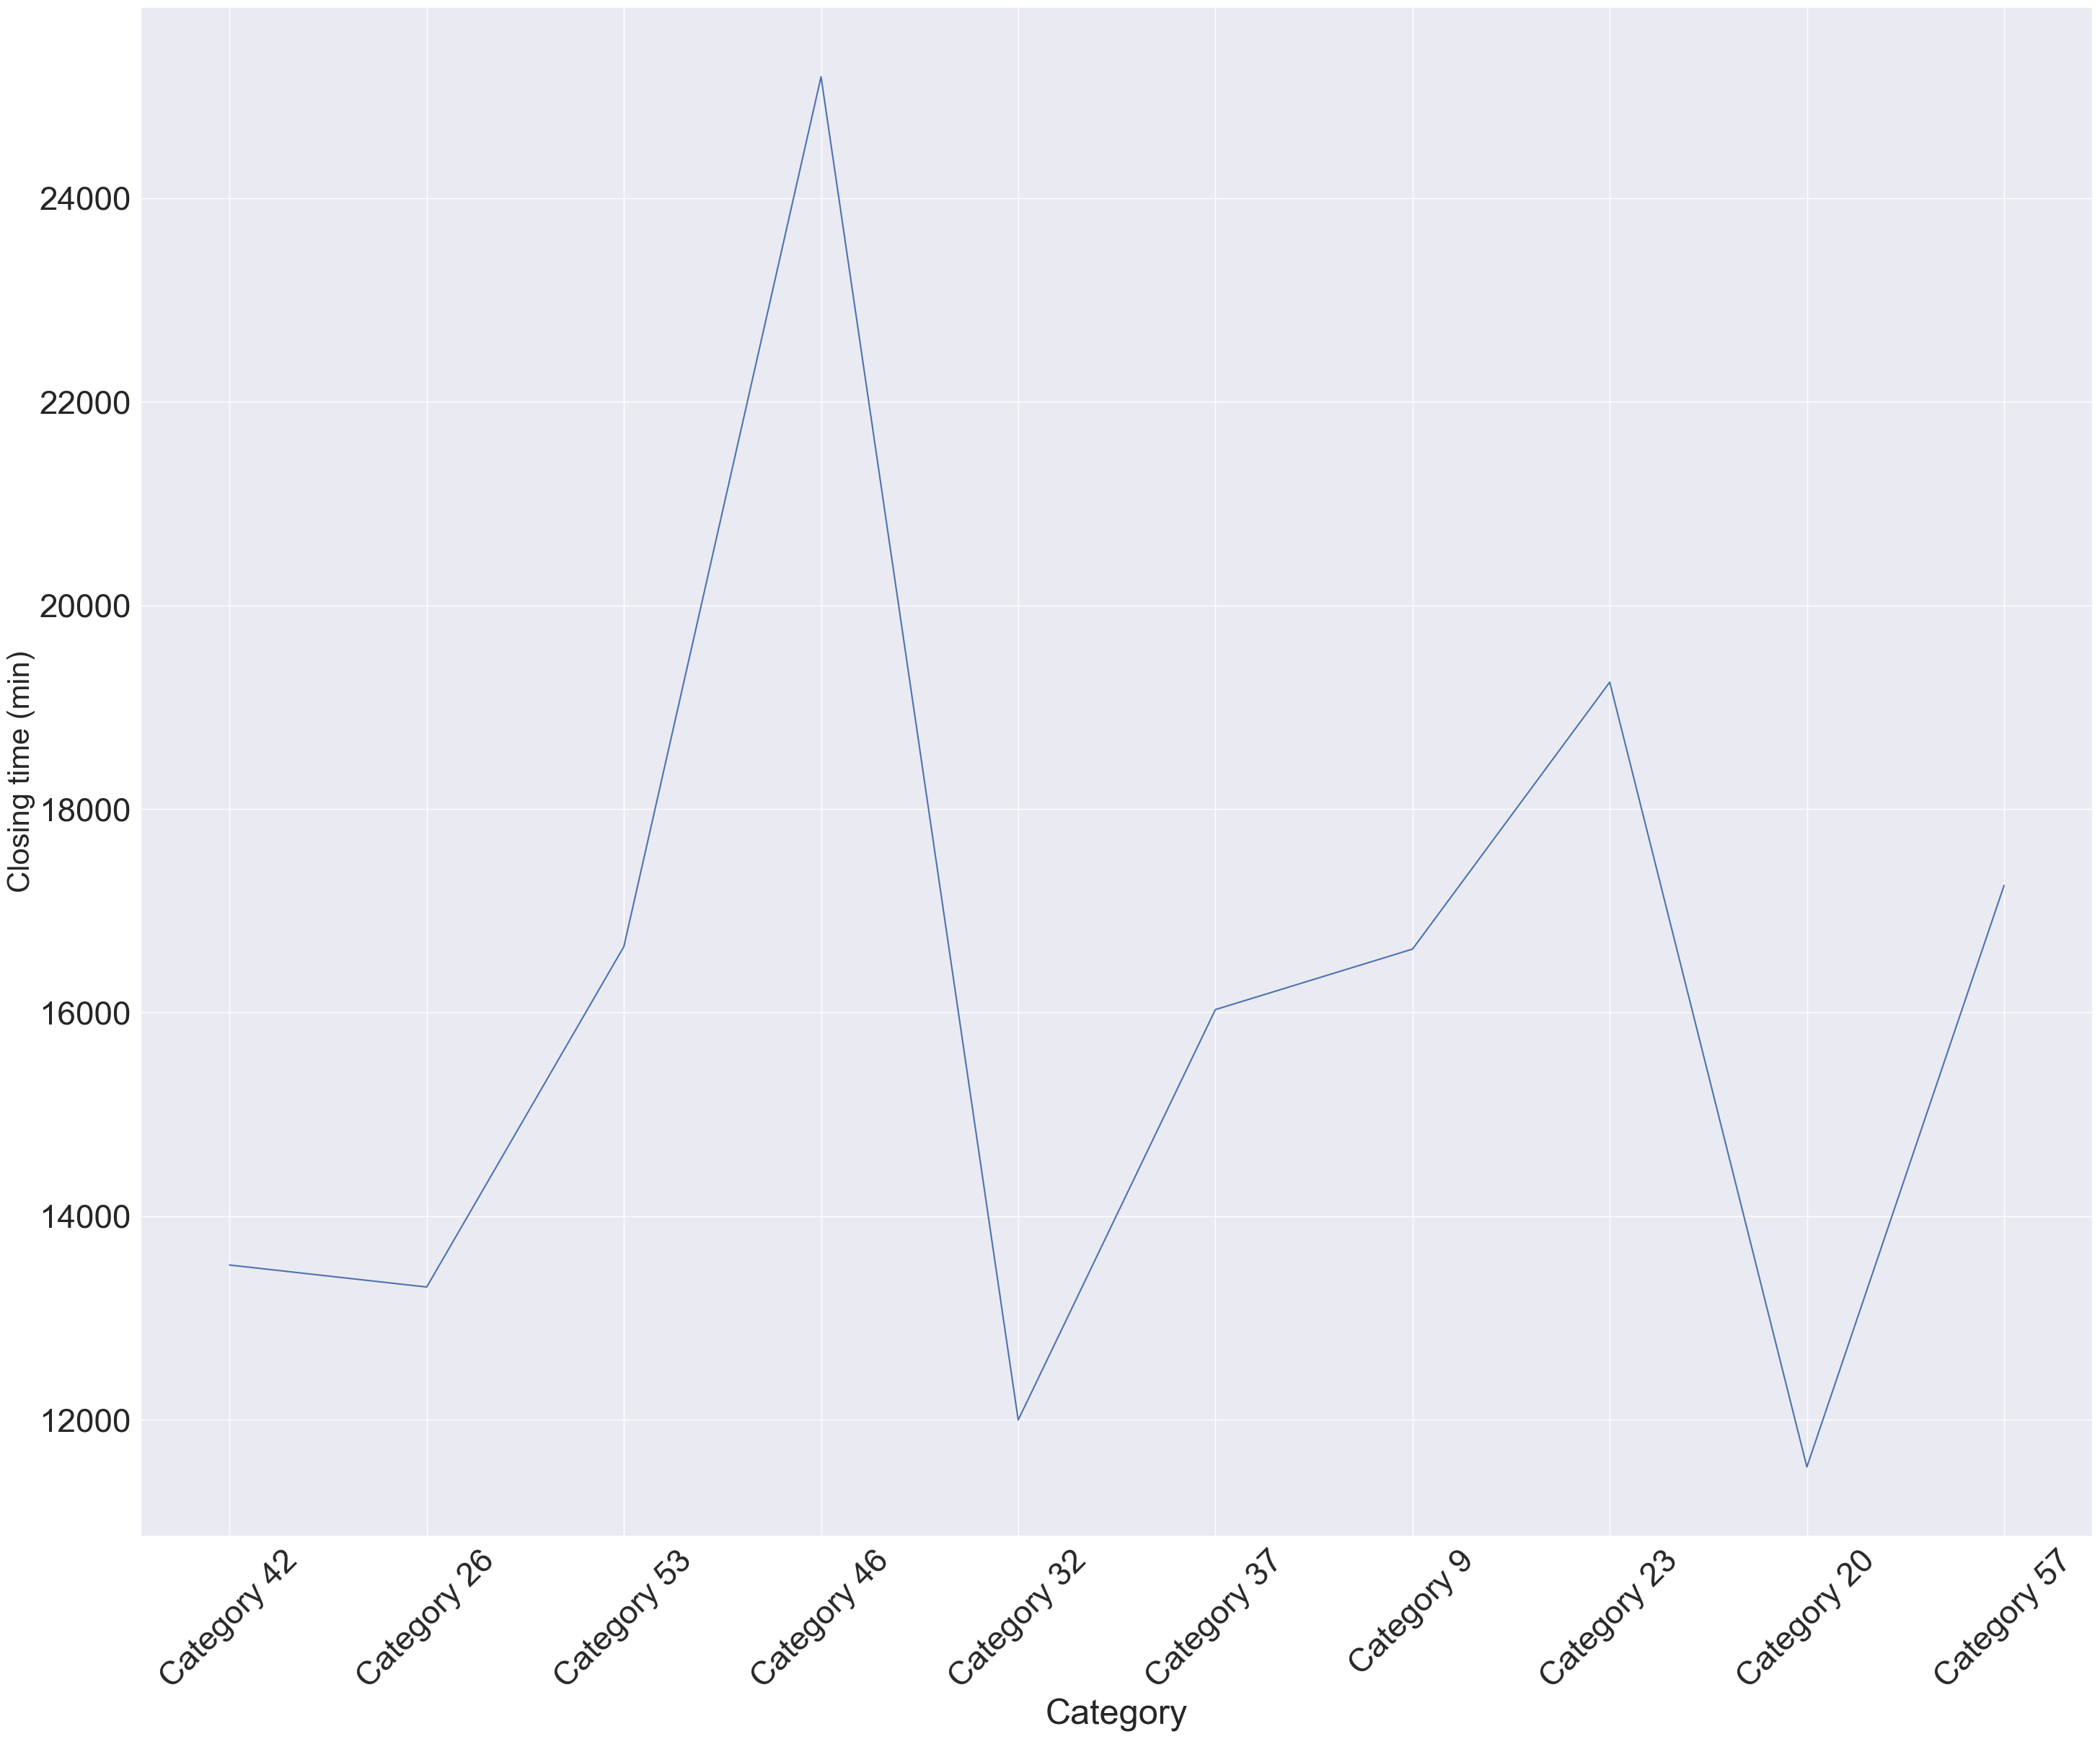

In [141]:
colfilter = inc_closed["category"].value_counts()[:10].index
cat_time = inc_closed[inc_closed["category"].isin(colfilter)][["category","Closing time (min)"]]
data = cat_time.groupby("category").mean().reindex(colfilter)
sns.lineplot(x=data.index,y="Closing time (min)",data=data)
plt.xlabel("Category",fontsize=35)
plt.xticks(rotation=45)
plt.margins(0.05)
plt.tight_layout()


As our major concern is to reduce the time to resolve a ticket we should be focusing on Closing time for these top 10 category shows category 53 and 46 taking a longer average time to close, whereas Category 42 and 26 take relativly less time to close hence attributing to the fact that these might be tickets that are issues that are quick to solve but have a larger frequency.

## Top 10 categories with greatest average closing time.

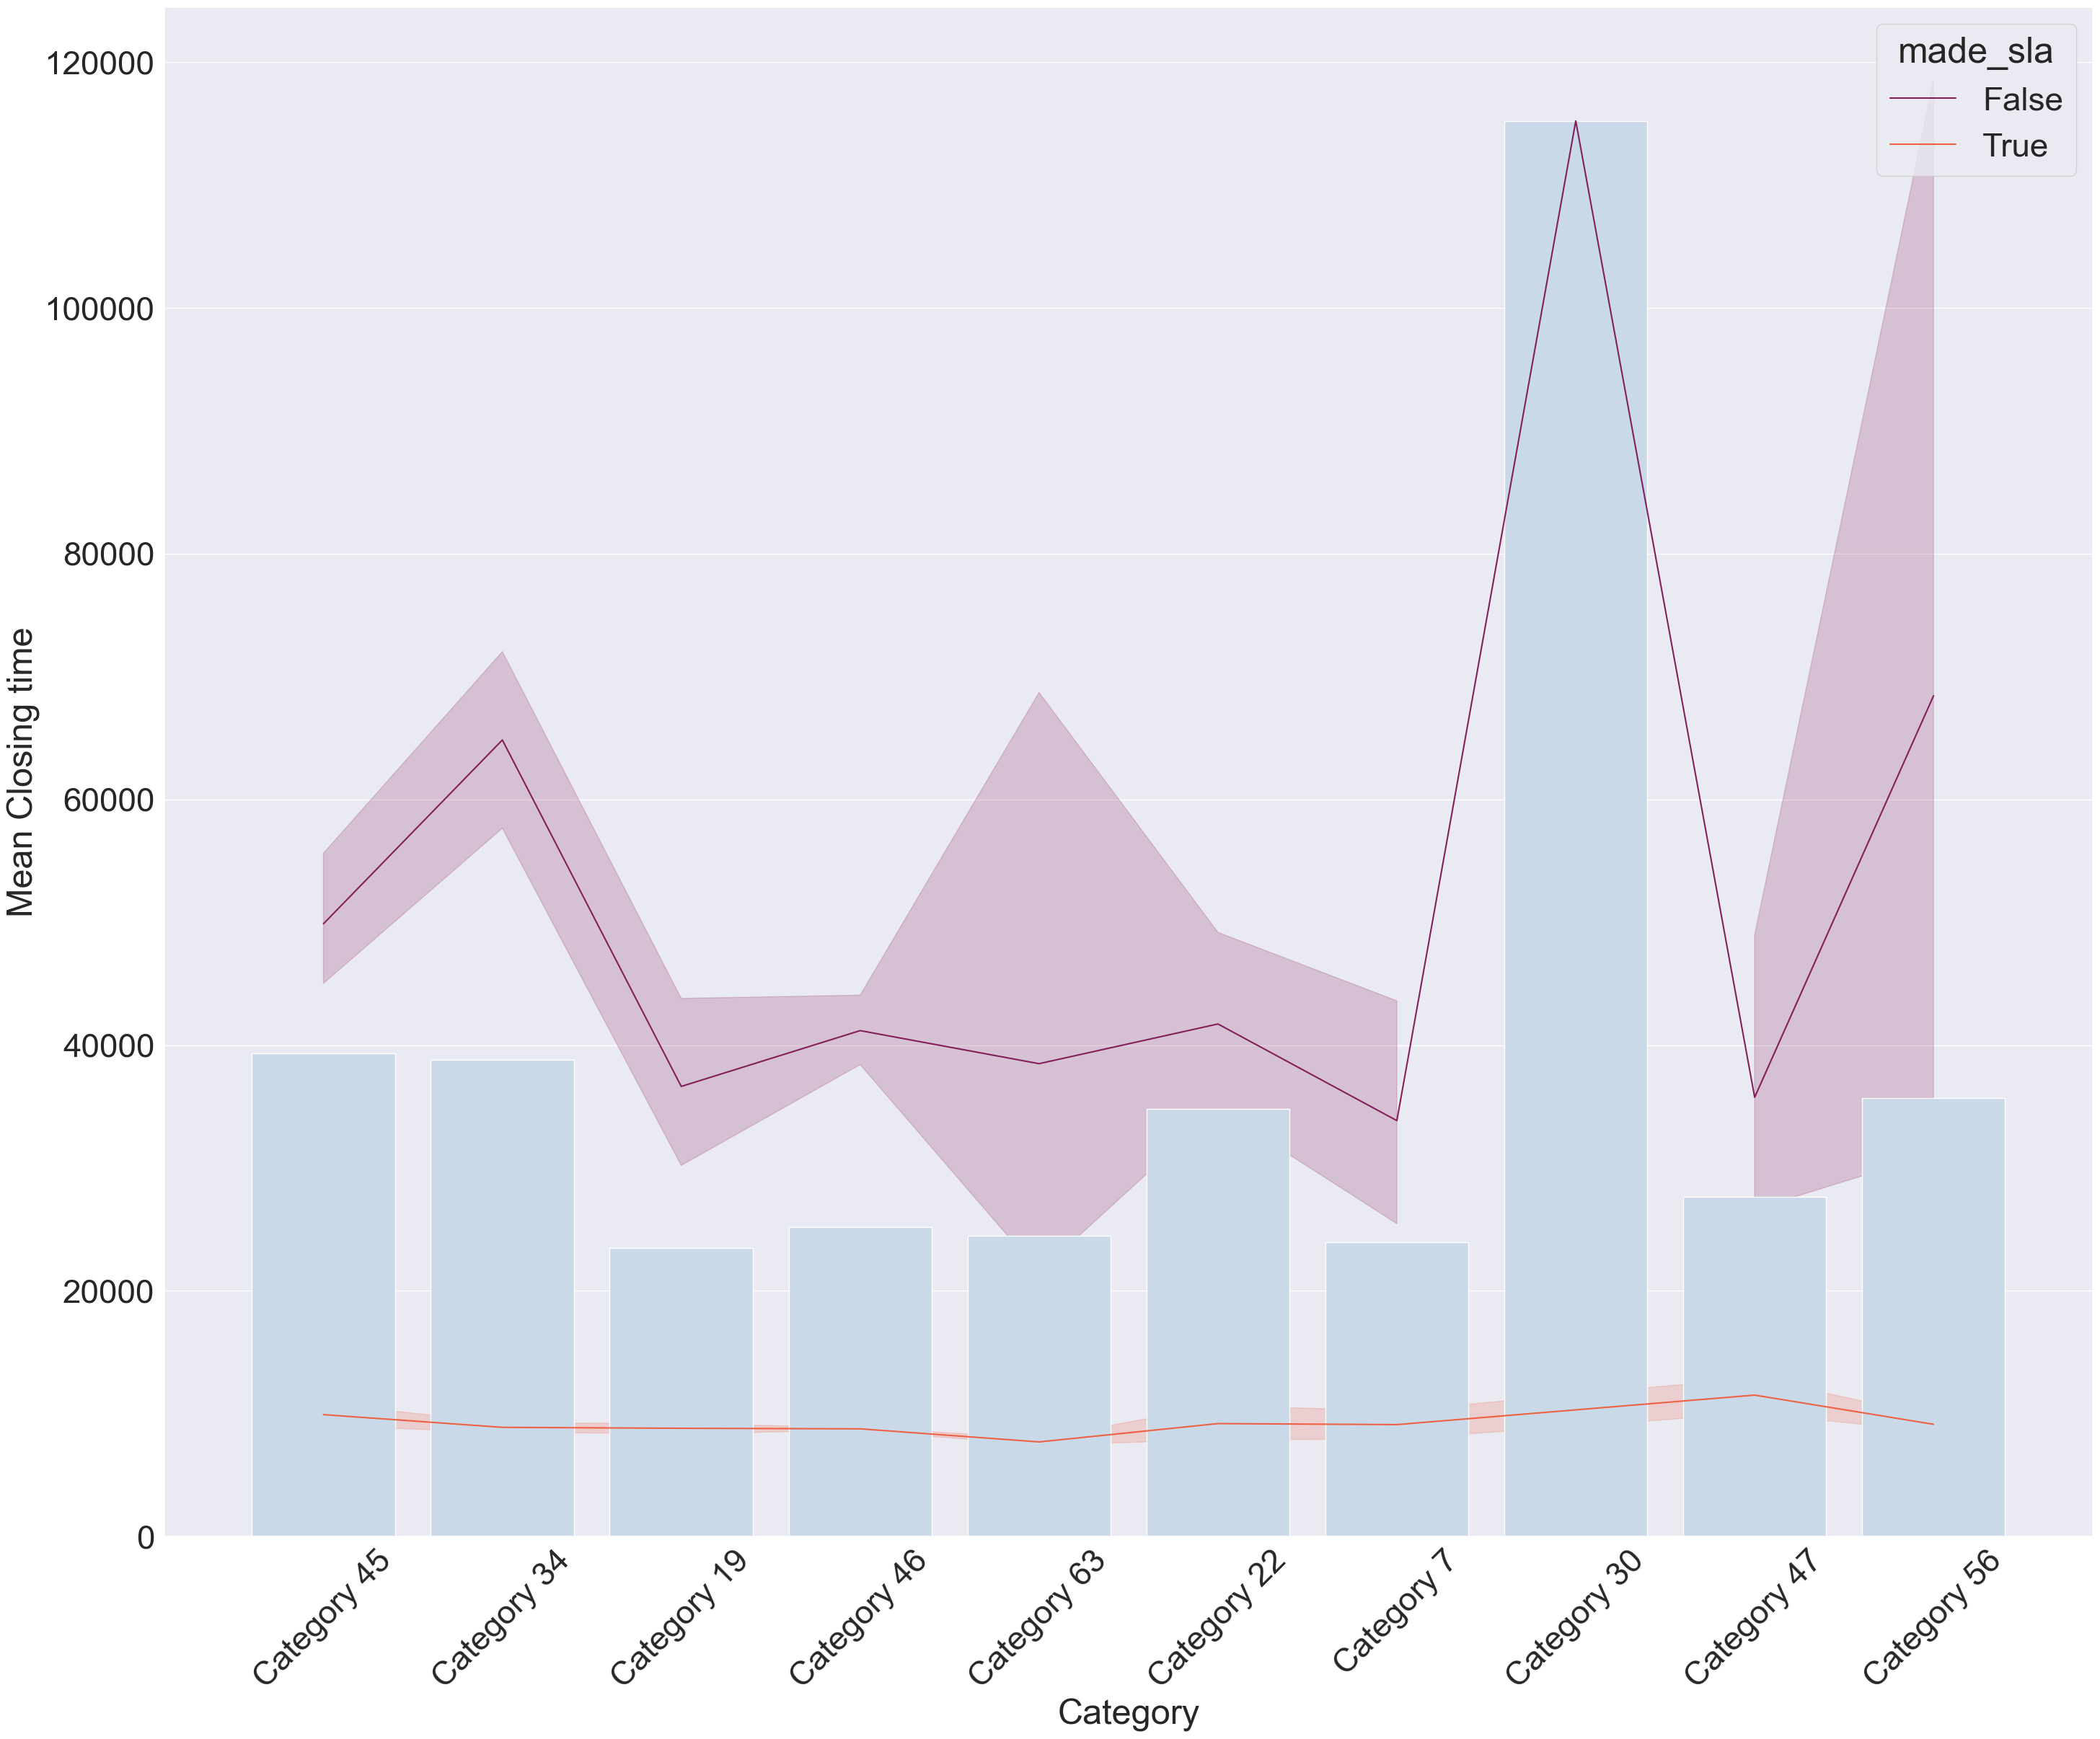

In [142]:
colfilter = inc_closed.groupby(["category"])["Closing time (min)"].mean().sort_values(ascending = False)[:10].index
cat_time = inc_closed[inc_closed["category"].isin(colfilter)][["category","Closing time (min)","made_sla"]]
sns.lineplot(x="category",y="Closing time (min)",hue="made_sla",palette="rocket",data=cat_time,ci=95)
sns.barplot(x="category",y="Closing time (min)",color= "#c4d9ec",data=cat_time,ci=None)
plt.ylabel("Mean Closing time",fontsize=35)
plt.xlabel("Category",fontsize=35)
plt.xticks(rotation=45)
plt.margins(0.05)
plt.tight_layout()

As it can be seens that in top ten categories category 30 is big concern as it is missing most of its SLA. Similarly all the categories have a more than 50% tickets failing to meet SLA. This information needs to be taken to respective team lead to find the known issues, on an overall status , below is plot for entire data. 

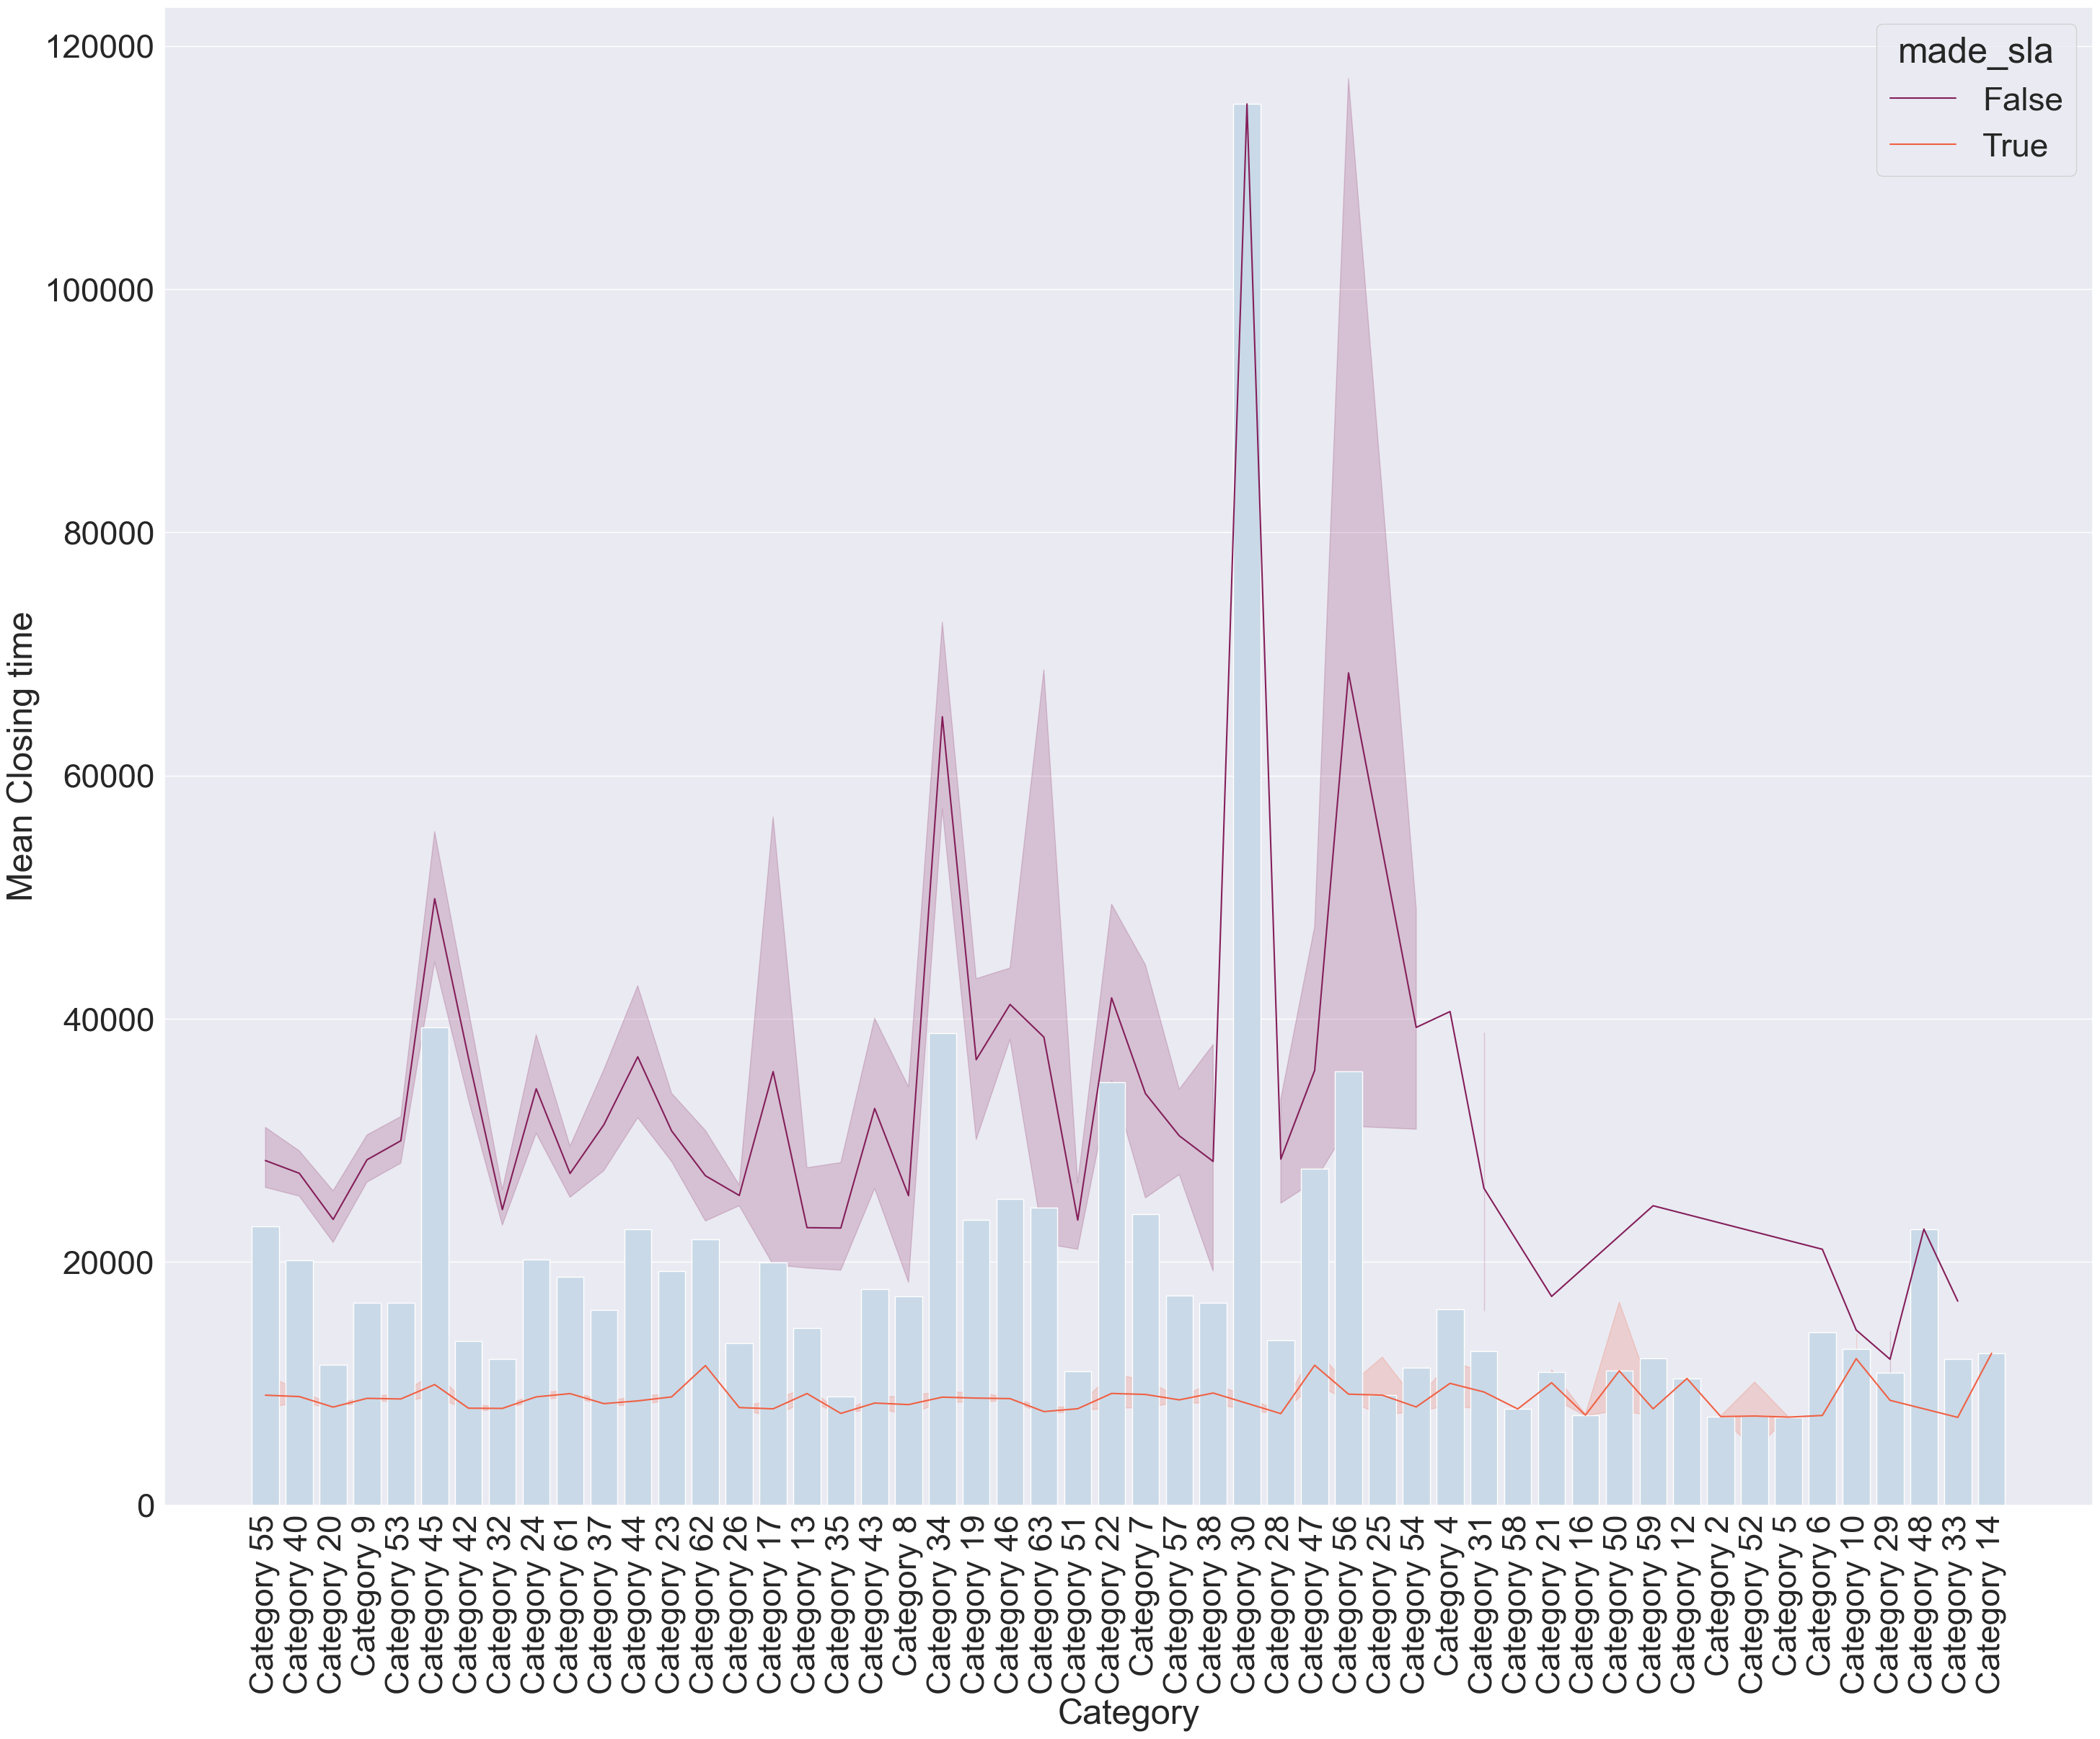

In [143]:
colfilter = inc_closed.groupby(["category"])["Closing time (min)"].mean().sort_values(ascending = False).index
cat_time = inc_closed[inc_closed["category"].isin(colfilter)][["category","Closing time (min)","made_sla"]]
sns.lineplot(x="category",y="Closing time (min)",hue="made_sla",palette="rocket",data=cat_time)
sns.barplot(x="category",y="Closing time (min)",color= "#c4d9ec",data=cat_time,ci=None)
plt.ylabel("Mean Closing time",fontsize=35)
plt.xlabel("Category",fontsize=35)
plt.xticks(rotation=90)
plt.margins(0.05)
plt.tight_layout()

## Most active location with most number of incidents.

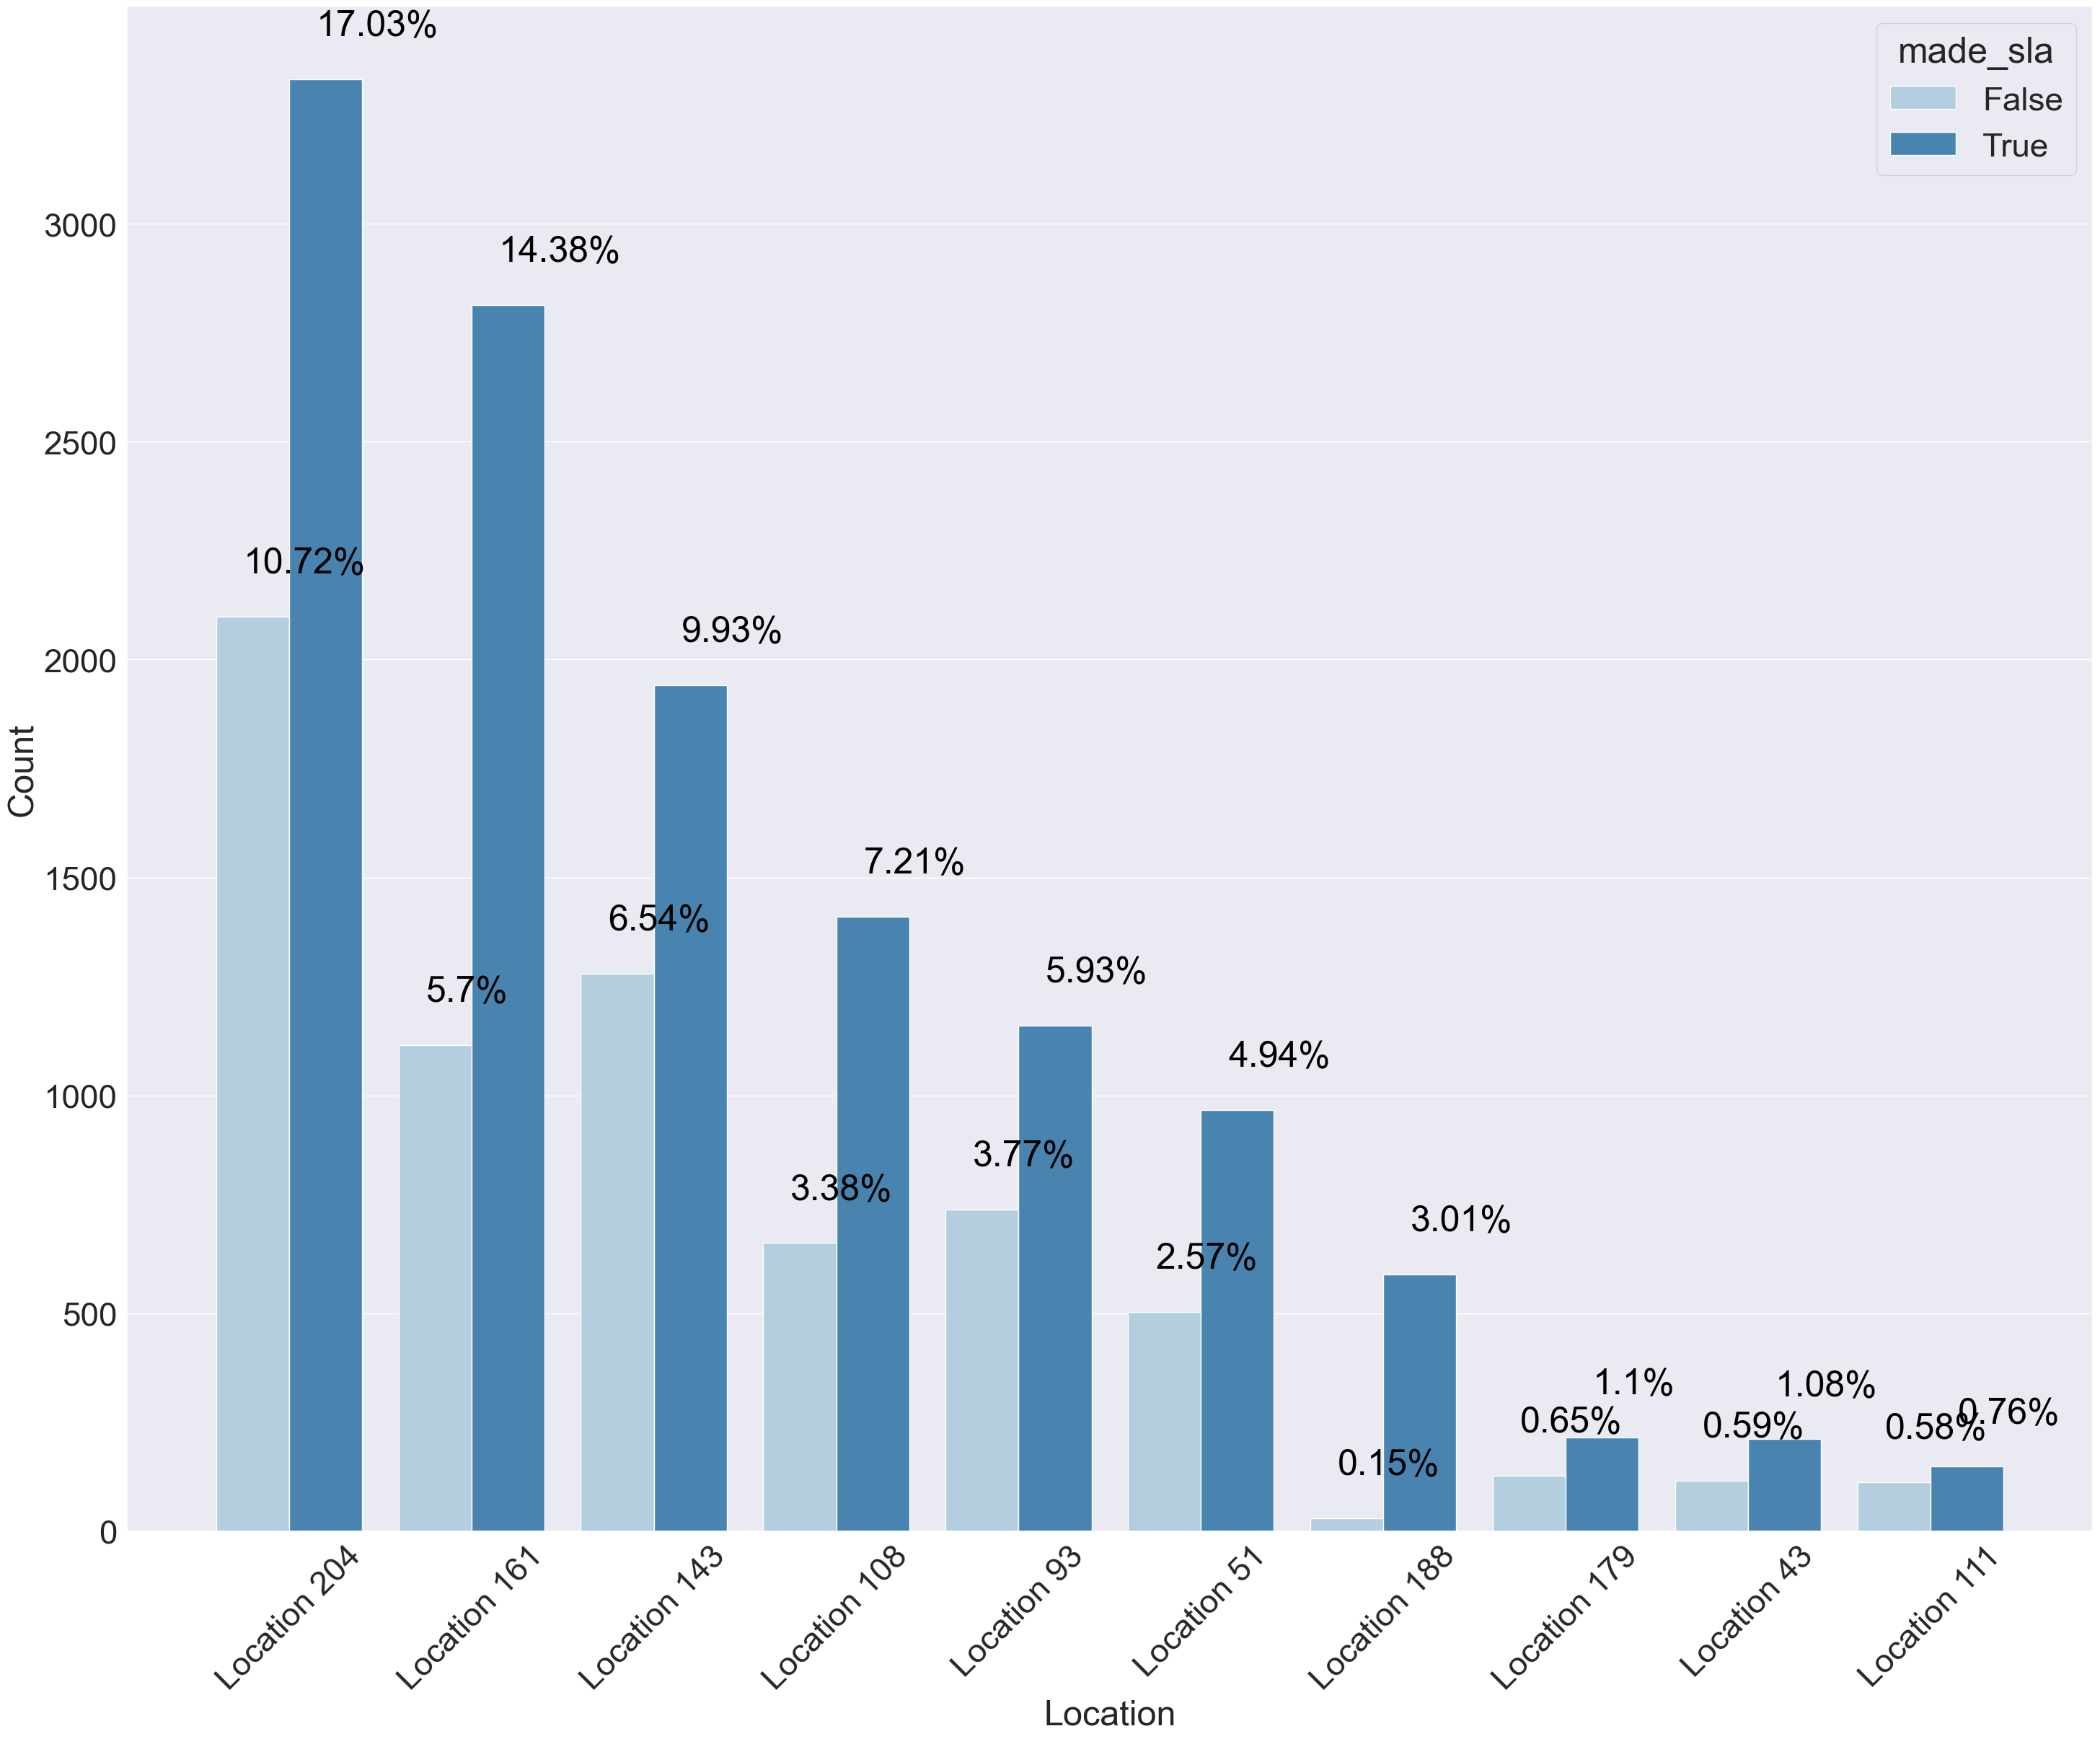

In [144]:
ax =sns.countplot(data = inc_closed, x = "location",hue="made_sla",palette = 'Blues',edgecolor = 'w',order=inc_closed["location"].value_counts()[:10].index)
plt.ylabel("Count",fontsize=35)  
plt.xlabel("Location",fontsize=35)
plt.xticks(rotation=45)
plt.margins(0.05)
bar_perc(ax)
plt.tight_layout()

As seen above plot major number of tickets are from Location 204 , which indicates major issues in the environment there, as more than 27% of the total tickets from these 10 locations are from Location 204, and this also has the most tickets that do not meet there SLA.

### Considering that we have taken above data based on top 10 location hence confirming the above information on missed SLA below

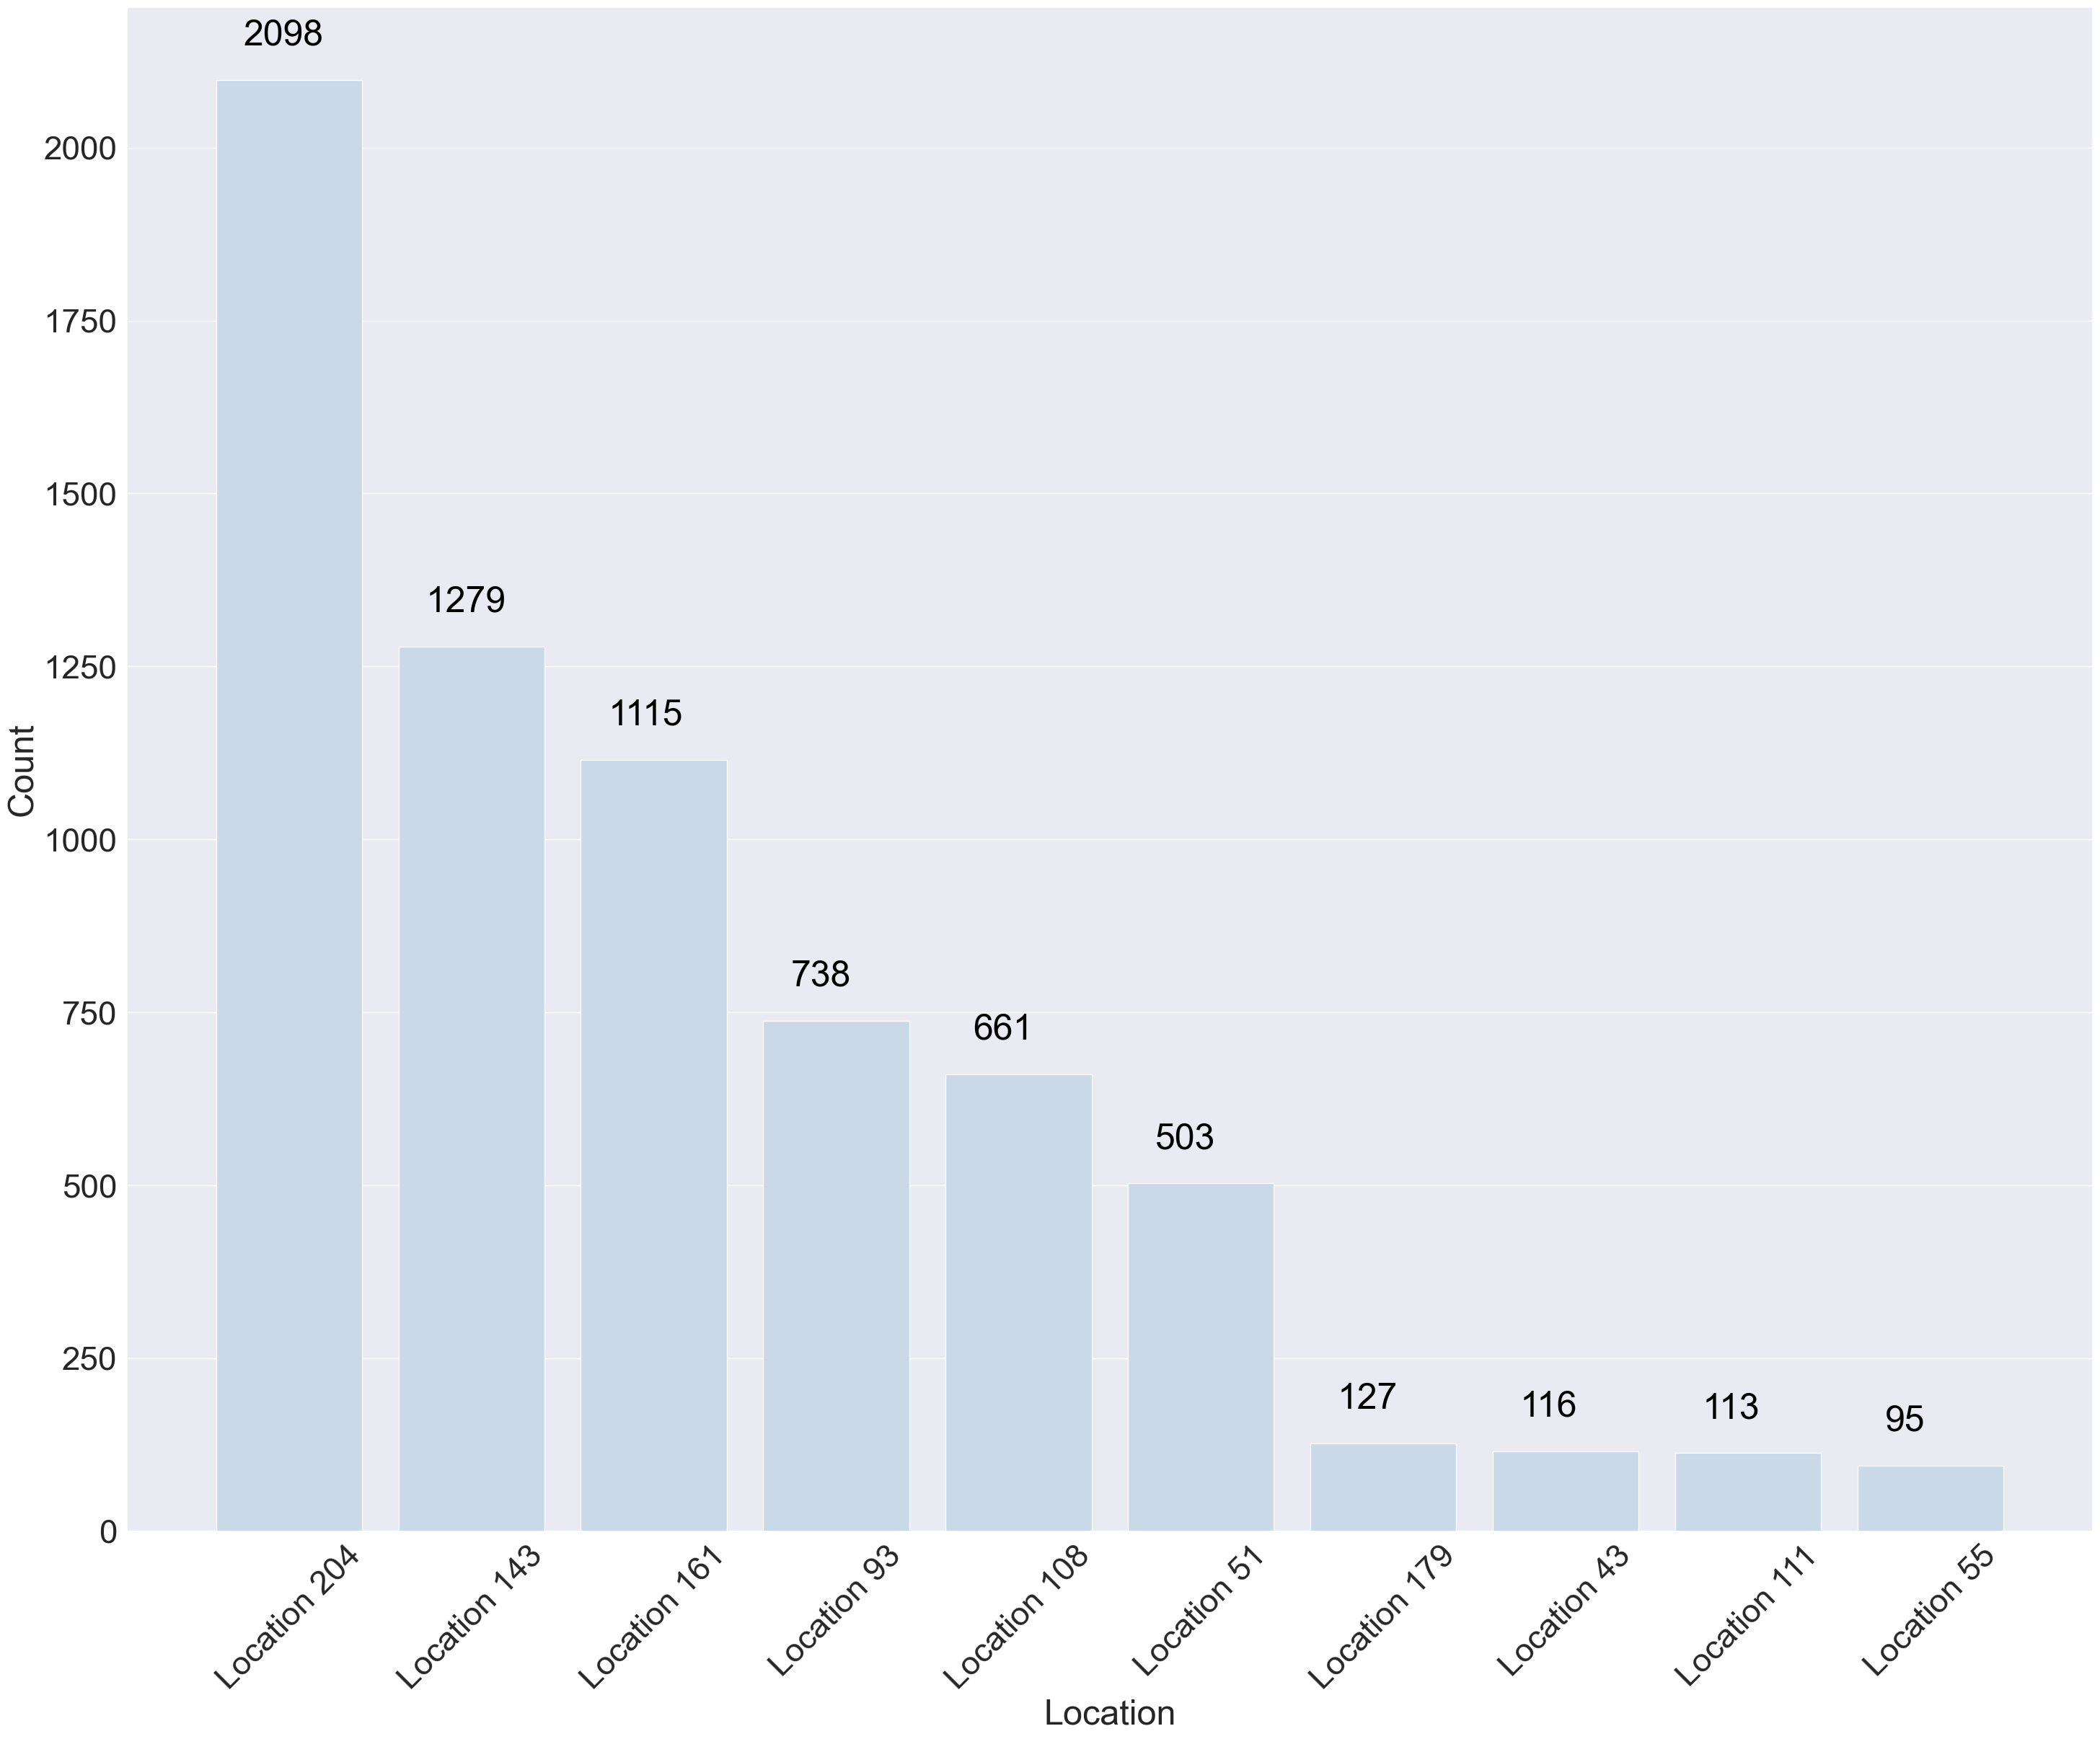

In [145]:
ax =sns.countplot(data = inc_closed[inc_closed["made_sla"]==False], x = "location",color= "#c4d9ec",order=inc_closed[inc_closed["made_sla"]==False]["location"].value_counts()[:10].index)
plt.ylabel("Count",fontsize=35)  
plt.xlabel("Location",fontsize=35)
plt.xticks(rotation=45)
plt.margins(0.05)
bar_count(ax)
plt.tight_layout()

As seen from above plot all the information that was gather regarding missing SLA can be seen here.

### Below plot shows the distribution of tickets based on priority which shows where most SLA is missed.

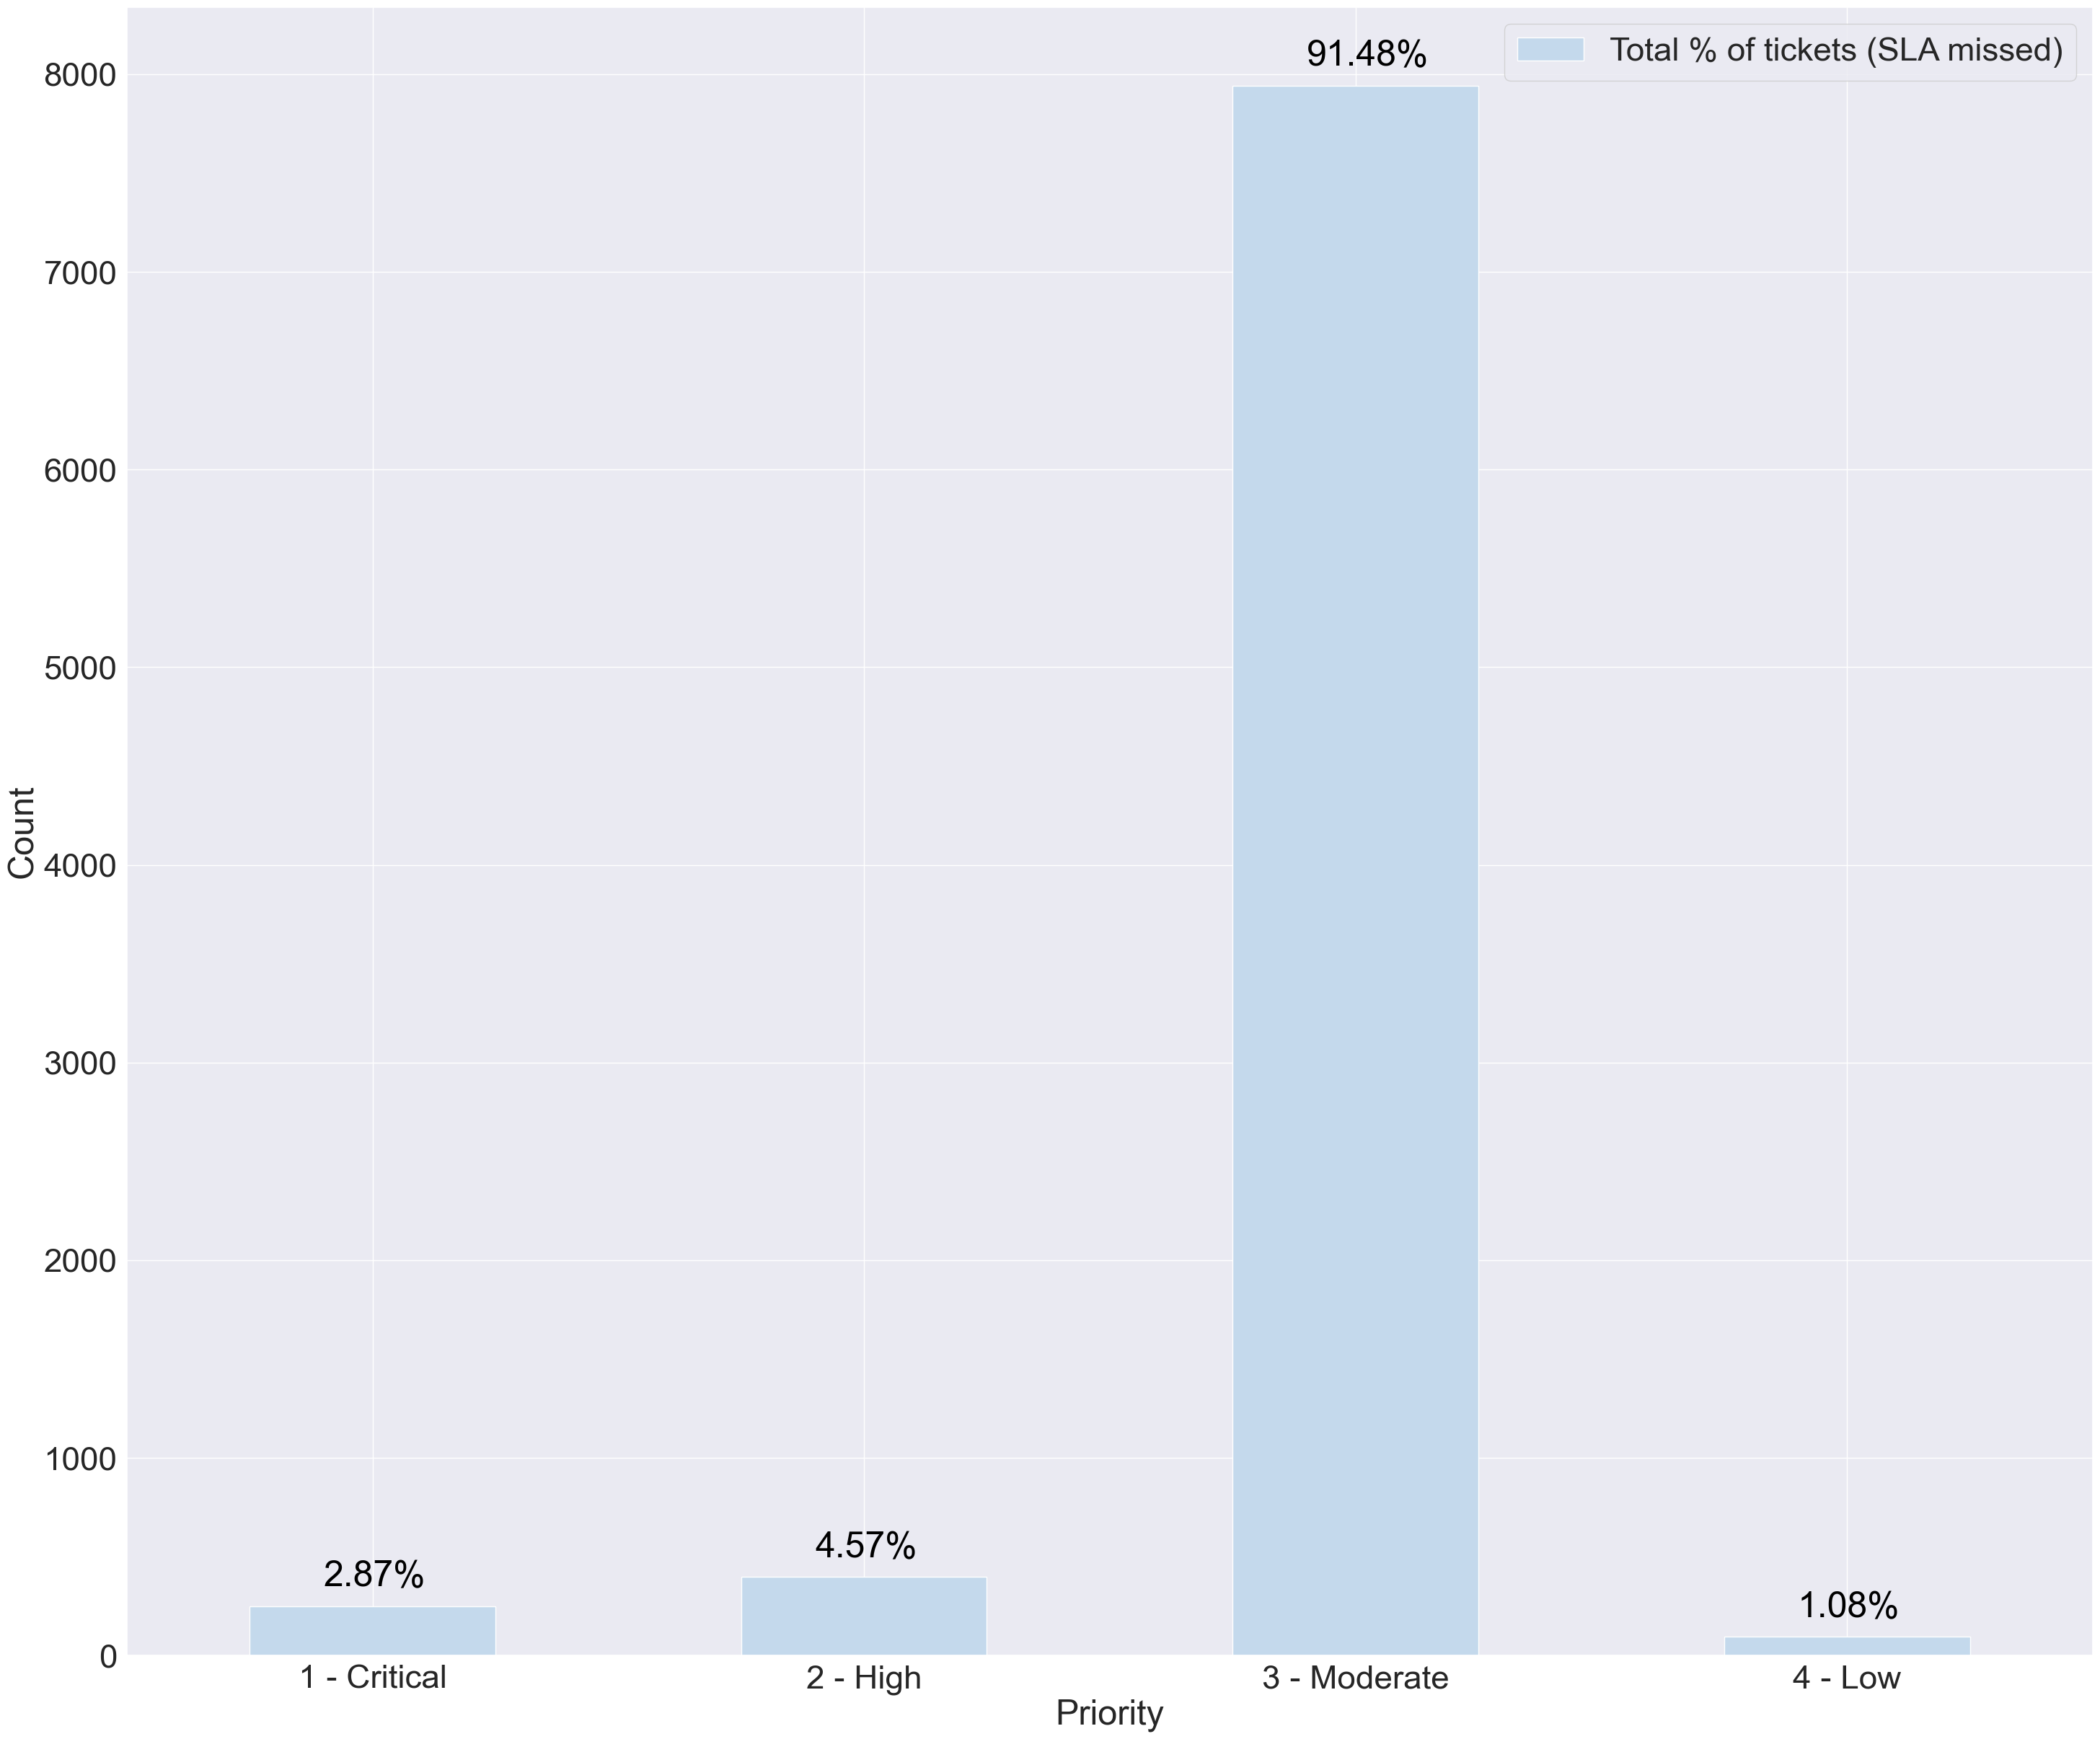

In [146]:
ax1=inc_closed[inc_closed["made_sla"]==False].groupby(["priority"])["Closing time (min)"].count().plot(kind="bar",color="#c4d9ec")

bar_perc(ax1)

plt.ylabel("Count",fontsize=35)  
plt.xlabel("Priority",fontsize=35)
plt.legend(["Total % of tickets (SLA missed)"])
plt.xticks(rotation=0)
plt.margins(0.05)

plt.tight_layout()

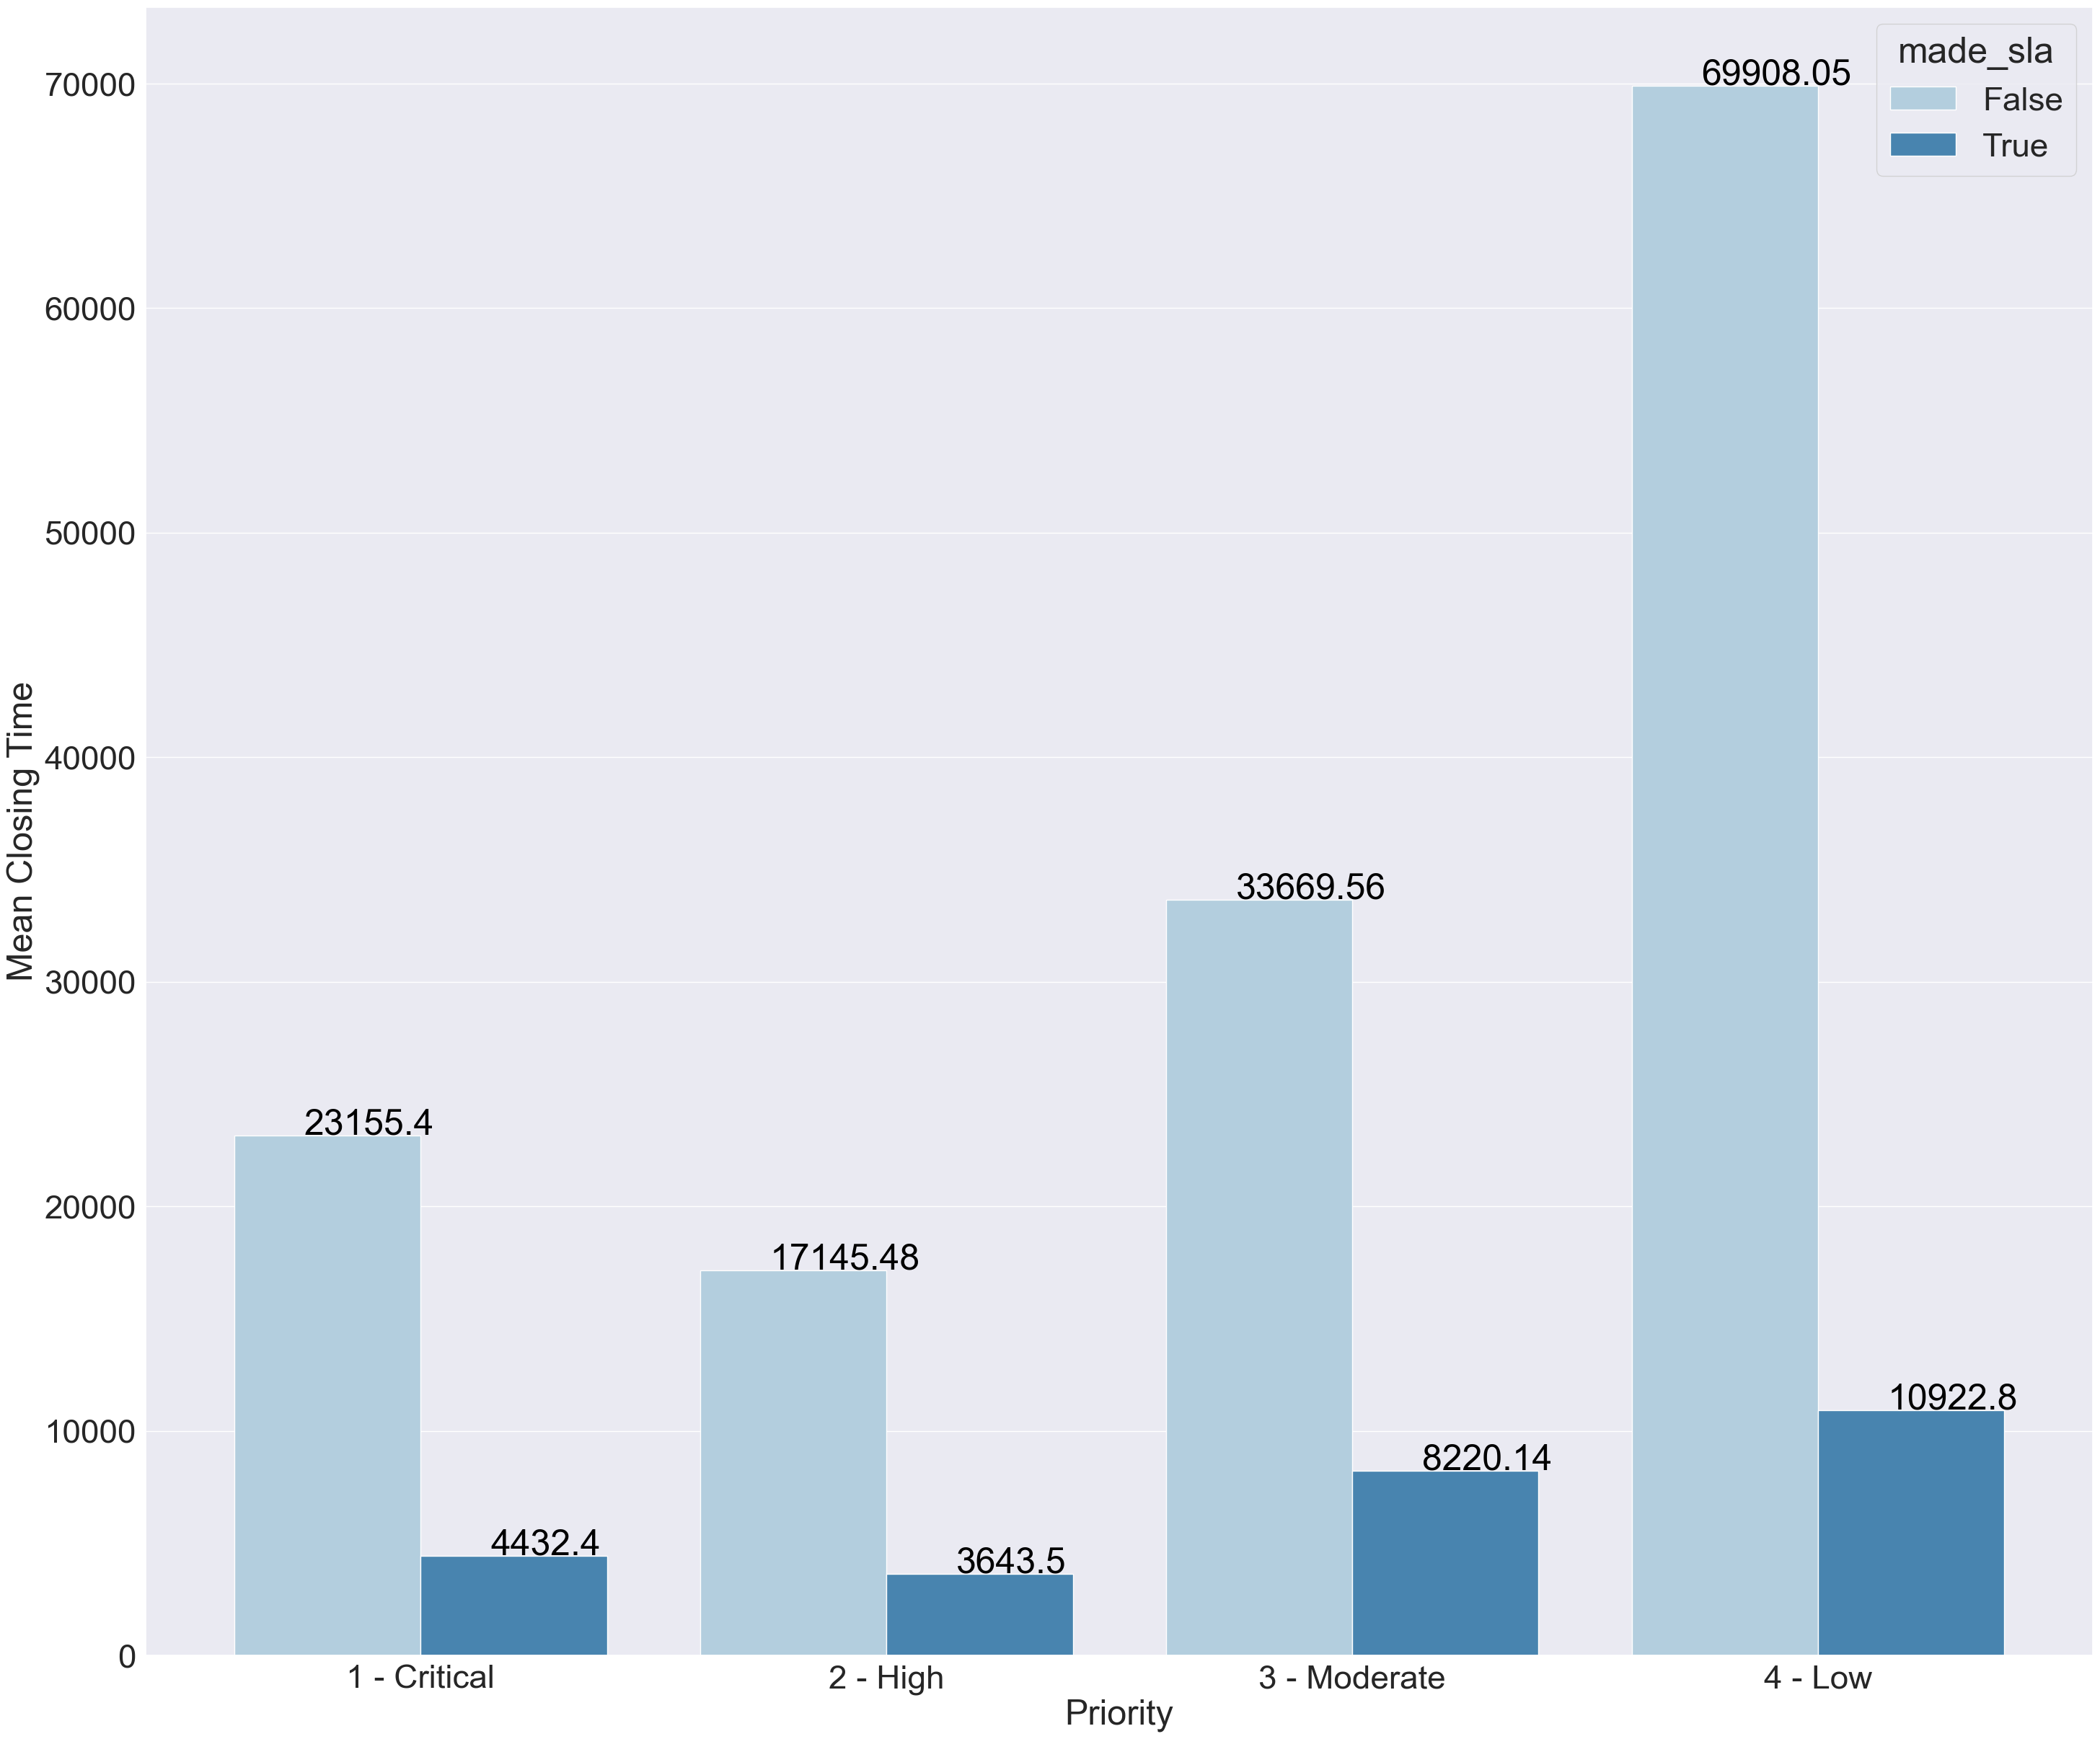

In [147]:
data = inc_closed.groupby(["priority","made_sla"])["Closing time (min)"].mean().reset_index()

ax = sns.barplot(x="priority",y="Closing time (min)",hue="made_sla",palette = 'Blues',edgecolor = 'w',data=data)

bar_count(ax)
plt.ylabel("Mean Closing Time",fontsize=35)
plt.xlabel("Priority",fontsize=35)
plt.xticks(rotation=0)
plt.margins(0.05)
plt.tight_layout()

Above plots shows that most of the priority 4 tickets seems to have biggest portion of tickets failing to meet SLA and exceeding the avg time to close a ticket by a huge margin.

Considering all above conditions, we have multiple criterion to get needfull information on where stack holders need to focus for process improvment.

local agents and their leads are on ground and need to be notified on where to focus there efforts to reduce the overall SLA default and increase productivity.

Below is the distribution of top 5 location which are hurting and needs attention on top 5 categories at each location which should be improved.

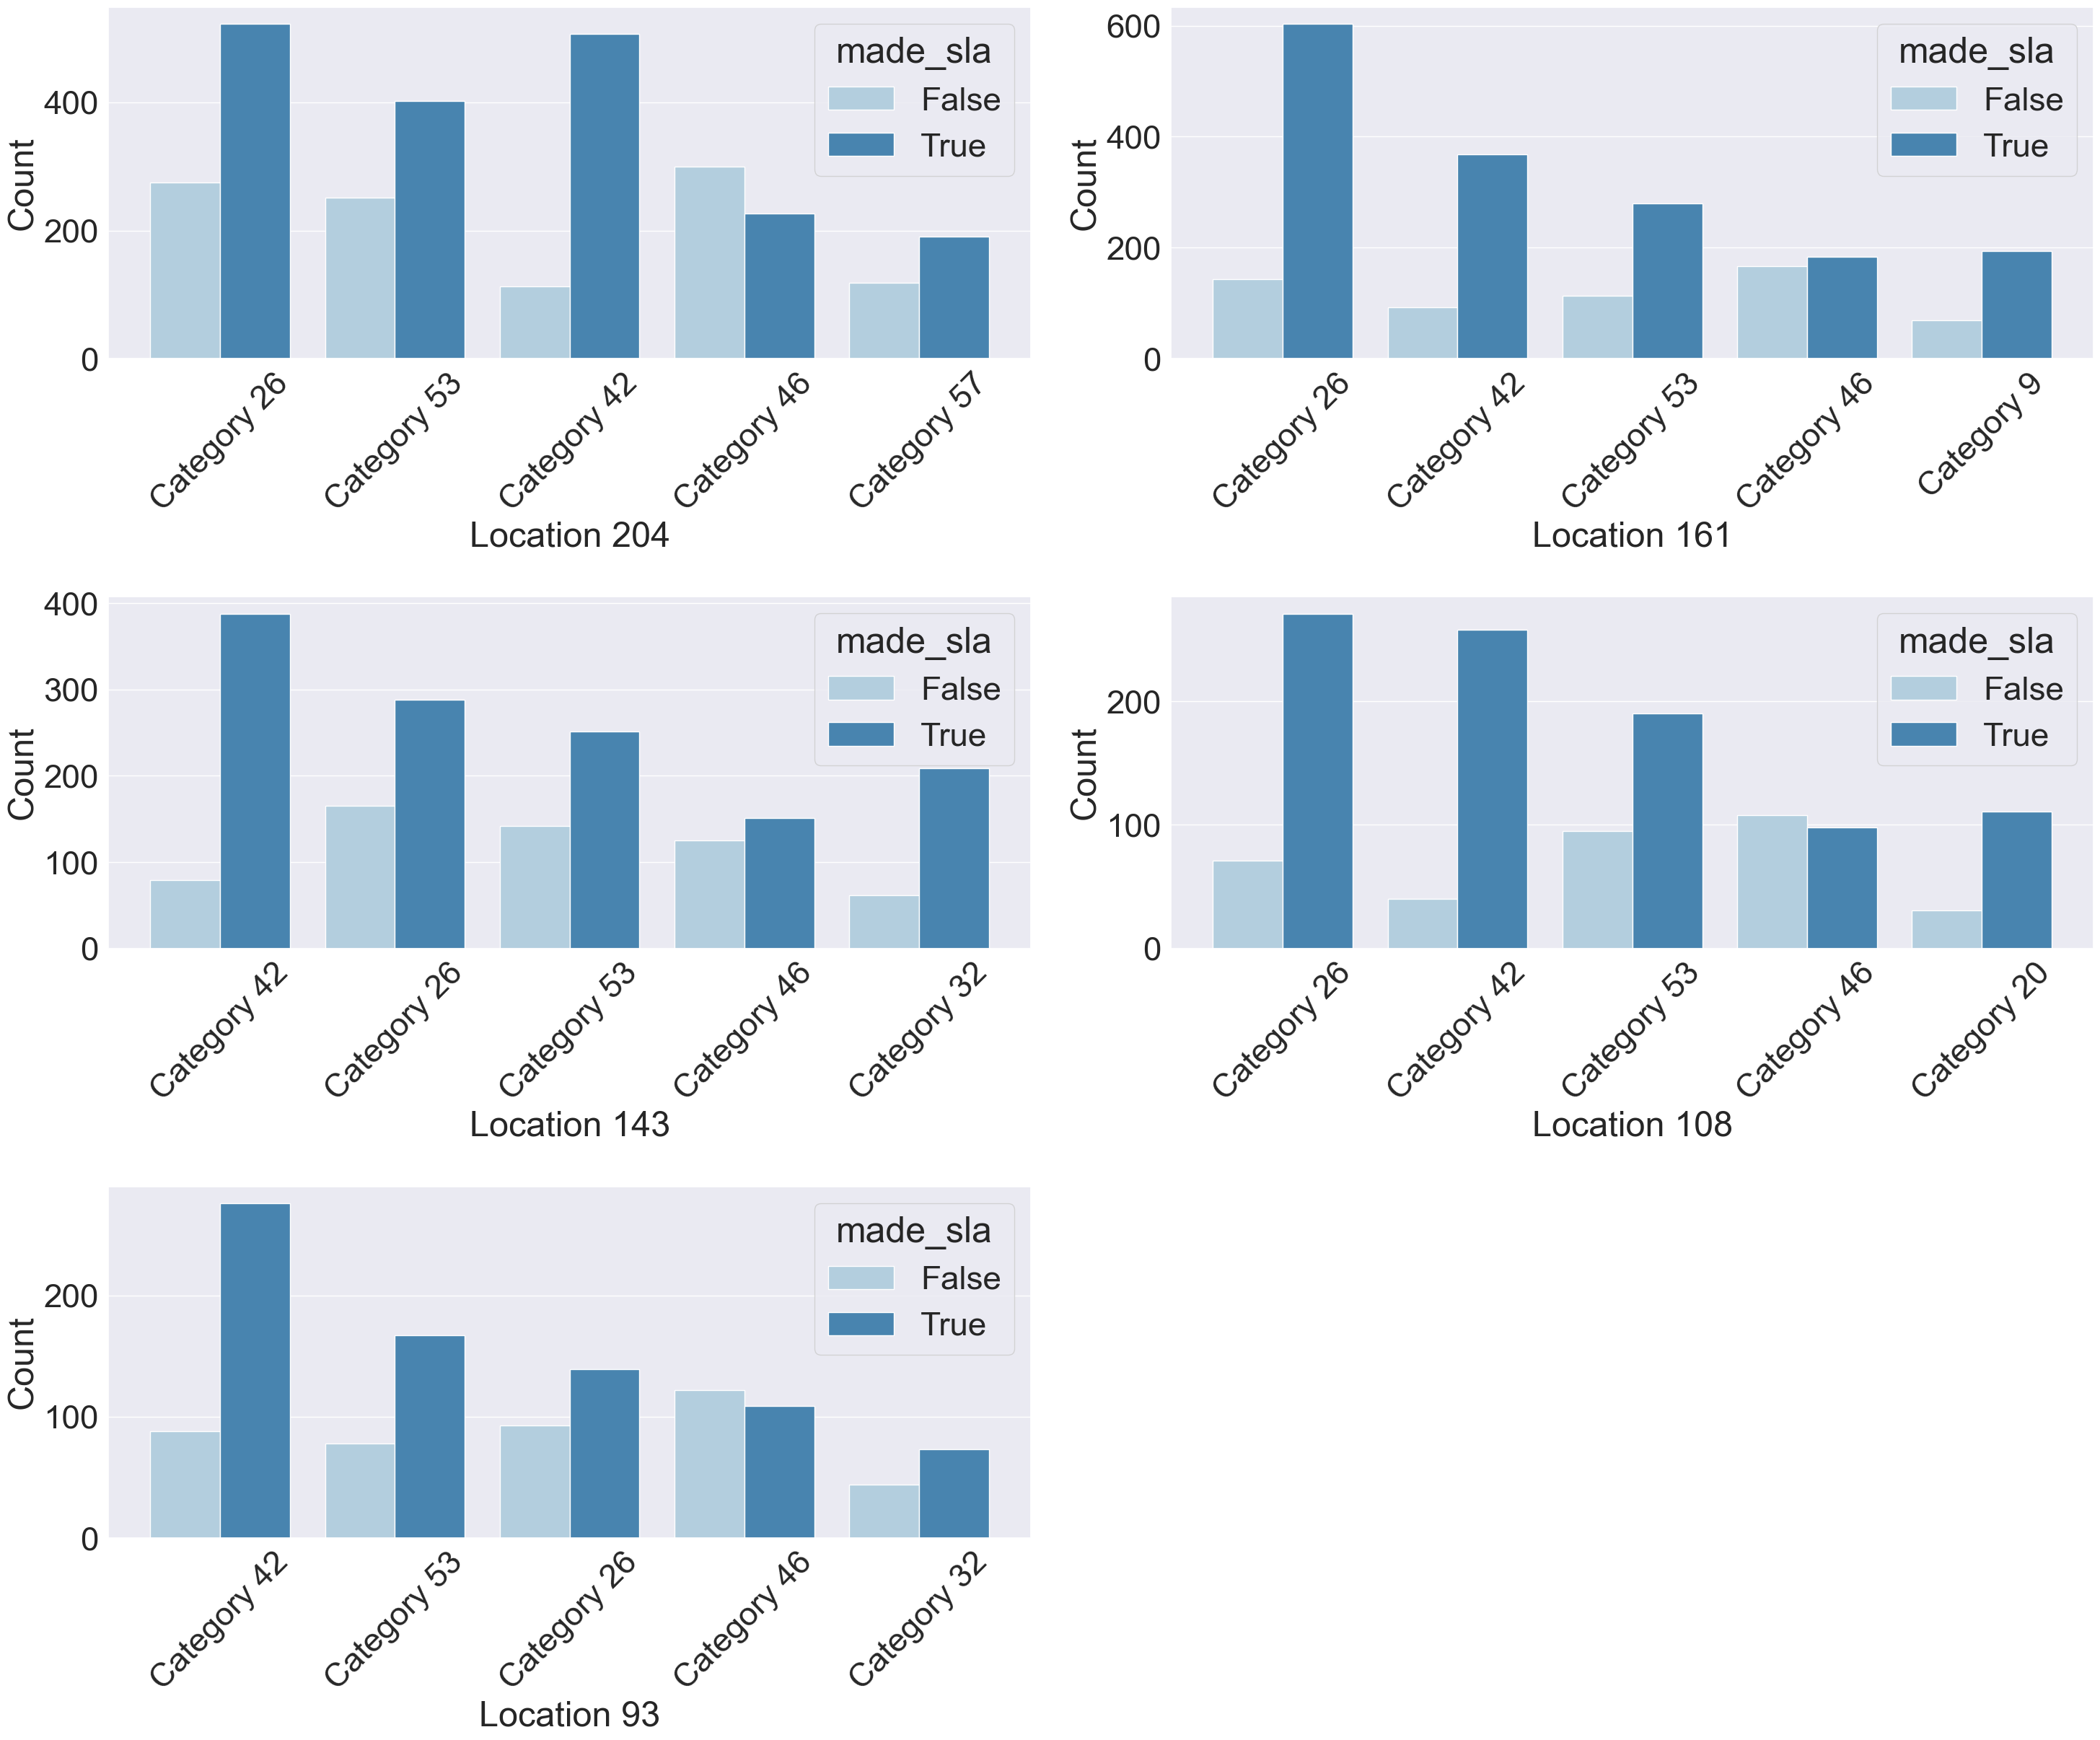

In [148]:
top_loc = inc_closed["location"].value_counts()[:5].index

for i,j in enumerate(top_loc):
    plt.subplot(3,2,i+1)
    data = inc_closed[inc_closed["location"]==top_loc[i]][["category","made_sla"]]
    order = data["category"].value_counts()[:5].index
    ax = sns.countplot(x="category",data=data,hue="made_sla",palette = 'Blues',edgecolor = 'w',order=order)
    plt.ylabel("Count",fontsize=35)  
    plt.xlabel((j),fontsize=35)   
    plt.margins(0.05)
    plt.xticks(rotation=45)
    
plt.tight_layout()    

With all the information regarding the distribution of tickets, and how the locations are performing.Service agents are the assets that runs the entire operations and their performnce needs to be monitored constentlyto improve productivity and reduce agent level errors. 


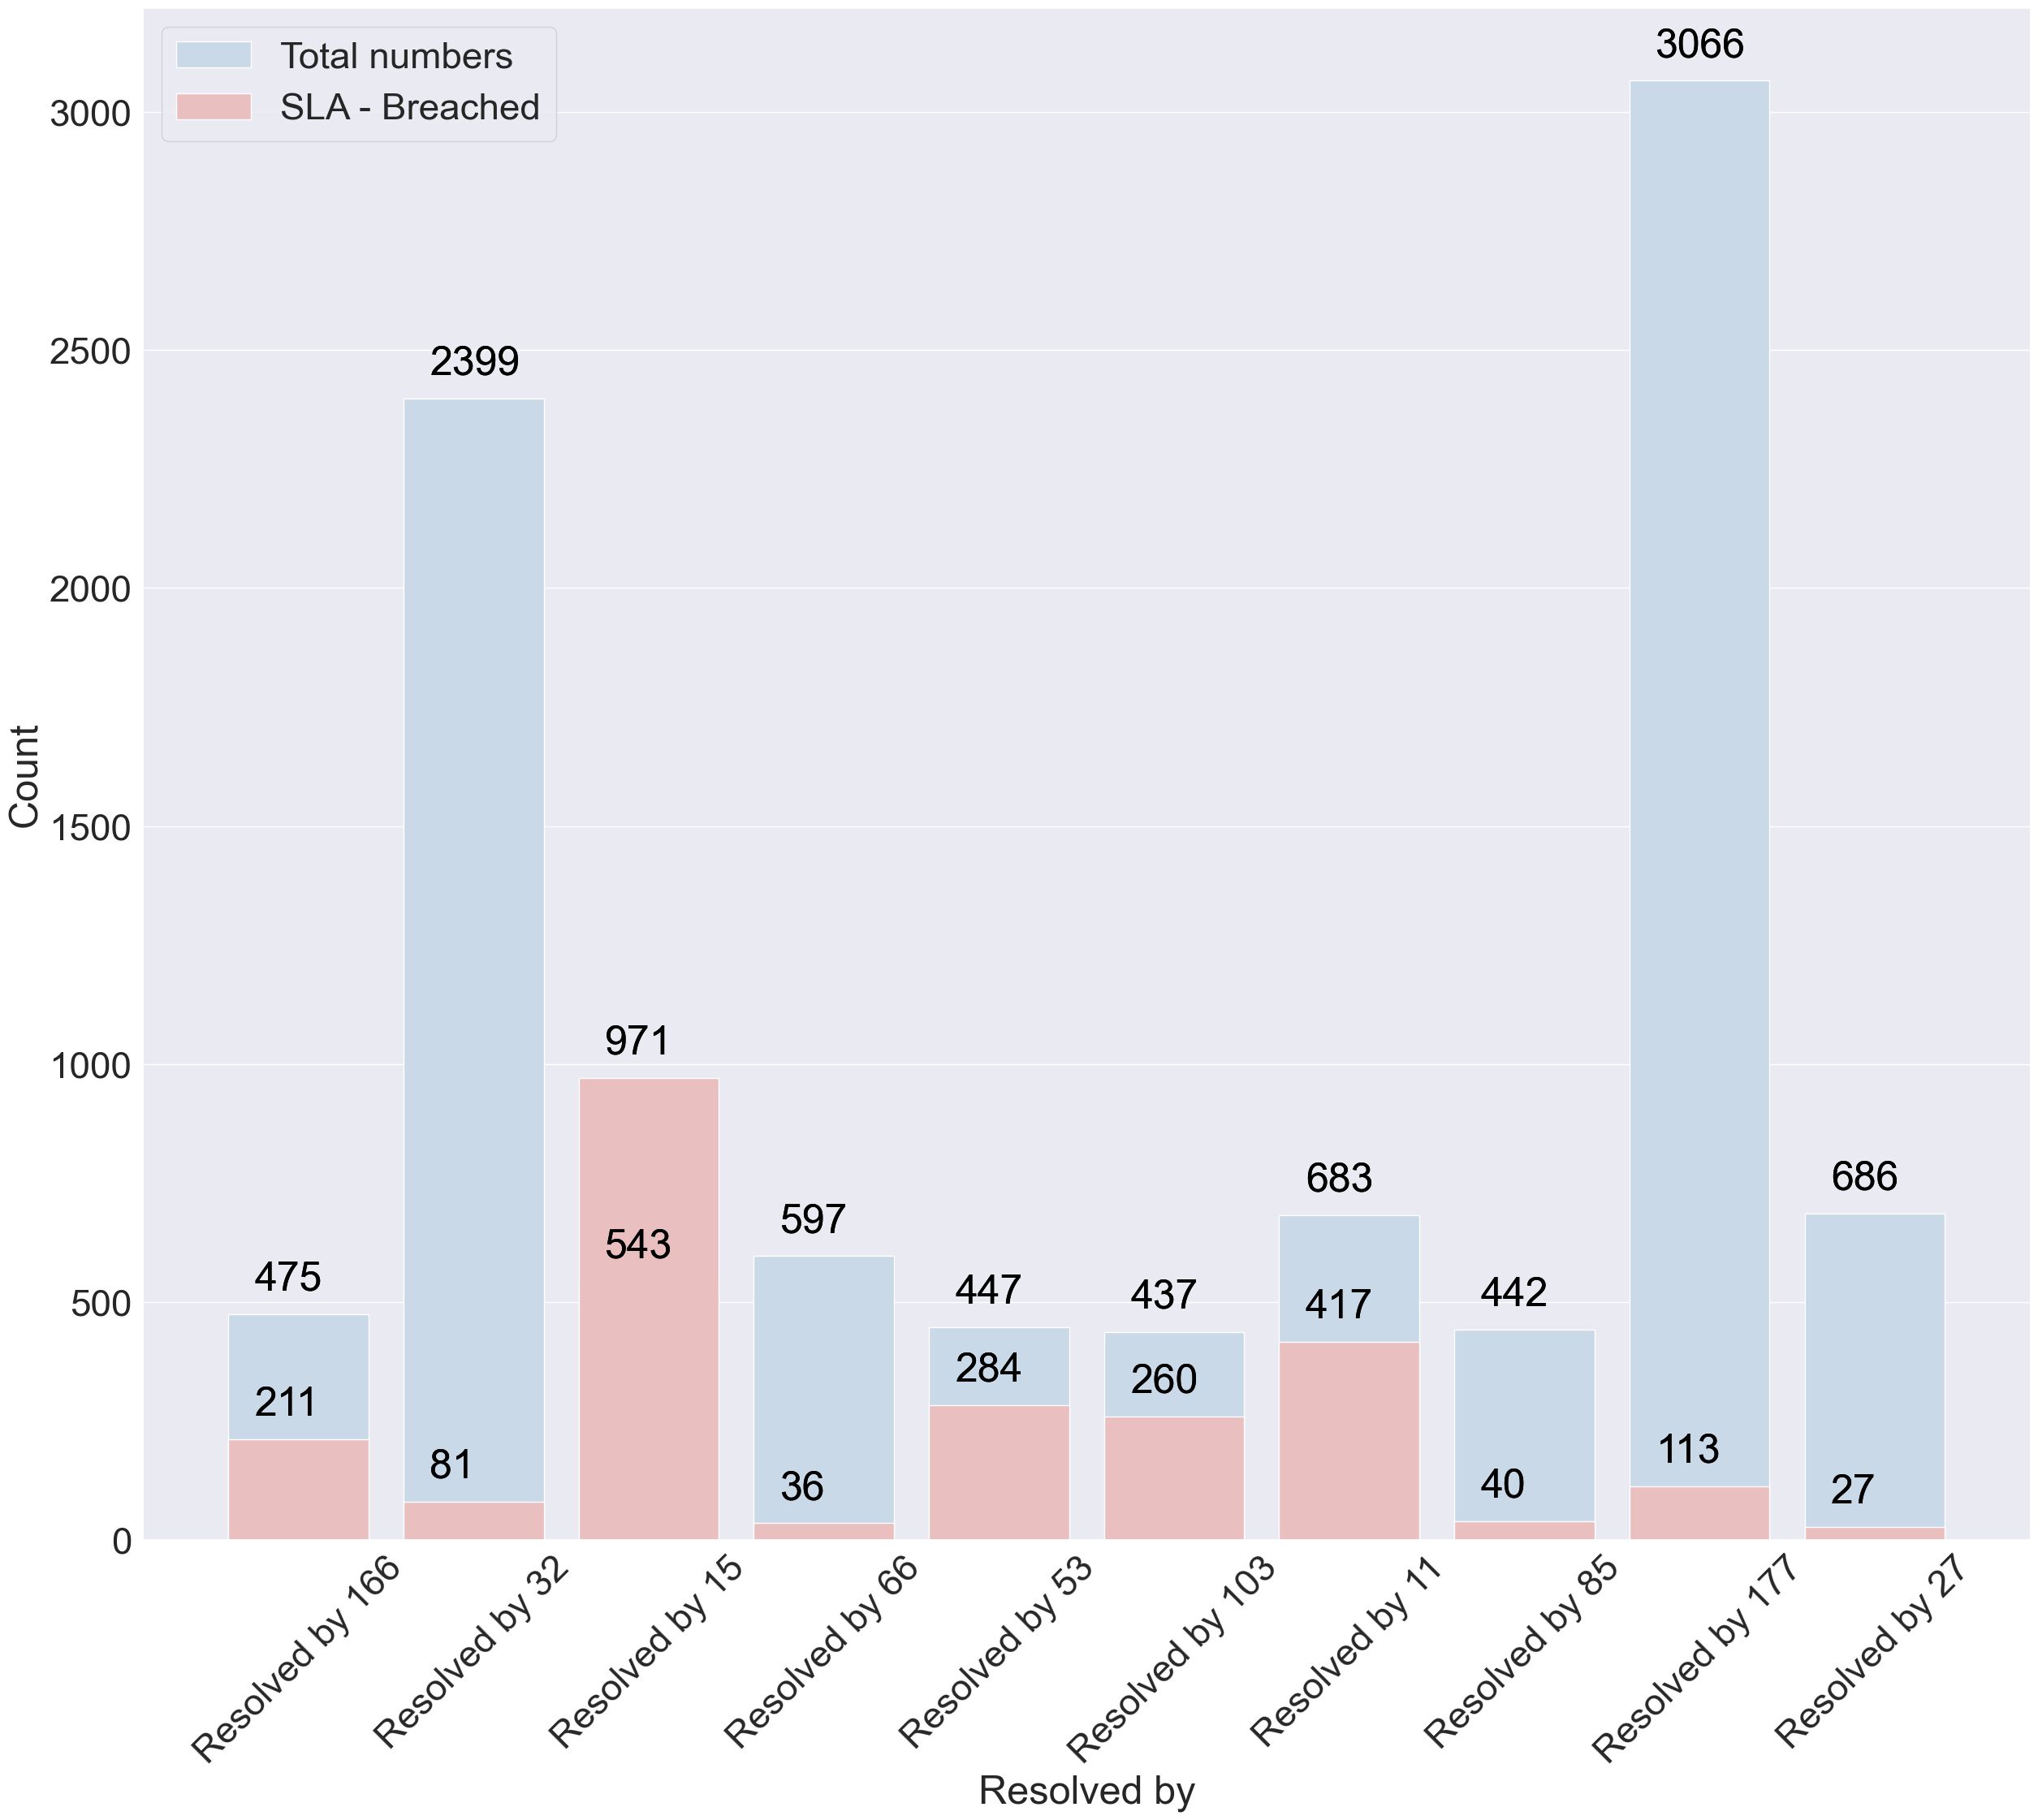

In [149]:
filter1 = inc_closed["resolved_by"].value_counts()[:10]
data = inc_closed[inc_closed["resolved_by"].isin(filter1.index)]
ax1=sns.countplot(x="resolved_by",data=data,color="#c4d9ec")
ax2=sns.countplot(x="resolved_by",data=data[data["made_sla"]==False],color="#f0b8b8") 
plt.ylabel("Count",fontsize=35)  
plt.xlabel("Resolved by",fontsize=35)  
plt.legend(["Total numbers","SLA - Breached"])
plt.margins(0.05)
plt.xticks(rotation=45)
bar_count(ax1)
bar_count(ax2)

From the above plot we can get clear information that agent 117,32 and 66 is excellent in closing tickets with only few defaults.

However , it can be seen that agent 15, 53,103,166, and 11 are defaulting on at least 50% of the total ticket solved by them. Hence they need to be reviewed.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Resolved by 85'),
  Text(1, 0, 'Resolved by 15'),
  Text(2, 0, 'Resolved by 66'),
  Text(3, 0, 'Resolved by 32'),
  Text(4, 0, 'Resolved by 166'),
  Text(5, 0, 'Resolved by 27'),
  Text(6, 0, 'Resolved by 103'),
  Text(7, 0, 'Resolved by 53'),
  Text(8, 0, 'Resolved by 11'),
  Text(9, 0, 'Resolved by 177')])

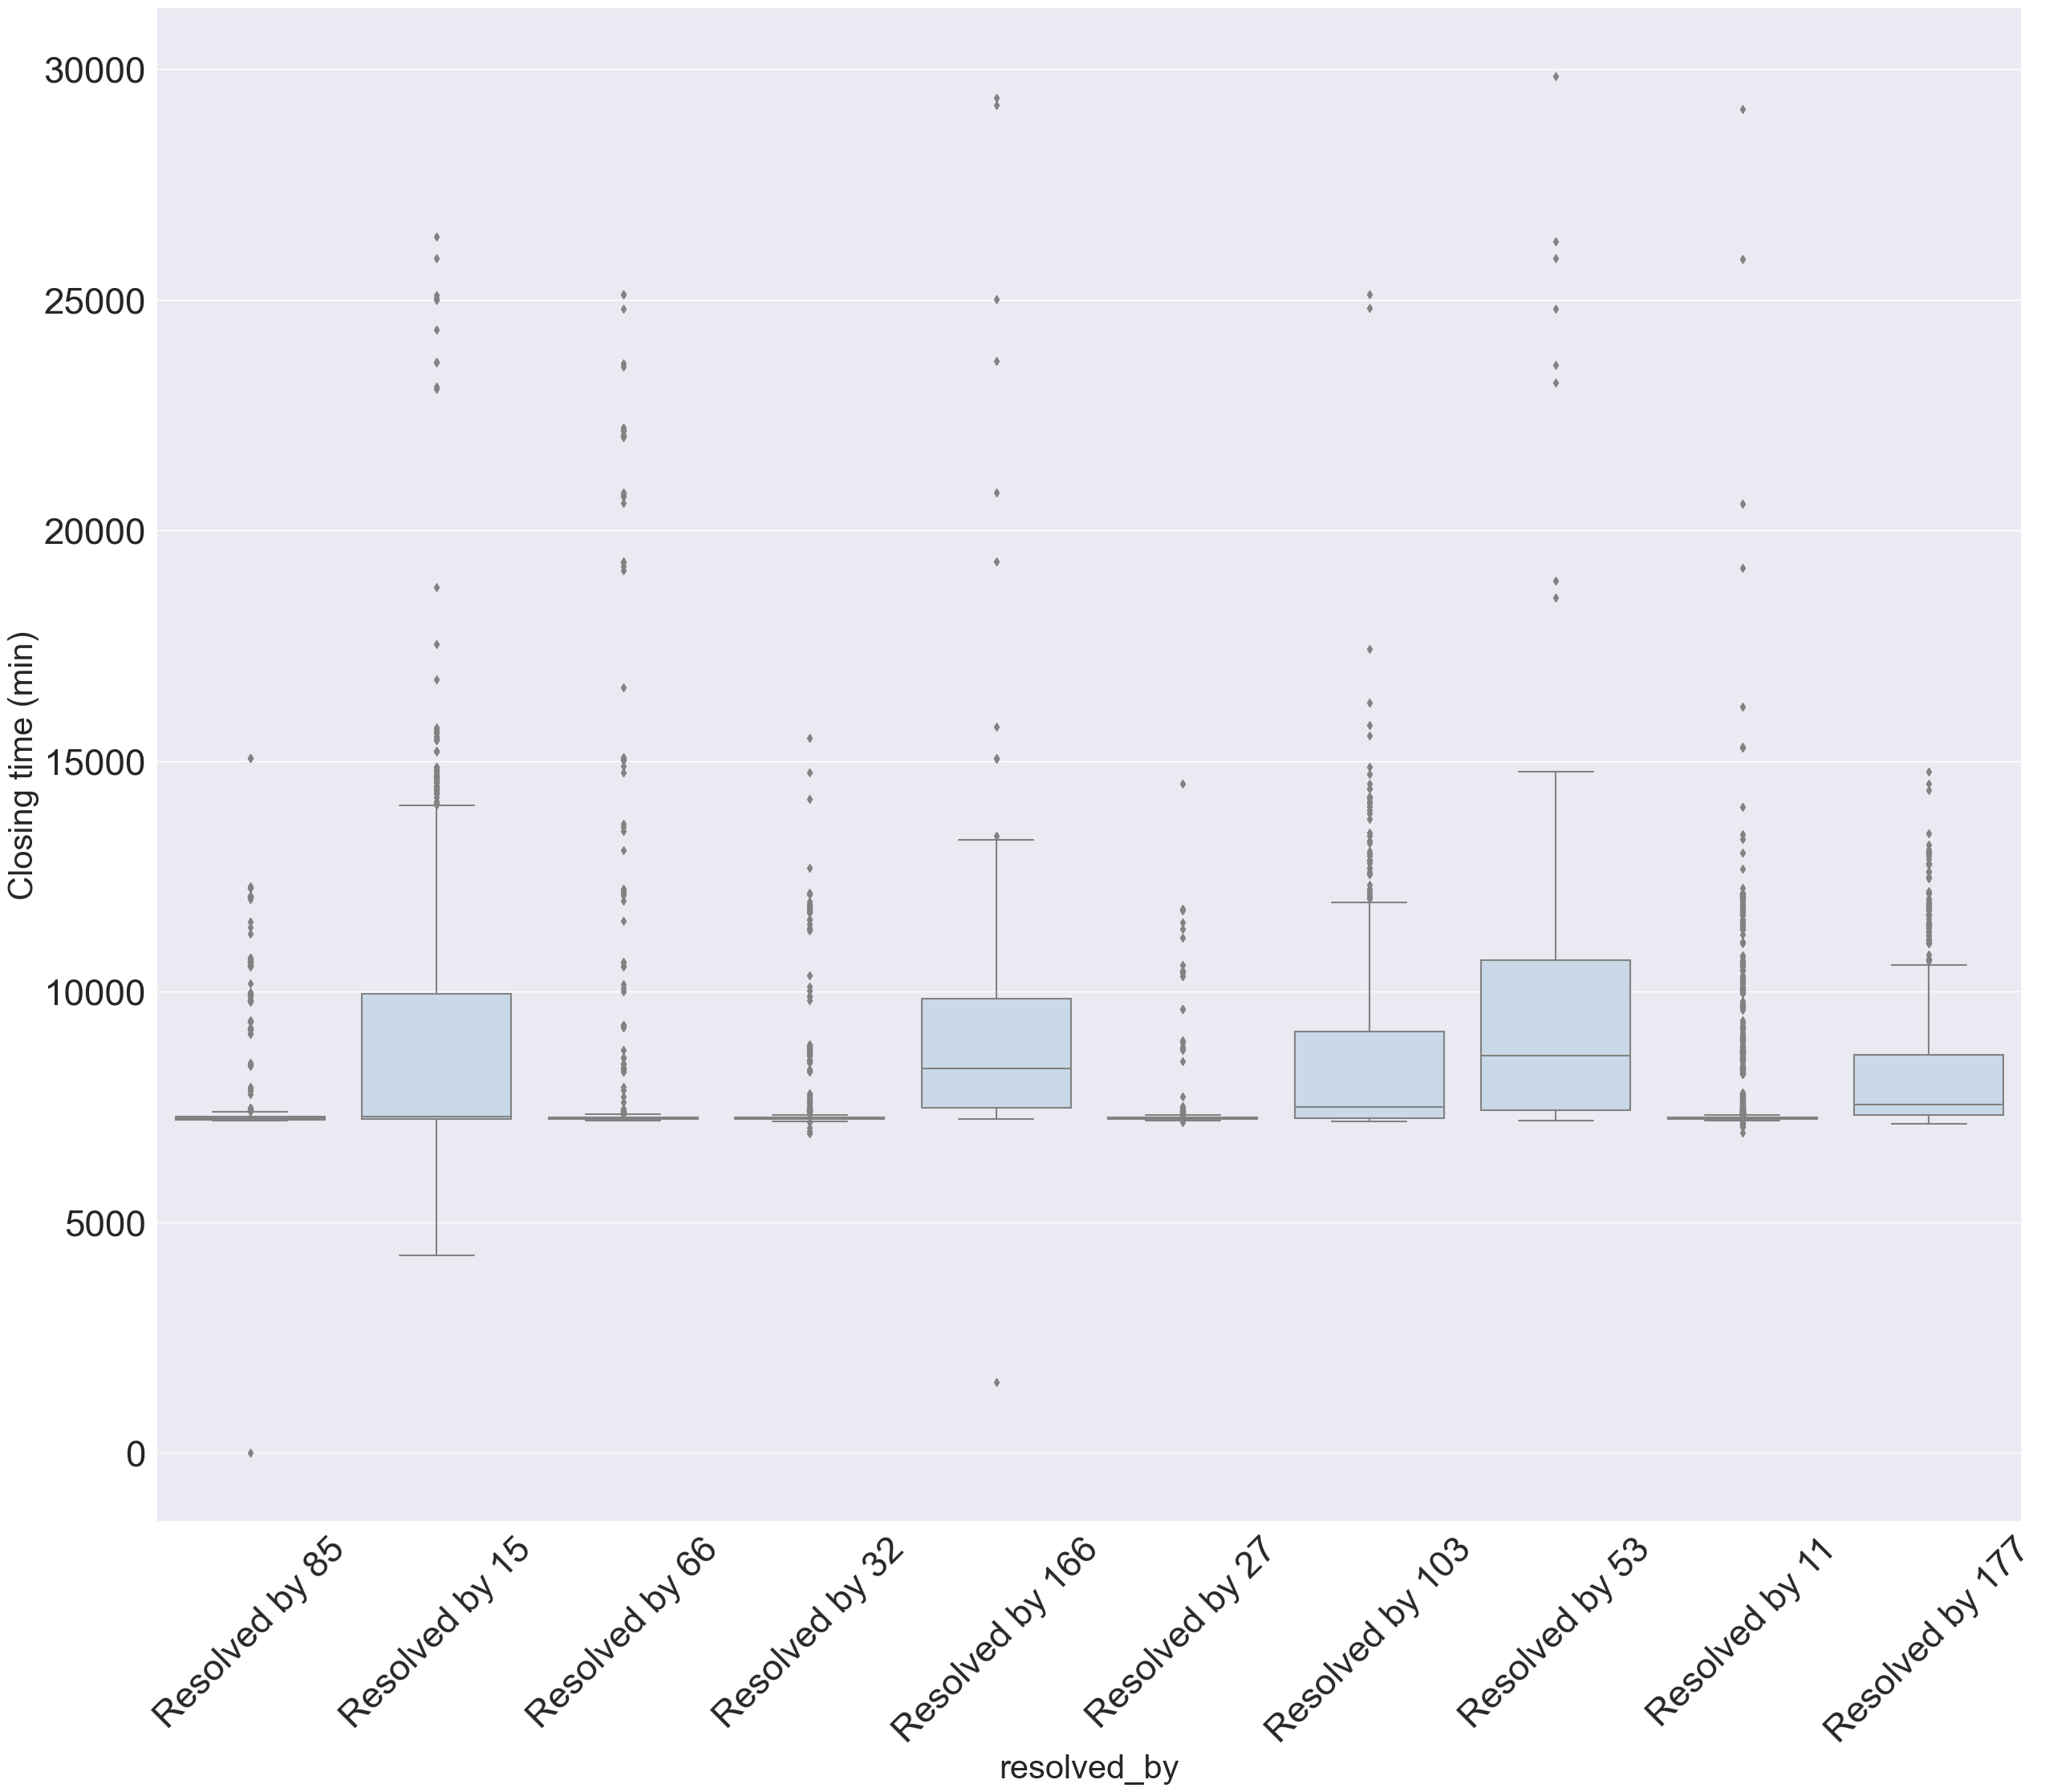

In [150]:
df = inc_closed[inc_closed["made_sla"]==True]
df1 = df[df.resolved_by.isin(filter1.index)]
drop = df1[df1["Closing time (min)"]>=35000]["number"].values

df1 = df1[~df1.number.isin(drop)]


sns.boxplot(x ='resolved_by', y ='Closing time (min)', data = df1,color= "#c4d9ec")
plt.xticks(rotation=45)

Above plot shows closing time for all the top 10 ticket resolvers , it should be noted that data shown above are only for ticket that are closed within SLA and it can be seen that most of the agent close tickets successfuly within 10000 min, for both Priority 3 and Priority 4 tickets.

# Predicting Closing time

We are trying to predict the time to resolution as soon as the ticket is created in the system.
Only few features will be avaiable to predict the target value in the intial stage and most of them are catergorical, we will be doing label encoding.

we will also be using MinMaxScaler to scale down all the variables.

## Preprocessing Data

#### Below function can be used to convert all the catogrical features 

In [151]:
def label_conv(dataset):
    
    all_col = dataset.columns
    from sklearn.preprocessing import LabelEncoder
    lb_make = LabelEncoder()
    for x in all_col:
        if dataset[x].dtype == 'O':
            dataset[x] = dataset[x].astype(str)
            dataset[x] = lb_make.fit_transform(dataset[x])
    
            

In [152]:
label_conv(inc_closed)

# Selecting features that will be available at the first stage of the ticket.
inc_closed1 = inc_closed[["contact_type","category","subcategory","impact","urgency","priority","knowledge","Closing time (min)"]]




# splitting the data into test and training set

X = inc_closed1.drop(["Closing time (min)"], axis = 1)
y = inc_closed1["Closing time (min)"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state = 42)



# preprocessing

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns= X.columns)
X_test_df = pd.DataFrame(X_test, columns= X.columns)



## Linear Regression

In [153]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score,cross_val_predict

regressor = LinearRegression()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)
score
print("score: {}".format(score))

score: 0.01977749257365813


In [154]:
regressor = LinearRegression()
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))

print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.03205781 0.02693289 0.03924606 0.0317979  0.03777239]
Average cross-validation score: 0.0336


## LASSO

In [155]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train,y_train)
print('Train score: {:.4f}'.format(lasso.score(X_train,y_train)))
print('Test score: {:.4f}'.format(lasso.score(X_test, y_test)))
lasso = Lasso(alpha=10)
score = cross_val_score(lasso,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Train score: 0.0342
Test score: 0.0199
Cross-validation scores: [0.03232102 0.02679934 0.03931069 0.03150461 0.03770045]
Average cross-validation score: 0.0335


In [156]:
from sklearn.model_selection import GridSearchCV
LR = {'alpha':[2,4,6,8,10,12]}
tuning = GridSearchCV(estimator=Lasso(),param_grid=LR,scoring='r2')
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

({'alpha': 4}, 0.0336706270884803)


## GradientBoosting

In [157]:
from sklearn.ensemble import GradientBoostingRegressor
gradient = GradientBoostingRegressor(random_state= 42)


In [158]:
score = cross_val_score(gradient,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.0970942  0.08200113 0.11250194 0.12357355 0.12533657]
Average cross-validation score: 0.1081


In [159]:
from sklearn.metrics import mean_squared_error as MSE

model = gradient.fit(X_train, y_train)
y_pred = gradient.predict(X_test)
testmse = MSE(y_test, y_pred) ** (1 / 2)
testmse

23882.054799248213

In [160]:
from sklearn.model_selection import GridSearchCV
LR = {'learning_rate':[0.15,0.1,0.10,0.05], 'n_estimators' : [100,150,200,250]}
tuning = GridSearchCV(estimator=GradientBoostingRegressor(),param_grid=LR,scoring='r2')
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.1, 'n_estimators': 150}, 0.11115651495526321)

# Random Forest

In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
regressor.fit(X_train,y_train)
score=regressor.score(X_test,y_test)
score

0.10510402103769168

In [162]:
from sklearn.model_selection import GridSearchCV
hyperparametres = { 'n_estimators':[5,10,15,20,25,30] }
tuning = GridSearchCV(estimator=RandomForestRegressor(),param_grid=hyperparametres,scoring='r2')
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

({'n_estimators': 25}, 0.1034691691340233)

## Conclusion 

We have seen that this dataset is ideal for descriptive analysis, however there is only a few categorical feature which do not have enough relationship with the feature we tried to predict. 

This is reflected by the poor R-Squared, or the coefficient of determination. However this also opens an oppertunity for further Ensemble techniques like XGBOOST, ADAboost.

Without the modelling part this data set can be used to present flaws in the working environment to the stackholder, which can then be used to increase the overall environment efficiency.

## APPENDIX

#   <center>Predicting time left to solve the ticket</center>

In [163]:
label_conv(inc_eventdf)
inc_eventdf1 = inc_eventdf[["active","category","impact","urgency","priority","knowledge","time_elapsed"]]
inc_eventdf1 = pd.get_dummies(inc_eventdf1,columns=["category","impact","urgency","priority","knowledge"],drop_first=True)

X = inc_eventdf1.drop(["time_elapsed"], axis = 1)
y = inc_eventdf1["time_elapsed"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state = 42)


from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns= X.columns)
X_test_df = pd.DataFrame(X_test, columns= X.columns)
X_train_df.head()

active  category_1  category_2  category_3  category_4  category_5  \
0     0.0         0.0         0.0         0.0         0.0         0.0   
1     1.0         0.0         0.0         0.0         0.0         0.0   
2     1.0         0.0         0.0         0.0         0.0         0.0   
3     1.0         0.0         0.0         0.0         0.0         0.0   
4     1.0         0.0         0.0         0.0         0.0         0.0   

   category_6  category_7  category_8  category_9  category_10  category_11  \
0         0.0         0.0         0.0         0.0          0.0          0.0   
1         0.0         0.0         0.0         0.0          0.0          0.0   
2         0.0         0.0         0.0         0.0          0.0          0.0   
3         0.0         0.0         0.0         0.0          0.0          0.0   
4         0.0         0.0         0.0         0.0          0.0          0.0   

   category_12  category_13  category_14  category_15  category_16  \
0          0.0          1.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   category_17  category_18  category_19  category_20  category_21  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          1.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   category_22  category_23  category_24  category_25  category_26  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          1.0          0.0          0.0          0.0          0.0   

   category_27  category_28  category_29  category_30  category_31  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          1.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          1.0   
4          0.0          0.0          0.0          0.0          0.0   

   category_32  category_33  category_34  category_35  category_36  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   category_37  category_38  category_39  category_40  category_41  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   category_42  category_43  category_44  category_45  category_46  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   category_47  category_48  category_49  category_50  category_51  \
0          0.0          0.0          0.0          0.0          0.0   
1 

## GradientBoosting

In [164]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score


gradient = GradientBoostingRegressor()


In [165]:
score = cross_val_score(gradient,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.11693193 0.11361967 0.11502866 0.11554857 0.12337991]
Average cross-validation score: 0.1169


In [166]:
from sklearn.metrics import mean_squared_error as MSE

model = gradient.fit(X_train, y_train)
y_pred = gradient.predict(X_test)
testmse = MSE(y_test, y_pred) ** (1 / 2)
testmse

21421.111086446243

## Random Forest

In [167]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
regressor.fit(X_train,y_train)
score=regressor.score(X_test,y_test)
score

0.12652583863185296

In [168]:
hyperparametres = { 'n_estimators':20 }
regressor = RandomForestRegressor(**hyperparametres)
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.12528899 0.11635577 0.1220596  0.11720536 0.12984712]
Average cross-validation score: 0.1222


## Linear Regression 

In [169]:

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
score = regressor.score(X_test, y_test)
score

0.111131908284539

In [170]:
regressor = LinearRegression()
score = cross_val_score(regressor,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [ 1.08841420e-01  1.06611923e-01 -1.67596451e+21  1.08257028e-01
 -6.97888442e+23]
Average cross-validation score: -139912881294047180750848.0000


## LASSO

In [171]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 10)
lasso.fit(X_train,y_train)
print('Train score: {:.4f}'.format(lasso.score(X_train,y_train)))
print('Test score: {:.4f}'.format(lasso.score(X_test, y_test)))

Train score: 0.1095
Test score: 0.1094


In [172]:
lasso = Lasso(alpha = 10)
score = cross_val_score(lasso,X_train,y_train,cv=5)

print("Cross-validation scores: {}".format(score))
print("Average cross-validation score: {:.4f}".format(score.mean()))

Cross-validation scores: [0.10852339 0.10670971 0.10628775 0.10831097 0.11450495]
Average cross-validation score: 0.1089
